In [1]:
from install_packages import *

In [2]:
install_packages()


scikit-learn

numpy

matplotlib

torch

pytorch-lightning

wandb

einops

torchvision

pandas


In [180]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd
from get_cifar import CIFAR10_Wrapper
from jmr_data import create_openai_data, DatasetWrapper, ToyTest
from einops import repeat, rearrange
from functools import reduce
import seaborn as sns

In [181]:
LABEL_INDEX = -3
Y_HAT_INDEX = -2
IDX_INDEX = -1

# Helper Functions

In [182]:
def process_merge(paths, epoch, distance_metric = 'l2', normalization = 'none'):
    all_dfs = []
    for i, path in enumerate(paths):
        dat = torch.load(path + str(epoch), map_location=torch.device('cpu'), weights_only=True)
        print(dat.shape)
        labels = dat[: , LABEL_INDEX]
        y_hats = dat[: , Y_HAT_INDEX]
        idx = dat[: , IDX_INDEX]
        activations = dat[: , :-3]
        uniq_labels = np.unique(labels)
        
        global_mean = activations.mean(axis=0)
        ordered_l2 = []
        ordered_labels = []
        ordered_idx = []
        ordered_y_hats = []
        
        for j in uniq_labels:
            labels_indexing = (labels == j)
            class_activations = activations[labels_indexing, :]
            class_mean = class_activations.mean(axis=0) - global_mean

            if normalization == 'class':
                class_std = class_activations.std(axis=0) + 0.0001
                class_activations = class_activations / repeat(class_std, 'u -> n u', n = class_activations.shape[0])
                class_mean = class_mean / class_std
                # print(class_std)

            elif normalization == 'global':
                global_std = activations.std(axis=0) + 0.0001
                class_activations = class_activations - repeat(global_mean, 'u -> n u', n = class_activations.shape[0])
                class_activations = class_activations / repeat(global_std, 'u -> n u', n = class_activations.shape[0])
                class_mean = class_mean / global_std

            if distance_metric == 'cosine':
                cos_dist = 1 - torch.nn.functional.cosine_similarity(class_activations, repeat(class_mean, 'u -> n u', n = class_activations.shape[0]))
                _ = [ordered_l2.append(diff) for diff in cos_dist]
            
            elif distance_metric == 'l2':
                class_diff = class_activations - repeat(class_mean, 'u -> n u', n = class_activations.shape[0])
                _ = [ordered_l2.append(torch.linalg.vector_norm(diff)) for diff in class_diff]
            
            _ = [ordered_labels.append(lab) for lab in labels[labels_indexing]]
            _ = [ordered_idx.append(ids) for ids in idx[labels_indexing]]
            _ = [ordered_y_hats.append(y_hat) for y_hat in y_hats[labels_indexing]]
        
        all_together = torch.vstack([torch.tensor(x) for x in [ordered_l2, ordered_labels, ordered_idx, ordered_y_hats]]).T
        df = pd.DataFrame(all_together, columns = [f'dist_{i}', f'labels', f'idx', f'y_hats_{i}'])
        if i != 0:
            df = df.drop(columns=['labels'])
        
        all_dfs.append(df)
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='idx', how='outer'), all_dfs)
    return merged_df

In [183]:
def graph_hists(merged_df):
    l2_columns = [col for col in merged_df.columns if col.startswith('dist_')]
    num_cols = len(l2_columns)
    
    # Create a grid: 2 rows (general + label-wise), N columns (1 per l2_x)
    fig, axes = plt.subplots(2, num_cols, figsize=(5 * num_cols, 10), sharey='row')
    
    # Row 1: General histograms
    for i, col in enumerate(l2_columns):
        ax = axes[0, i]
        sns.histplot(merged_df[col], bins=30, kde=False, ax=ax, color='skyblue')
        ax.set_title(f"{col} - Overall")
        ax.set_xlabel("")
        ax.set_ylabel("Count")
    
    # Row 2: Label-wise histograms
    if len(np.unique(merged_df['labels'])) < 11:
        for i, col in enumerate(l2_columns):
            ax = axes[1, i]
            for label in sorted(merged_df['labels'].unique()):
                subset = merged_df[merged_df['labels'] == label]
                sns.histplot(subset[col], bins=30, kde=False, label=f"Label {label}", alpha=0.5, ax=ax)
            ax.set_title(f"{col} - By Label")
            ax.set_xlabel("Value")
            ax.set_ylabel("Count")
            ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Group by 'labels' and calculate mean and std
    grouped_stats = merged_df.groupby('labels')[l2_columns].agg(['mean', 'std'])
    
    # Optional: flatten MultiIndex columns
    grouped_stats.columns = [f"{col}_{stat}" for col, stat in grouped_stats.columns]
    
    # Display the result
    display(grouped_stats)

In [184]:
def top_x_percent_per_label(merged_df, percent):
    l2_columns = [col for col in merged_df.columns if col.startswith('dist_')]

    # List to store the final output
    top_10_percent_idxs = []
    quant = 1 - percent
    
    for col in l2_columns:
        top_idxs = []
        for label in merged_df['labels'].unique():
            subset = merged_df[merged_df['labels'] == label]
            threshold = subset[col].quantile(quant)
            idxs = subset[subset[col] >= threshold]['idx'].to_numpy()
            top_idxs.append(idxs)
        
        # Combine all labels' top idxs into a single array (e.g., union)
        combined = np.unique(np.concatenate(top_idxs))
        top_10_percent_idxs.append(combined)

    union_all = reduce(np.union1d, top_10_percent_idxs)
    intersection_all = reduce(np.intersect1d, top_10_percent_idxs)

    print(f'Jaccard Similarity: {len(intersection_all)/len(union_all)}')
    print(f'Size of Union: {len(union_all)}')
    print(f'Size of Intersection: {len(intersection_all)}')
    
    return top_10_percent_idxs, union_all, intersection_all

In [185]:
def bottom_x_percent_per_label(merged_df, percent):
    l2_columns = [col for col in merged_df.columns if col.startswith('dist_')]

    # List to store the final output
    bottom_10_percent_idxs = []
    quant = 1 - percent
    
    for col in l2_columns:
        bottom_idxs = []
        for label in merged_df['labels'].unique():
            subset = merged_df[merged_df['labels'] == label]
            threshold = subset[col].quantile(percent)
            idxs = subset[subset[col] <= threshold]['idx'].to_numpy()
            bottom_idxs.append(idxs)
        
        # Combine all labels' top idxs into a single array (e.g., union)
        combined = np.unique(np.concatenate(bottom_idxs))
        bottom_10_percent_idxs.append(combined)

    union_all = reduce(np.union1d, bottom_10_percent_idxs)
    intersection_all = reduce(np.intersect1d, bottom_10_percent_idxs)

    print(f'Jaccard Similarity: {len(intersection_all)/len(union_all)}')
    print(f'Size of Union: {len(union_all)}')
    print(f'Size of Intersection: {len(intersection_all)}')
    
    return bottom_10_percent_idxs, union_all, intersection_all

# Baseline CIFAR

In [231]:
paths = [f'class_means_distance/cifar_baseline_final_t_data_cifar10_iter_{x}_max_epochs_400/train/train_raw_activations_epoch_' for x in list(range(5))]

## End of Convergence (Epoch 350)

### Unnormalized L2 distance from class means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


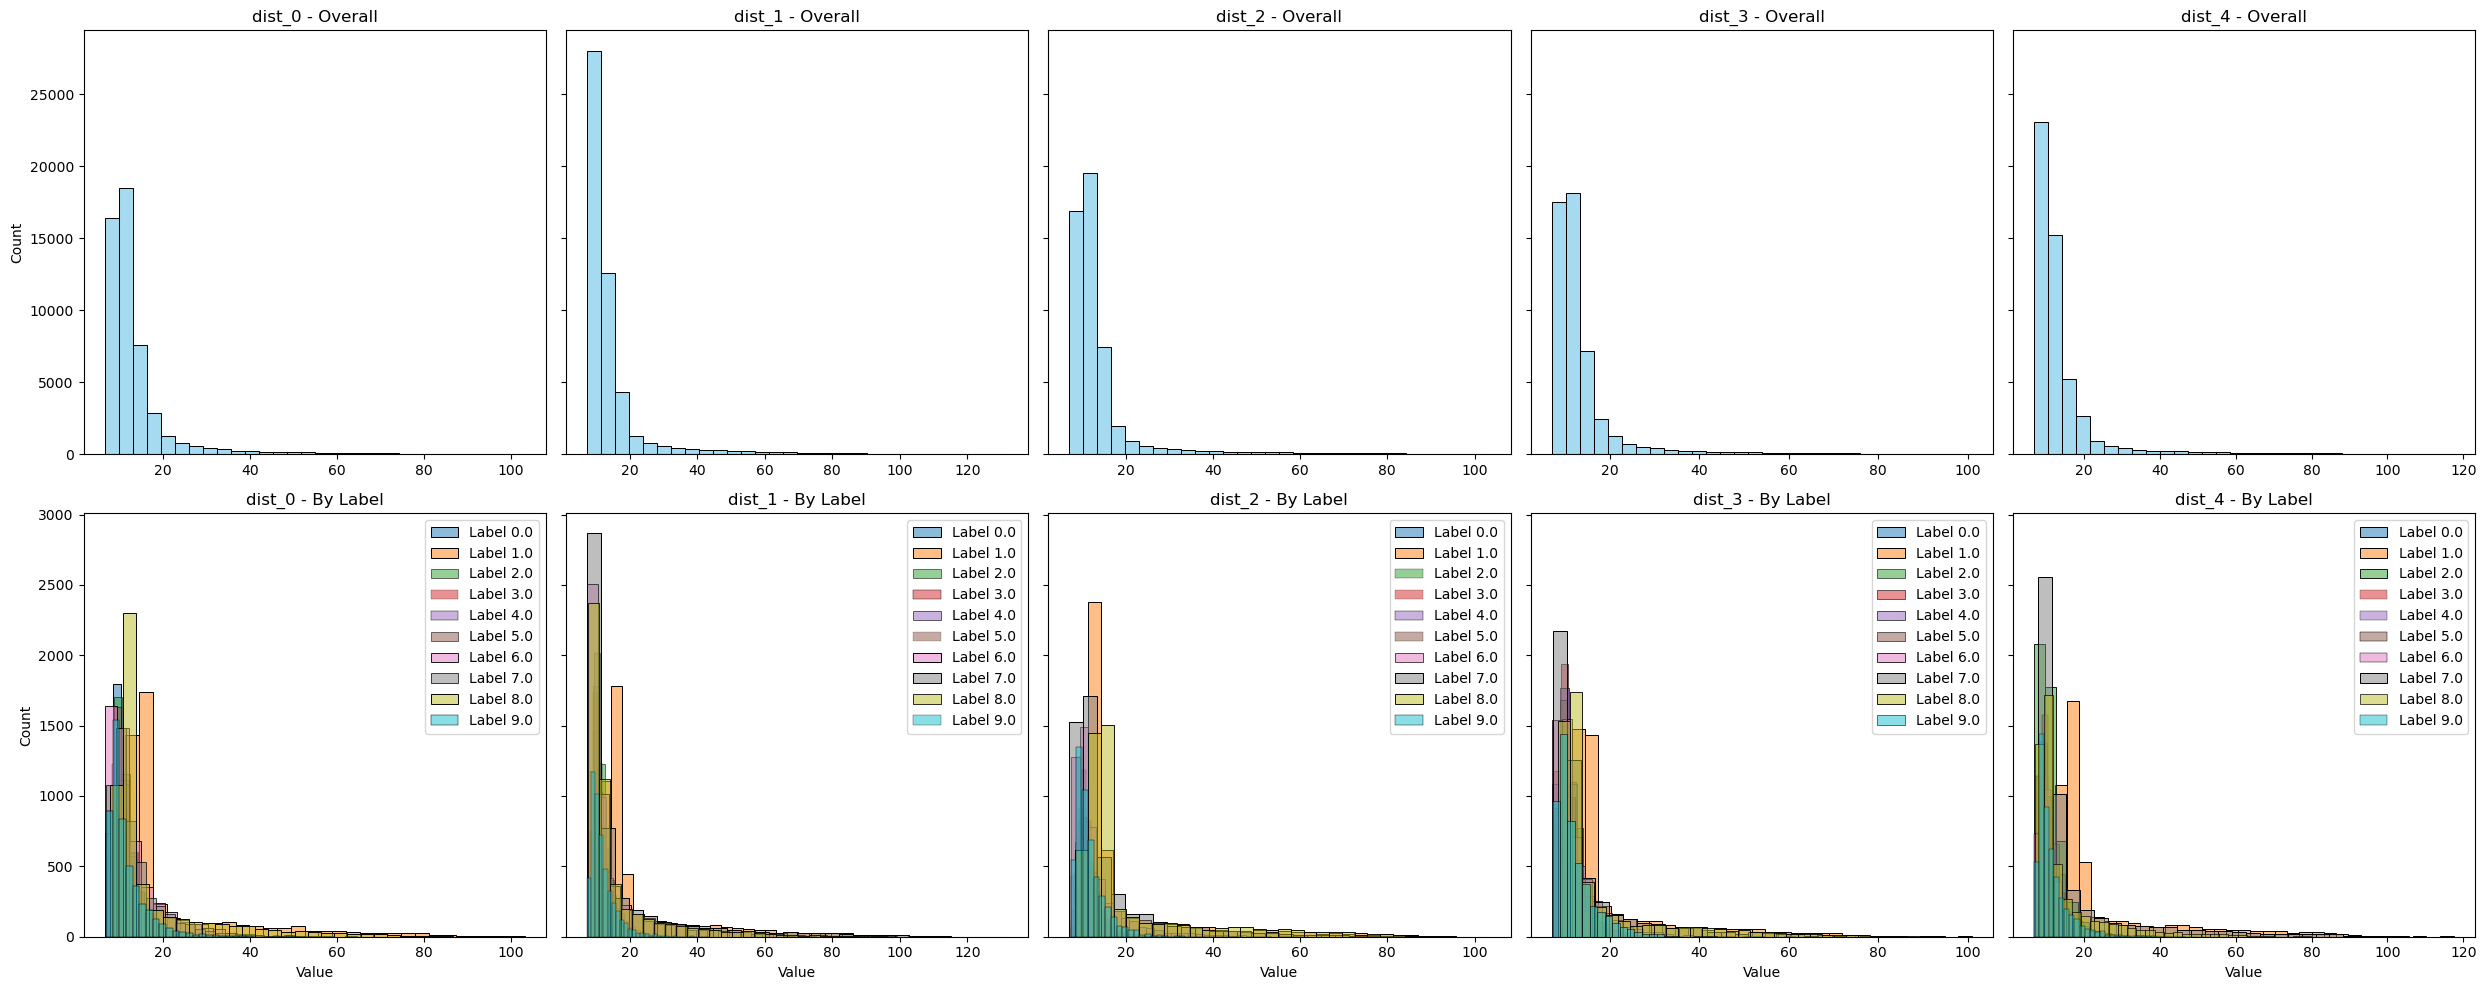

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,11.426192,3.537902,12.188678,3.777743,11.376144,2.458915,11.548346,2.859480,11.901183,3.891526
1.0,21.618587,15.392699,22.999407,16.373009,19.673912,14.735642,20.306822,13.798703,24.606392,17.418356
2.0,11.238353,3.180776,11.602684,2.775558,11.240687,2.415627,11.780533,3.299577,11.376555,3.896761
3.0,10.631721,2.211288,11.125155,2.520085,10.794991,1.834689,10.851737,2.699776,10.363132,2.114510
4.0,11.496383,3.557075,11.293470,2.883632,11.102019,2.665599,11.194785,3.044564,10.646023,2.413132
5.0,11.509526,3.976558,11.006174,1.950966,11.327539,2.336755,11.590421,3.932732,11.143807,3.331095
6.0,13.184132,6.831421,16.031309,12.657713,13.233660,6.550798,12.345244,5.542762,11.531546,4.160981
7.0,13.624674,6.563240,18.342386,16.999710,15.871713,10.877413,15.809400,11.908507,18.058834,15.524968
8.0,17.557600,12.605973,16.334339,12.638379,21.012829,15.293206,17.975140,13.236971,15.016300,10.284776


In [232]:
merged_df = process_merge(paths, 350)
graph_hists(merged_df)

#### Top 10% Per Class

In [233]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.029199090971696165
Size of Union: 14521
Size of Intersection: 424


In [234]:
torch.save(union_all, 'baseline_indexes/unnormed_l2_end_cifar')

#### Bottom 10% Per Class

In [235]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0016533637400228051
Size of Union: 17540
Size of Intersection: 29


#### Highest 10% STD Per Class

### Class Normalized L2 Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


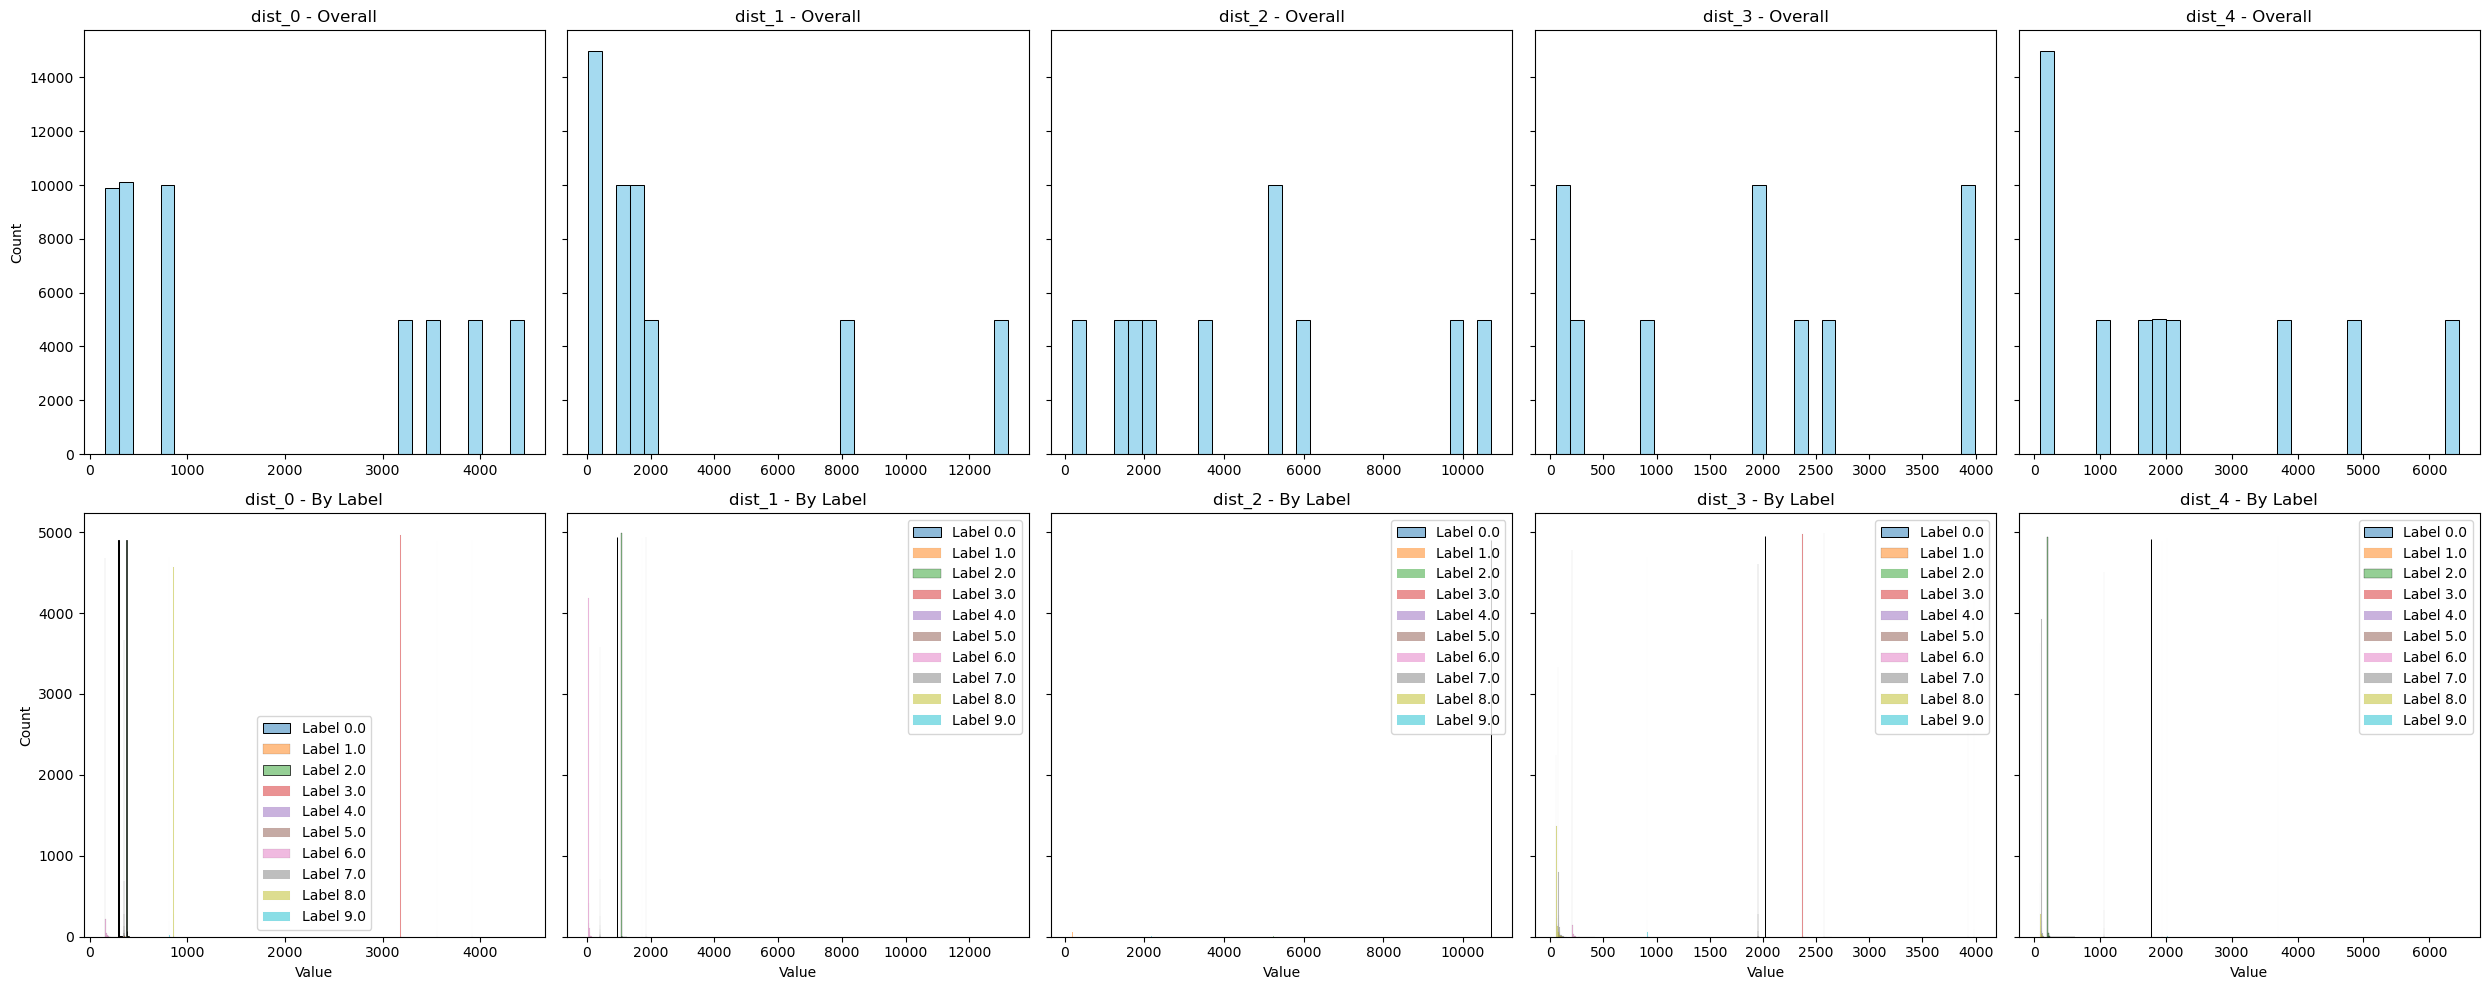

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,292.276611,5.330744,943.365906,2.159117,10707.611328,0.156056,2016.694580,1.037670,1772.154175,0.985387
1.0,350.721954,1.345071,401.752686,1.261630,194.828644,2.575150,1955.601562,0.333789,1059.882202,0.525655
2.0,376.957947,4.202490,1078.248047,2.922171,5243.191406,0.376023,3927.325195,0.566961,192.816711,8.114975
3.0,3183.017822,0.760509,1849.156372,1.272821,9950.391602,0.307935,2370.926025,1.152037,4841.944336,0.465148
4.0,3916.657227,0.409420,8199.290039,0.377883,5181.815430,0.418533,2573.173096,1.198639,6428.269043,0.463548
5.0,3558.161133,0.431189,13194.813477,0.145436,6030.496582,0.448353,3984.489990,0.405832,3696.149658,0.584494
6.0,156.988693,5.764493,51.583527,10.476341,3383.832031,0.296867,201.723282,5.506912,1937.965820,0.870321
7.0,4439.727539,0.193898,368.552521,1.939249,1382.241943,0.561764,77.996849,7.374079,112.282166,5.255078
8.0,859.676208,0.815933,1366.670898,0.567238,1747.335205,0.294469,59.361286,7.551061,90.727280,6.608416


In [236]:
merged_df = process_merge(paths, 350, normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [237]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.01663188515778157
Size of Union: 15813
Size of Intersection: 263


#### Bottom 10% Per Class

In [238]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.001894150417827298
Size of Union: 17950
Size of Intersection: 34


### Global Normalized L2 Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


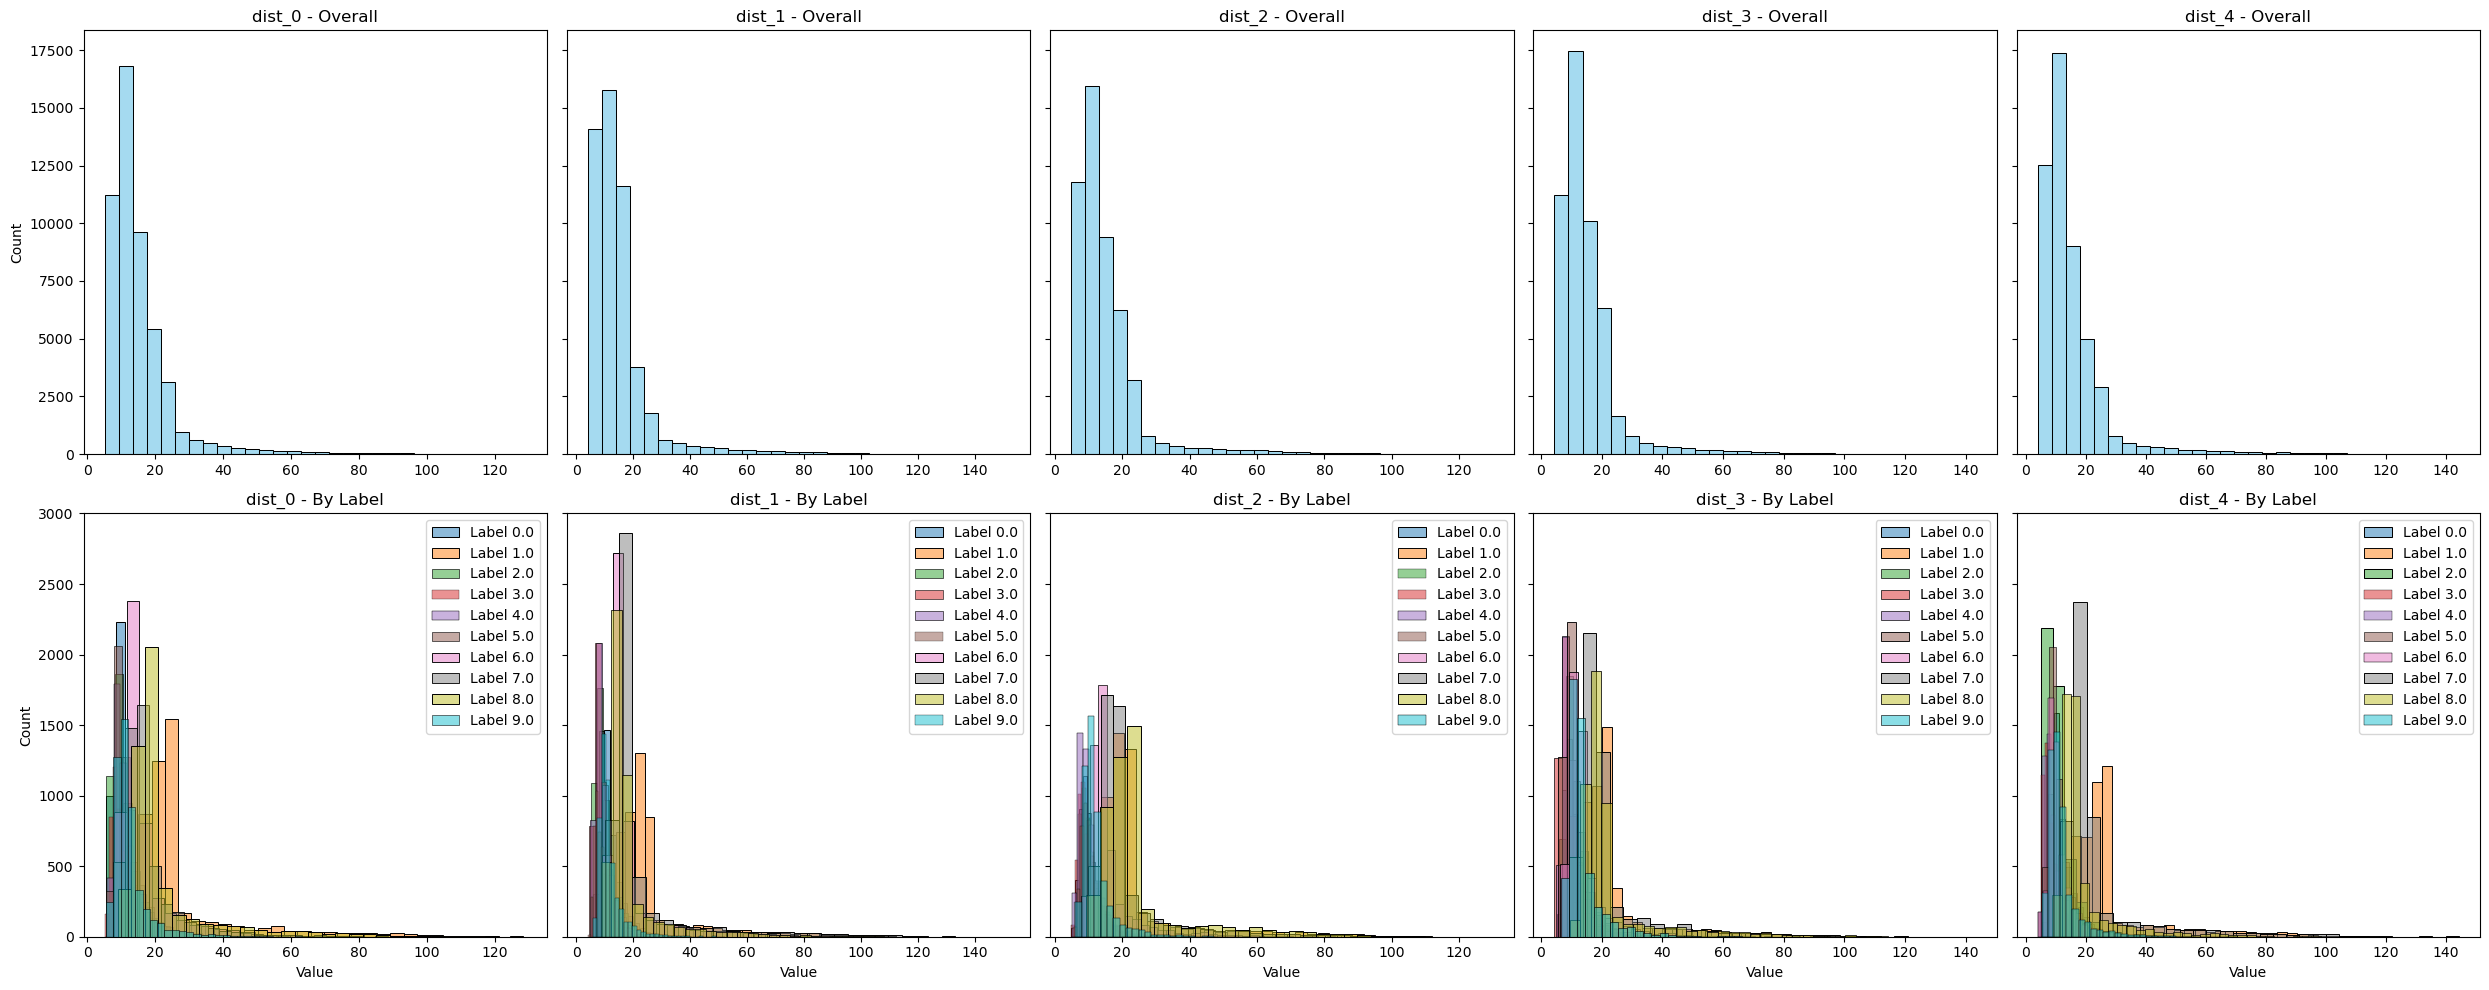

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,11.475471,5.105565,12.004625,4.504185,10.262086,3.203818,11.317508,4.459812,12.545333,5.048234
1.0,27.592712,16.231581,26.413073,15.020931,24.482256,14.680251,24.393124,13.549663,28.814768,16.350677
2.0,11.153945,4.725204,10.141563,3.932670,10.582759,3.752609,11.890125,4.711938,11.059676,5.614409
3.0,10.050311,3.645346,9.073949,3.495600,9.401302,2.943193,9.000140,3.725099,8.558685,3.294000
4.0,11.340059,4.442249,9.461288,3.800954,10.220101,3.781472,10.304201,4.027765,8.947742,3.461961
5.0,11.969487,5.471952,8.989552,2.966696,10.887134,3.362644,11.504015,5.919811,11.517798,5.180340
6.0,16.703197,8.868285,19.559263,12.882627,16.292549,8.081032,14.353039,7.391084,11.496528,5.188613
7.0,17.863773,8.985369,23.202023,16.895838,21.507477,12.577000,21.952396,13.960122,24.458689,16.511000
8.0,22.547363,13.728770,19.338749,12.140634,25.272947,14.728713,23.402103,14.418938,19.198792,10.992950


In [239]:
merged_df = process_merge(paths, 350, normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [240]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.029690636030175098
Size of Union: 14449
Size of Intersection: 429


In [241]:
torch.save(union_all, 'baseline_indexes/global_normed_l2_end_cifar')

#### Bottom 10% Per Class

In [242]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0021119324181626186
Size of Union: 17046
Size of Intersection: 36


### Unnormalized Cosine Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


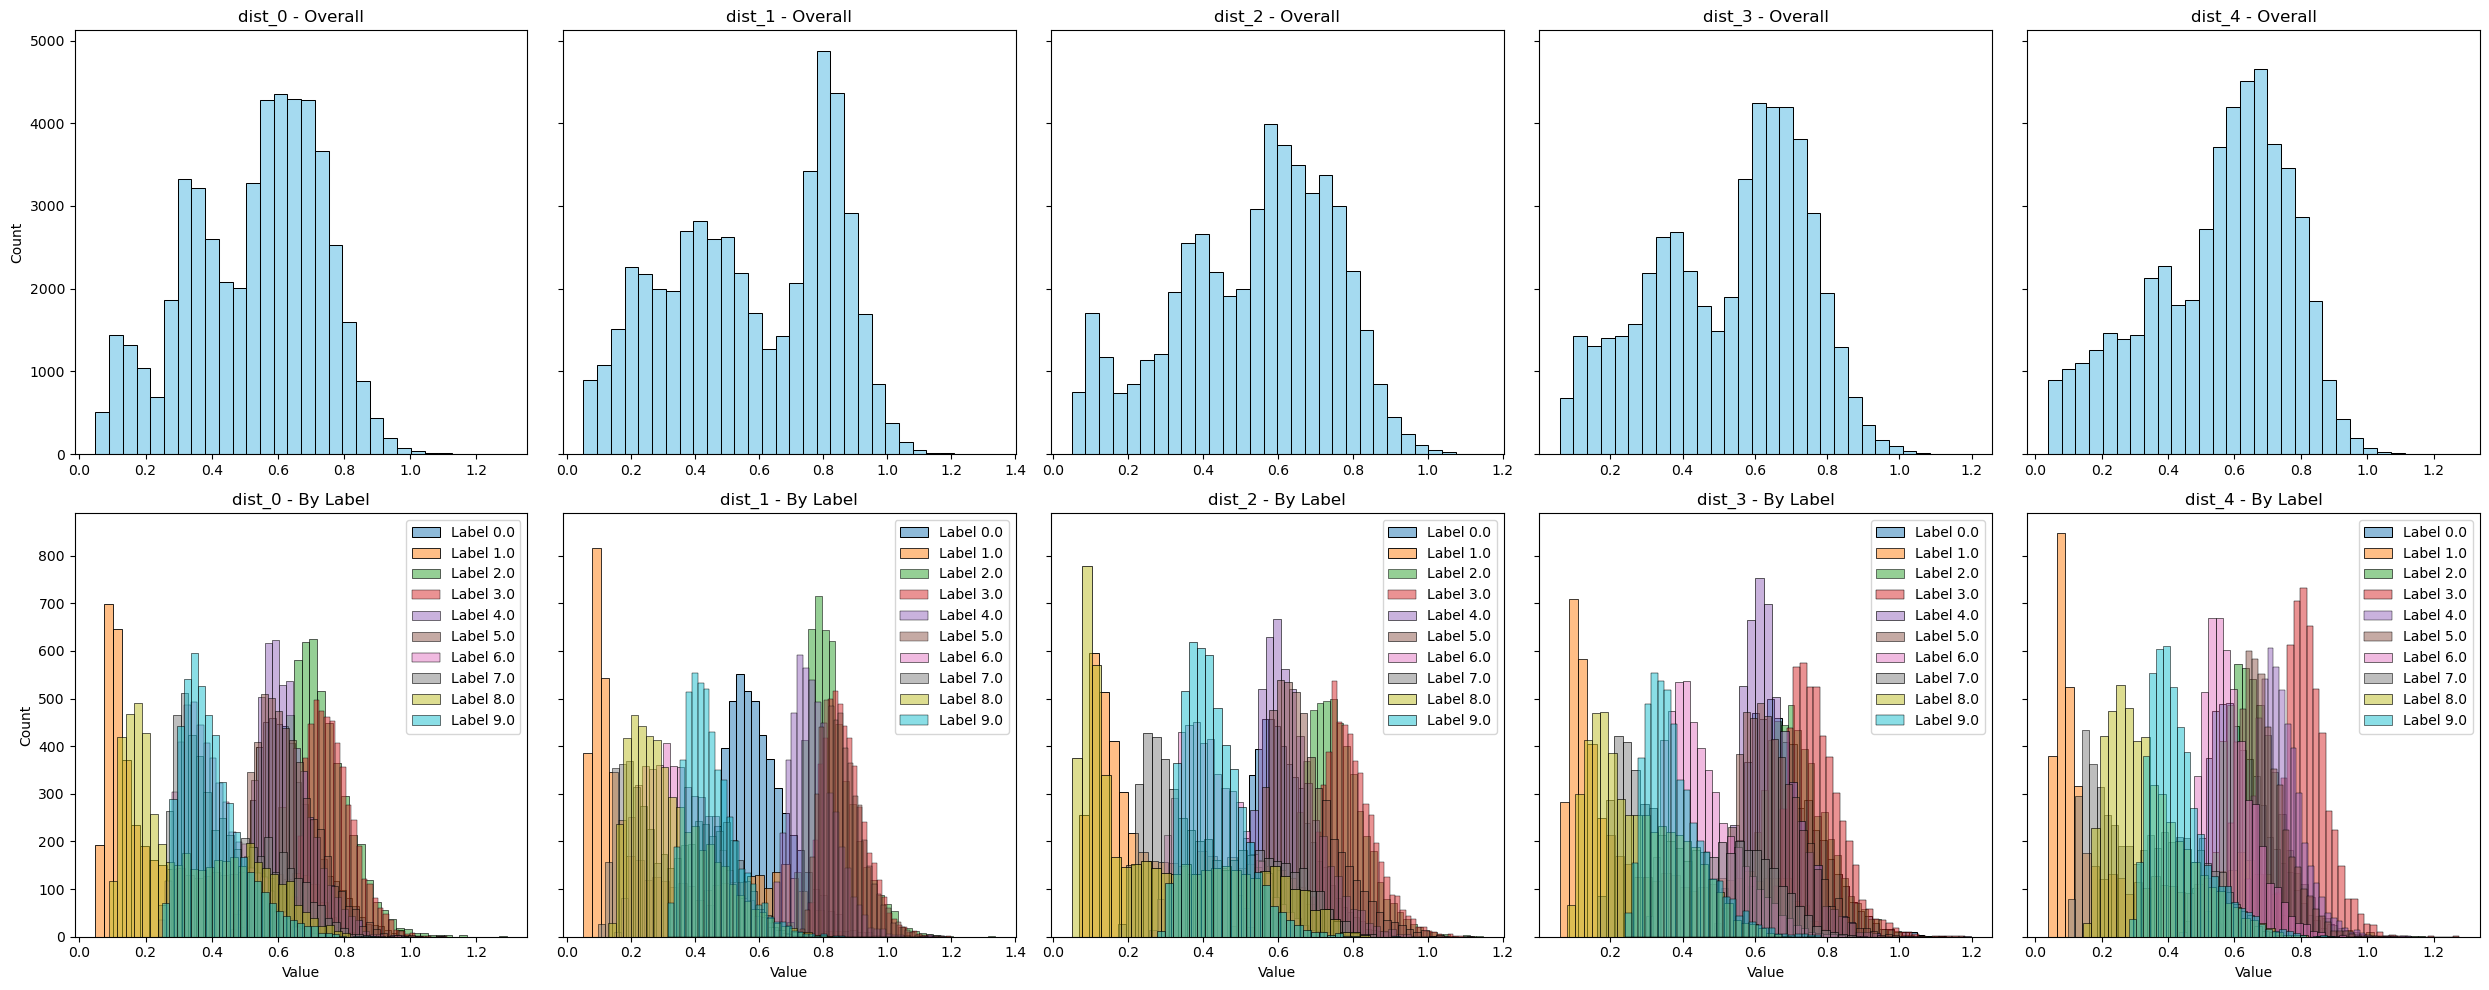

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.637815,0.093221,0.602933,0.095773,0.621468,0.076703,0.689983,0.093436,0.624339,0.089593
1.0,0.308788,0.213438,0.306088,0.228263,0.310919,0.186580,0.303414,0.208134,0.297866,0.226625
2.0,0.728857,0.083433,0.827523,0.074239,0.759272,0.074234,0.723146,0.081827,0.665411,0.084078
3.0,0.763169,0.067493,0.867358,0.063986,0.797587,0.064658,0.772342,0.069773,0.827241,0.058690
4.0,0.625766,0.075366,0.768502,0.067366,0.636324,0.075860,0.646146,0.072807,0.740531,0.063565
5.0,0.629008,0.087420,0.858711,0.063557,0.673390,0.087256,0.652273,0.084664,0.686382,0.071127
6.0,0.404280,0.092924,0.356102,0.107758,0.433261,0.090972,0.456052,0.093442,0.585637,0.074711
7.0,0.442363,0.136346,0.336878,0.143712,0.417053,0.155826,0.407718,0.162315,0.328222,0.150099
8.0,0.329749,0.175969,0.327119,0.126160,0.291928,0.205031,0.276332,0.124409,0.340718,0.120547


In [243]:
merged_df = process_merge(paths, 350, distance_metric = 'cosine', normalization = 'none')
graph_hists(merged_df)

#### Top 10% Per Class

In [244]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.022077200777561787
Size of Union: 14404
Size of Intersection: 318


In [245]:
torch.save(union_all, 'baseline_indexes/unnormed_cos_end_cifar')

#### Bottom 10% Per Class

In [246]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.007059427544602747
Size of Union: 15582
Size of Intersection: 110


### Class Normalized Cosine Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


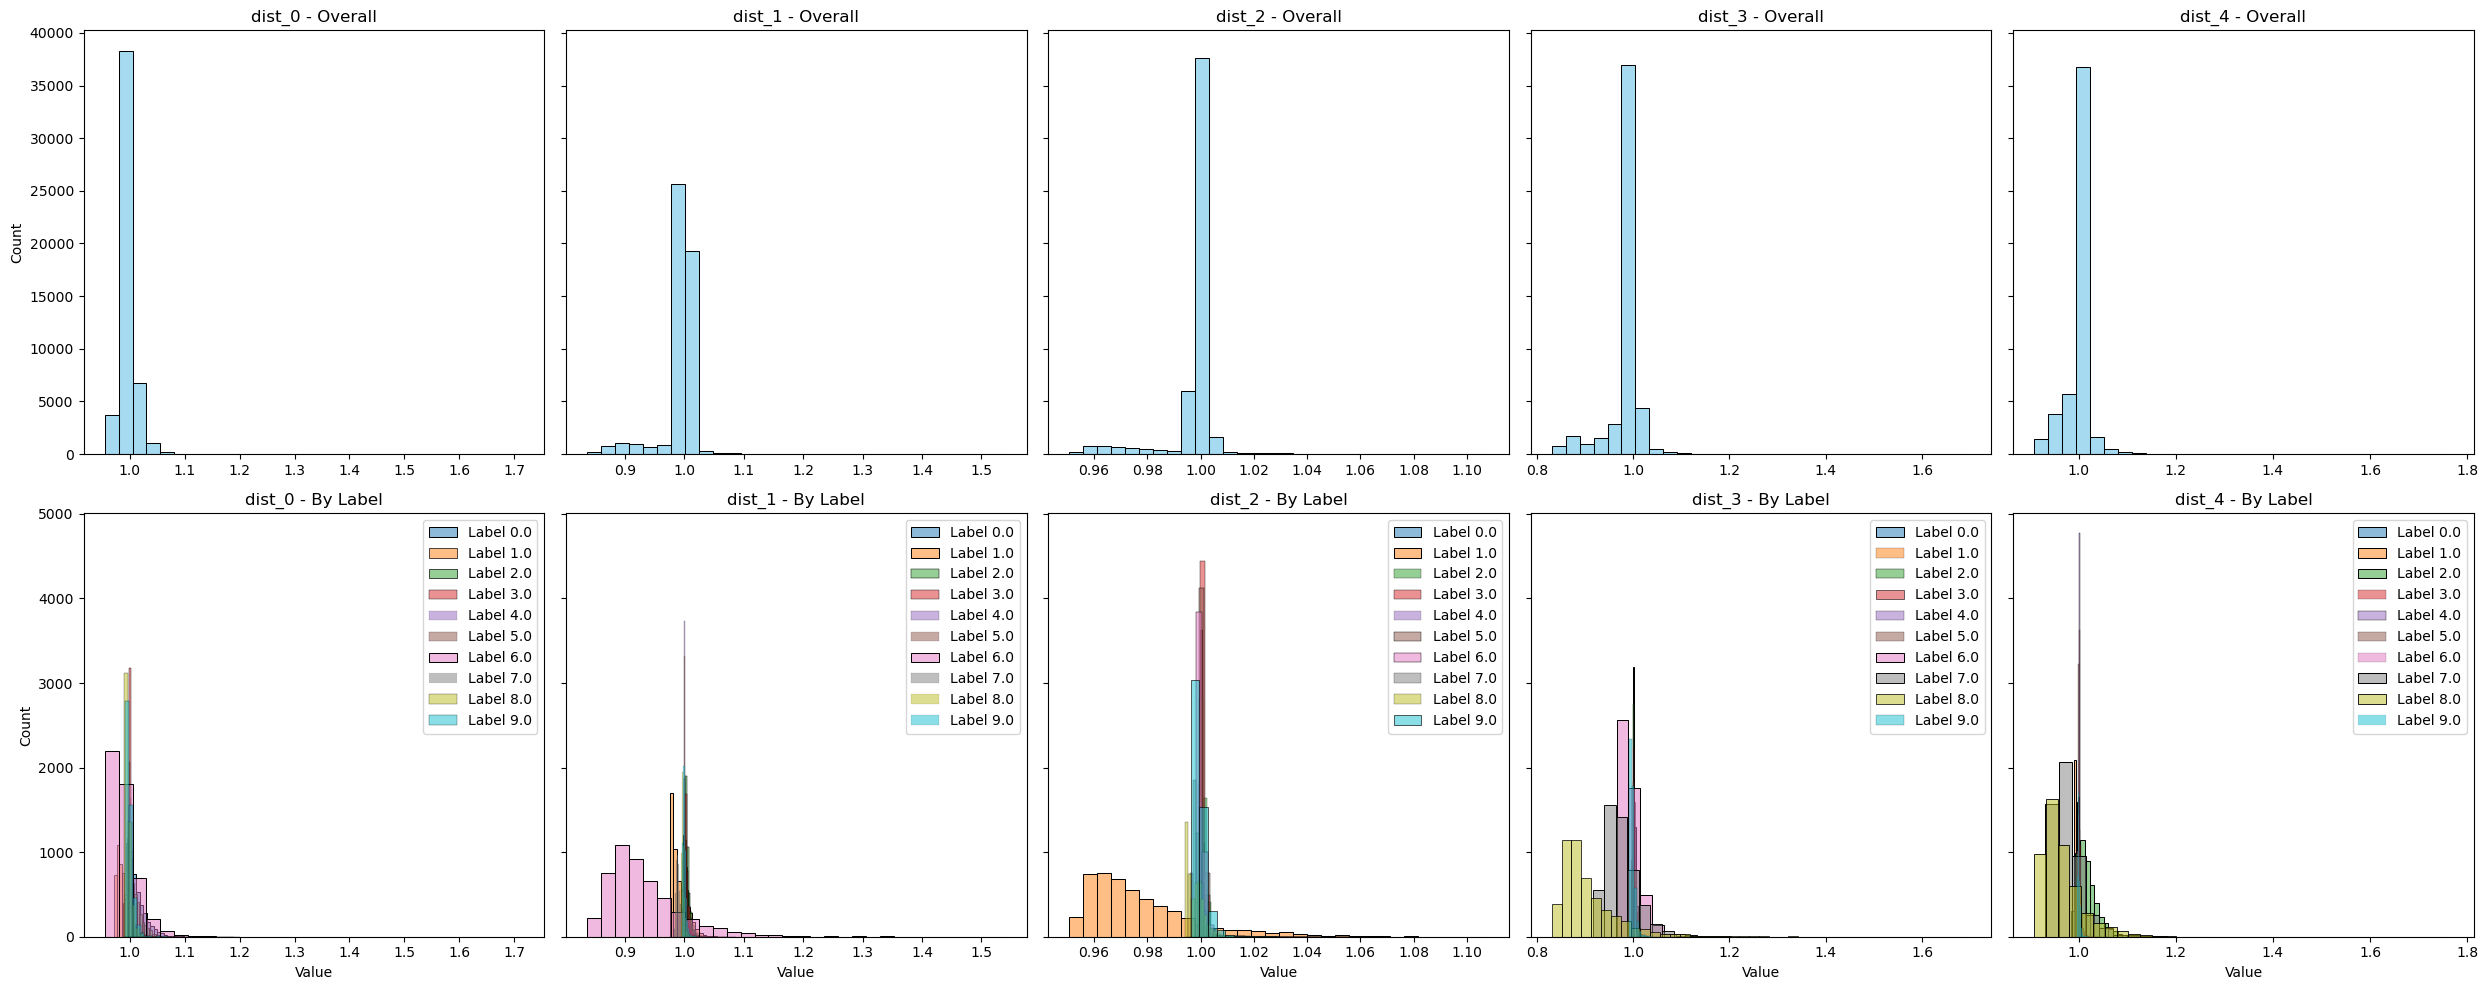

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,1.010285,0.017012,1.002995,0.005290,1.000516,0.000882,1.002261,0.003561,1.001045,0.003030
1.0,0.987738,0.012759,0.989747,0.013070,0.977955,0.020554,0.998344,0.002703,0.995765,0.005321
2.0,1.007056,0.013694,1.004934,0.004945,1.001069,0.001499,1.001122,0.001601,1.018191,0.023404
3.0,1.001510,0.002587,1.003155,0.003865,1.000693,0.001569,1.002035,0.002996,1.001290,0.002154
4.0,1.000462,0.001452,1.000543,0.000901,1.000582,0.001416,1.001005,0.002480,1.000763,0.002066
5.0,1.000630,0.001611,1.000548,0.000854,1.000665,0.001935,1.000822,0.001551,1.001117,0.002214
6.0,0.988672,0.025945,0.932500,0.065247,0.999874,0.001742,0.994415,0.022173,1.000659,0.002756
7.0,0.999700,0.000763,0.989989,0.005065,0.998641,0.001911,0.976710,0.039211,0.975234,0.032590
8.0,0.996545,0.006055,0.997811,0.002907,0.998174,0.003410,0.908488,0.065183,0.965758,0.044296


In [247]:
merged_df = process_merge(paths, 350, distance_metric = 'cosine', normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [248]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0074645129711209
Size of Union: 16344
Size of Intersection: 122


#### Bottom 10% Per Class

In [249]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0033621517771373678
Size of Union: 16656
Size of Intersection: 56


### Global Normalize Cosine Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


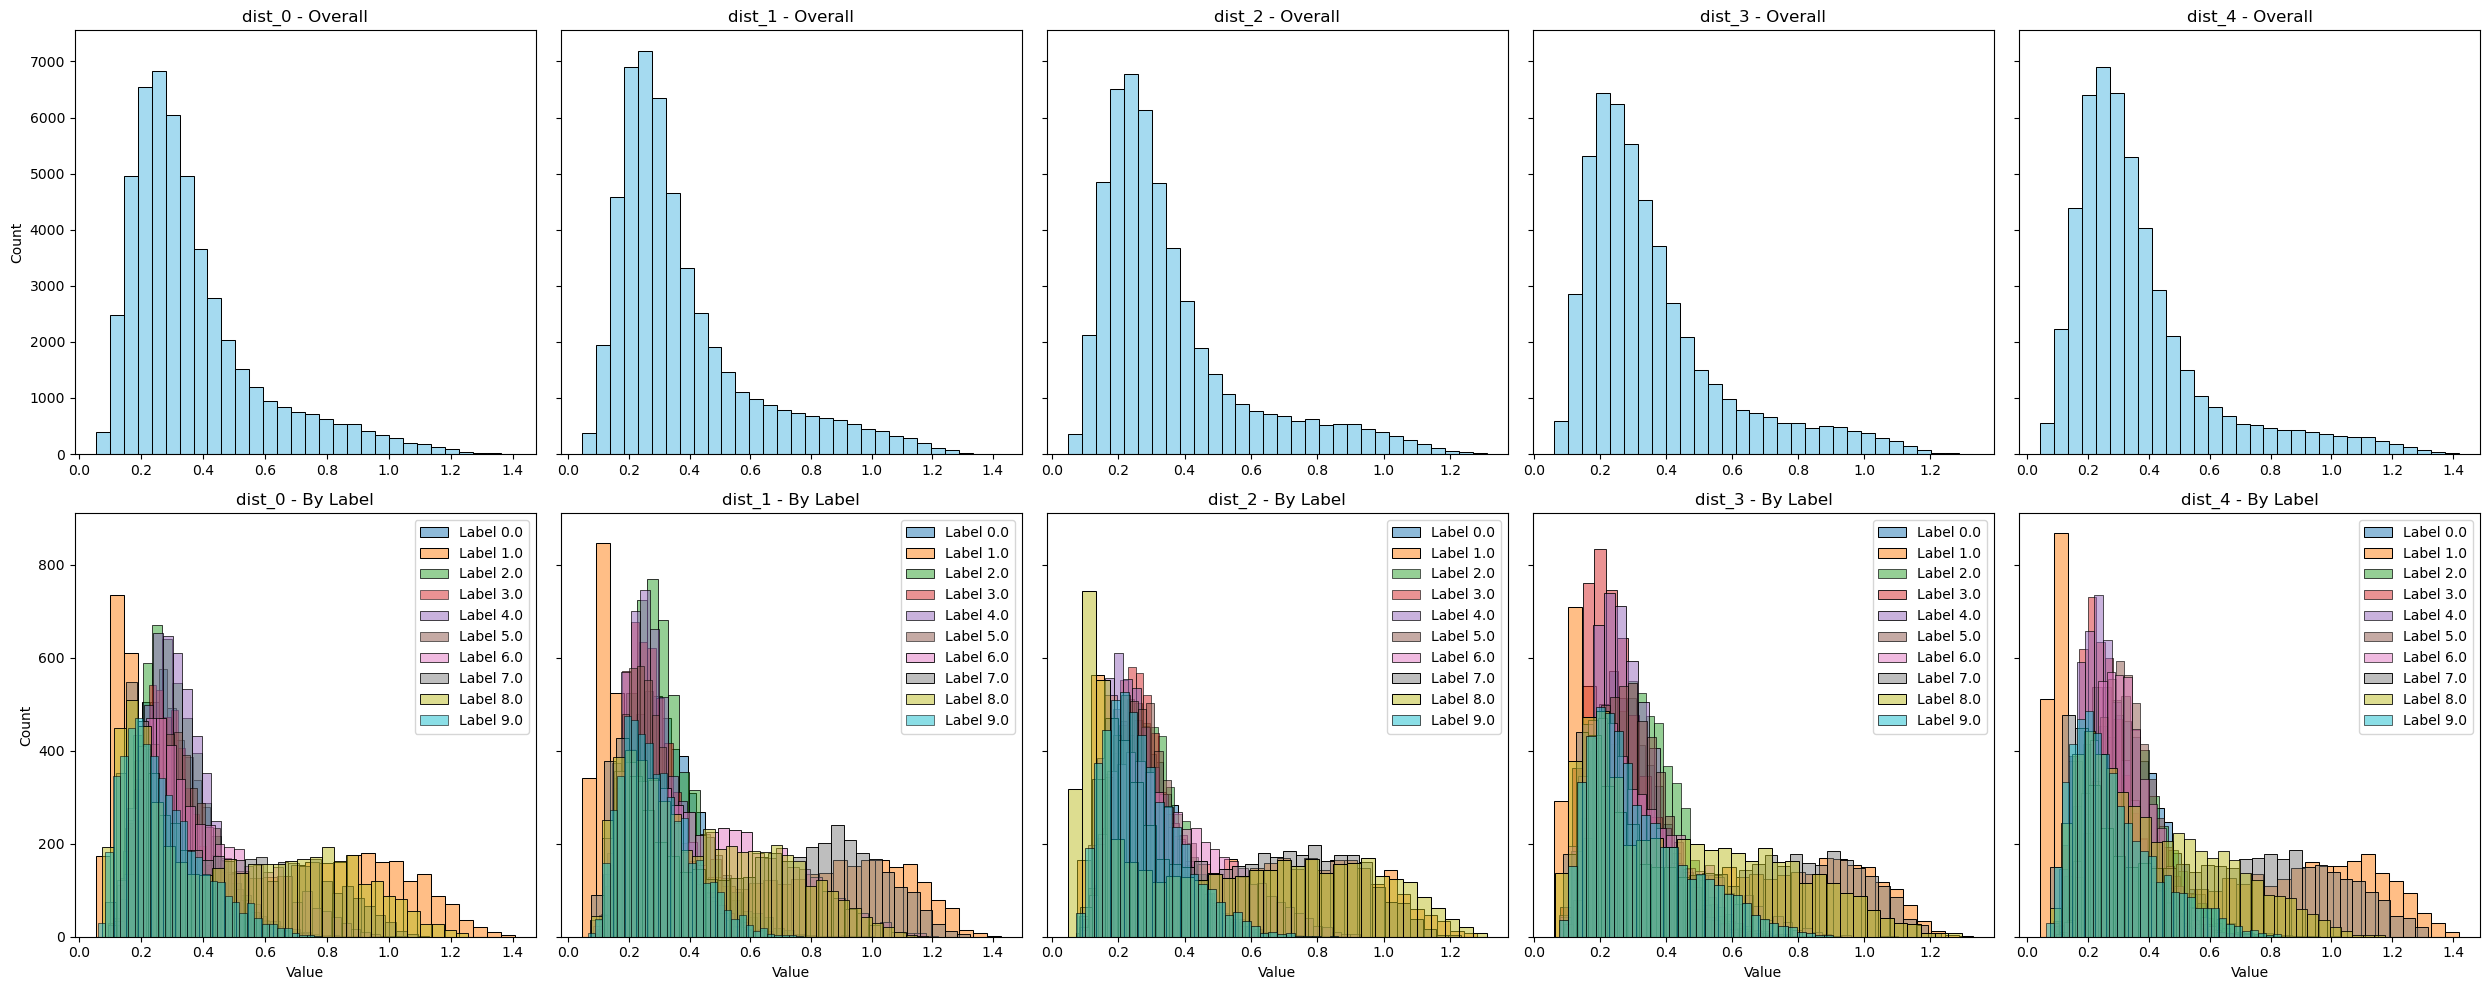

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.311475,0.111278,0.326400,0.110059,0.284814,0.093784,0.302853,0.110981,0.345123,0.112409
1.0,0.518528,0.360001,0.507099,0.385934,0.498384,0.316738,0.478702,0.338205,0.525249,0.410284
2.0,0.318103,0.111202,0.326866,0.113408,0.303091,0.099453,0.348875,0.102600,0.328429,0.121186
3.0,0.292121,0.092414,0.286530,0.100394,0.273013,0.082661,0.257548,0.101834,0.268738,0.097670
4.0,0.326717,0.102101,0.282085,0.099040,0.268273,0.103163,0.277817,0.095695,0.263061,0.093614
5.0,0.326473,0.111982,0.280052,0.098371,0.293172,0.104101,0.307276,0.102765,0.334050,0.093786
6.0,0.389145,0.181692,0.456144,0.236489,0.371214,0.166653,0.332140,0.164008,0.323719,0.100793
7.0,0.428726,0.248208,0.568971,0.329638,0.507493,0.288488,0.525082,0.314507,0.550429,0.337905
8.0,0.479391,0.301678,0.449593,0.242781,0.489171,0.351607,0.459227,0.281532,0.423559,0.226117


In [250]:
merged_df = process_merge(paths, 350, distance_metric = 'cosine', normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [251]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.017132065290705517
Size of Union: 14826
Size of Intersection: 254


In [252]:
torch.save(union_all, 'baseline_indexes/global_normed_cos_end_cifar')

#### Bottom 10% Per Class

In [253]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.005699810006333122
Size of Union: 15790
Size of Intersection: 90


## Start of Convergence (Epoch 75)

### Unnormalized L2 distance from class means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


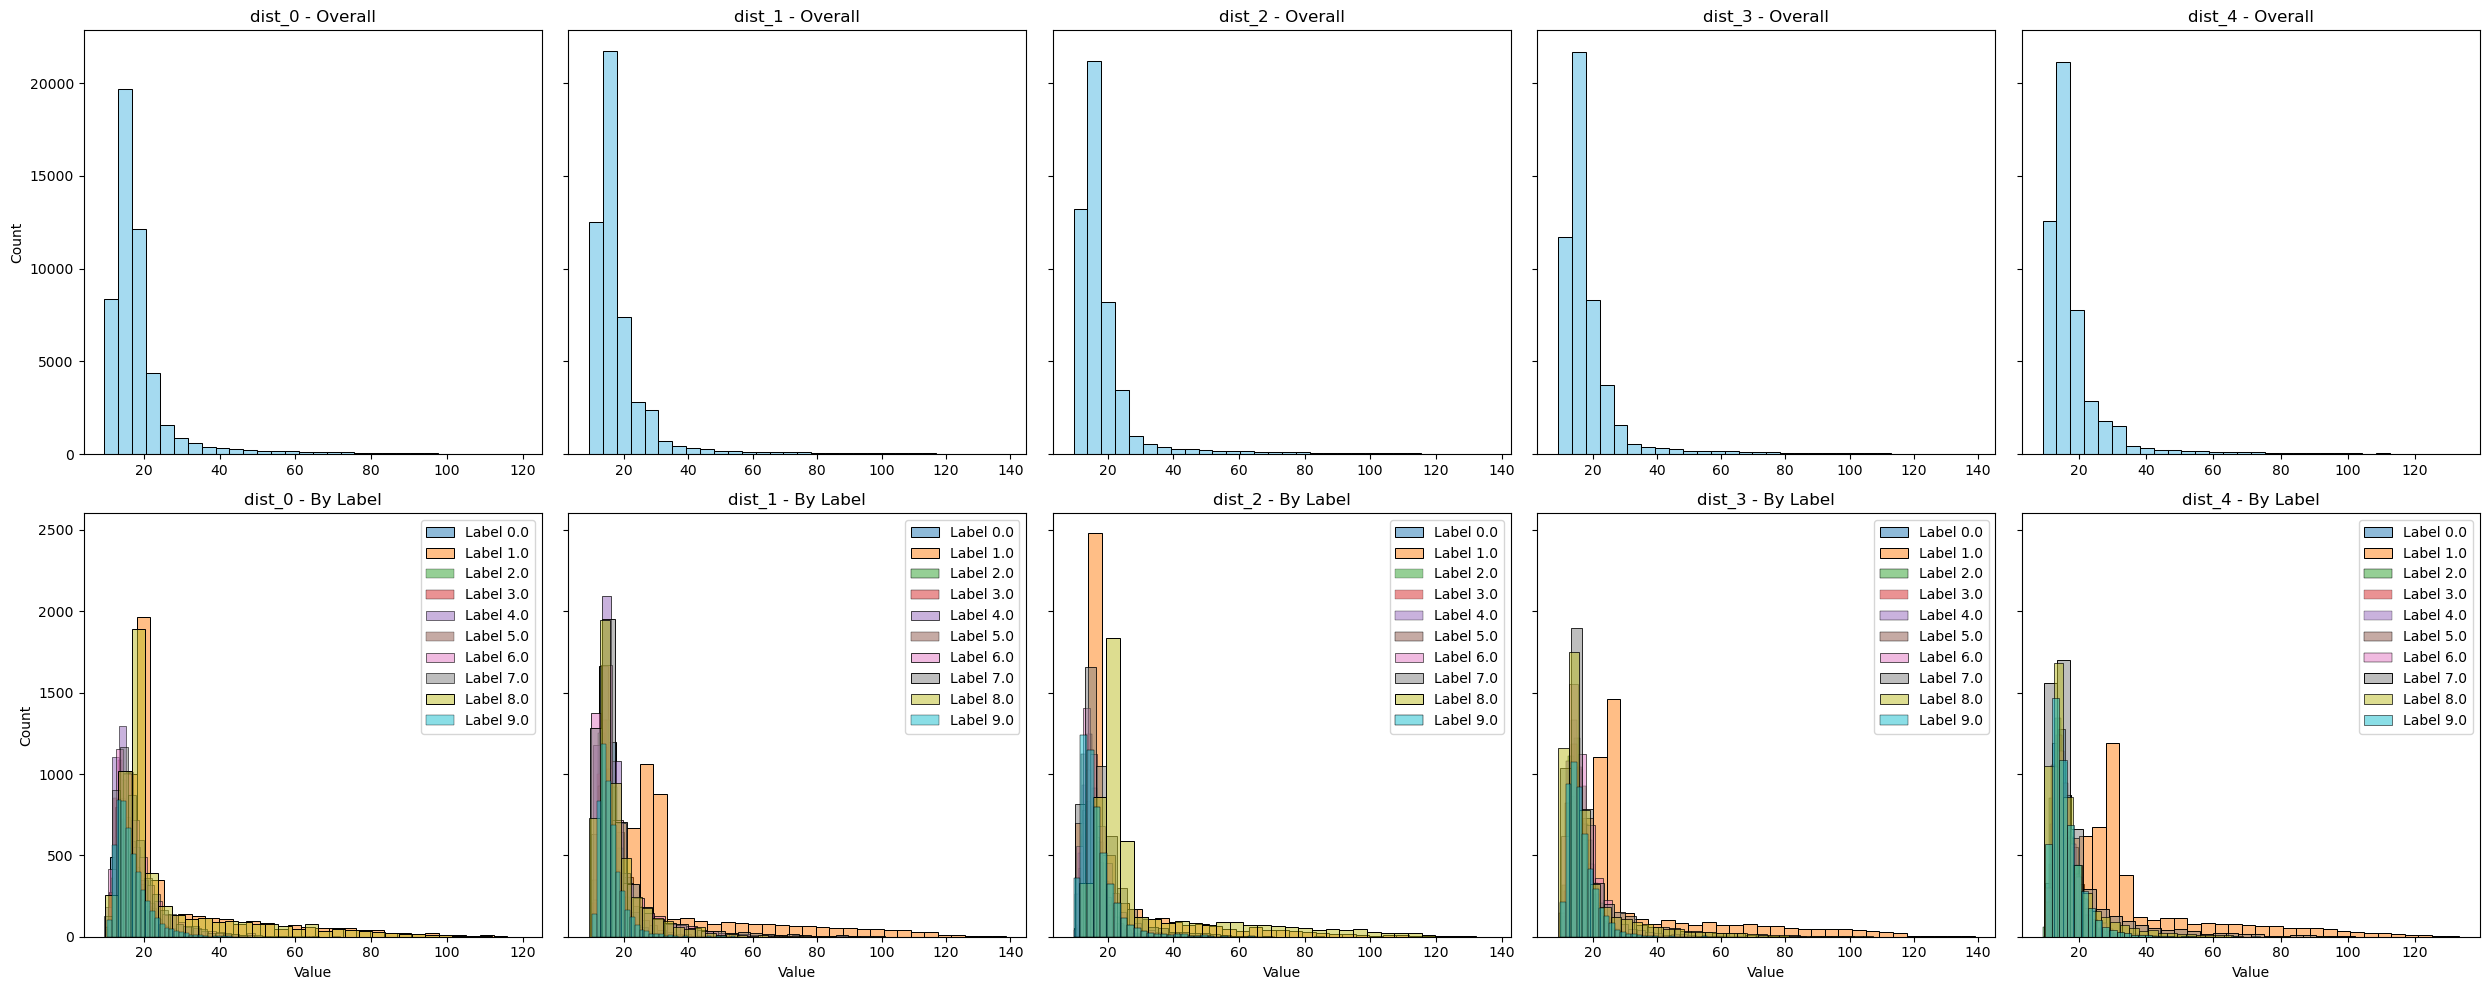

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,16.567730,4.215143,16.834816,5.403395,16.206593,3.697251,16.541960,3.661262,16.377718,4.360271
1.0,28.169209,18.666035,36.653061,24.009520,24.300896,18.263012,34.387280,23.357494,36.746628,22.133440
2.0,16.199921,3.599299,16.183153,3.984479,15.694613,3.039285,16.641310,4.073514,15.941450,4.147933
3.0,15.389358,2.927822,15.463411,3.228998,15.263995,2.886592,15.320582,2.718792,14.742741,2.561253
4.0,16.213146,4.244933,15.712458,3.666500,15.635434,3.623052,15.556111,3.343476,15.012999,2.753058
5.0,16.211952,3.440537,15.626305,3.032311,15.969323,4.100206,16.549030,4.743236,15.952261,3.777727
6.0,18.662701,7.170584,18.520582,10.033574,17.312252,6.080783,18.012976,7.180343,16.931616,5.147972
7.0,18.605764,6.915828,19.257330,11.614573,18.729263,7.938661,19.850945,11.792016,19.581806,12.225623
8.0,26.467953,17.728580,18.354683,8.666286,32.208035,22.666830,19.512472,12.941725,17.825974,8.648338


In [205]:
merged_df = process_merge(paths, 75)
graph_hists(merged_df)

#### Top 10% Per Class

In [206]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.03363936307559891
Size of Union: 13942
Size of Intersection: 469


#### Bottom 10% Per Class

In [207]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0016244126008006033
Size of Union: 17237
Size of Intersection: 28


#### Highest 10% STD Per Class

### Class Normalized L2 Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


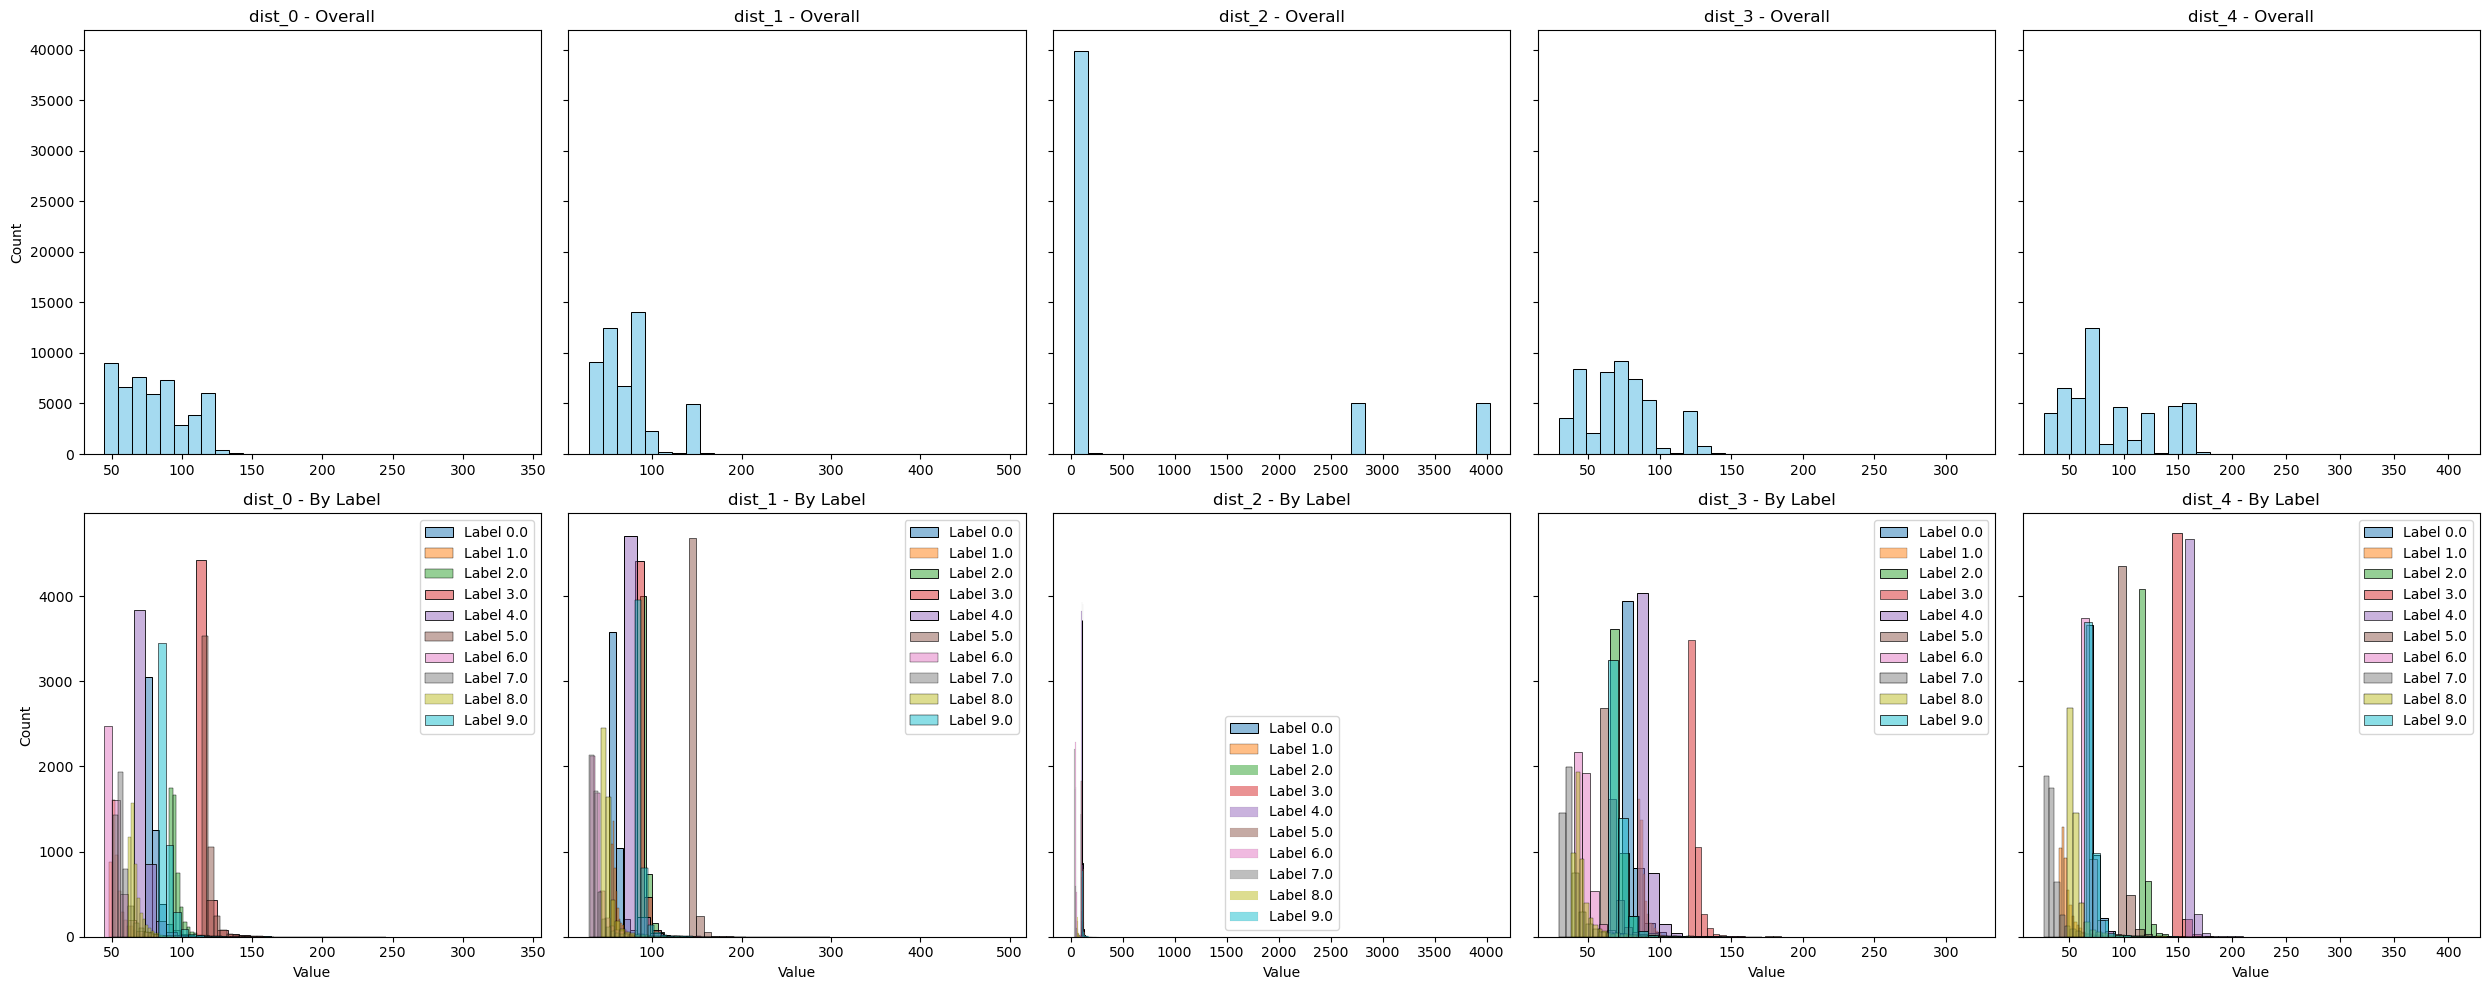

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,79.553116,6.929063,59.219467,9.226027,111.184860,5.465421,79.276169,7.071858,71.188095,8.423410
1.0,54.380642,5.556151,59.203133,5.120228,106.008224,3.713878,88.608536,3.913234,47.309208,5.868506
2.0,95.972145,5.409636,91.046318,6.940290,4025.015137,0.193108,71.025581,7.649066,118.371277,6.346037
3.0,113.893646,6.079218,86.160034,7.724201,2711.918701,0.306398,124.136261,5.013255,148.584106,5.748398
4.0,72.560509,8.582886,74.798355,9.419834,108.722588,7.053782,89.770256,7.520410,160.181503,5.749835
5.0,118.452484,4.894865,144.379562,5.479357,120.367302,6.181565,65.471703,9.005418,99.391243,6.716897
6.0,52.984955,8.890594,40.417210,11.856307,53.379955,9.636147,48.741764,10.139548,67.375992,8.463058
7.0,58.547211,8.511586,38.377312,11.876987,41.984600,10.860450,39.178829,10.502595,35.849010,11.981629
8.0,67.211792,5.022161,50.887665,10.084536,63.557243,5.027177,46.322395,9.372328,55.481094,9.671783


In [208]:
merged_df = process_merge(paths, 75, normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [209]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.014806880473820175
Size of Union: 15871
Size of Intersection: 235


#### Bottom 10% Per Class

In [210]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0020330942565087253
Size of Union: 17707
Size of Intersection: 36


### Global Normalized L2 Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


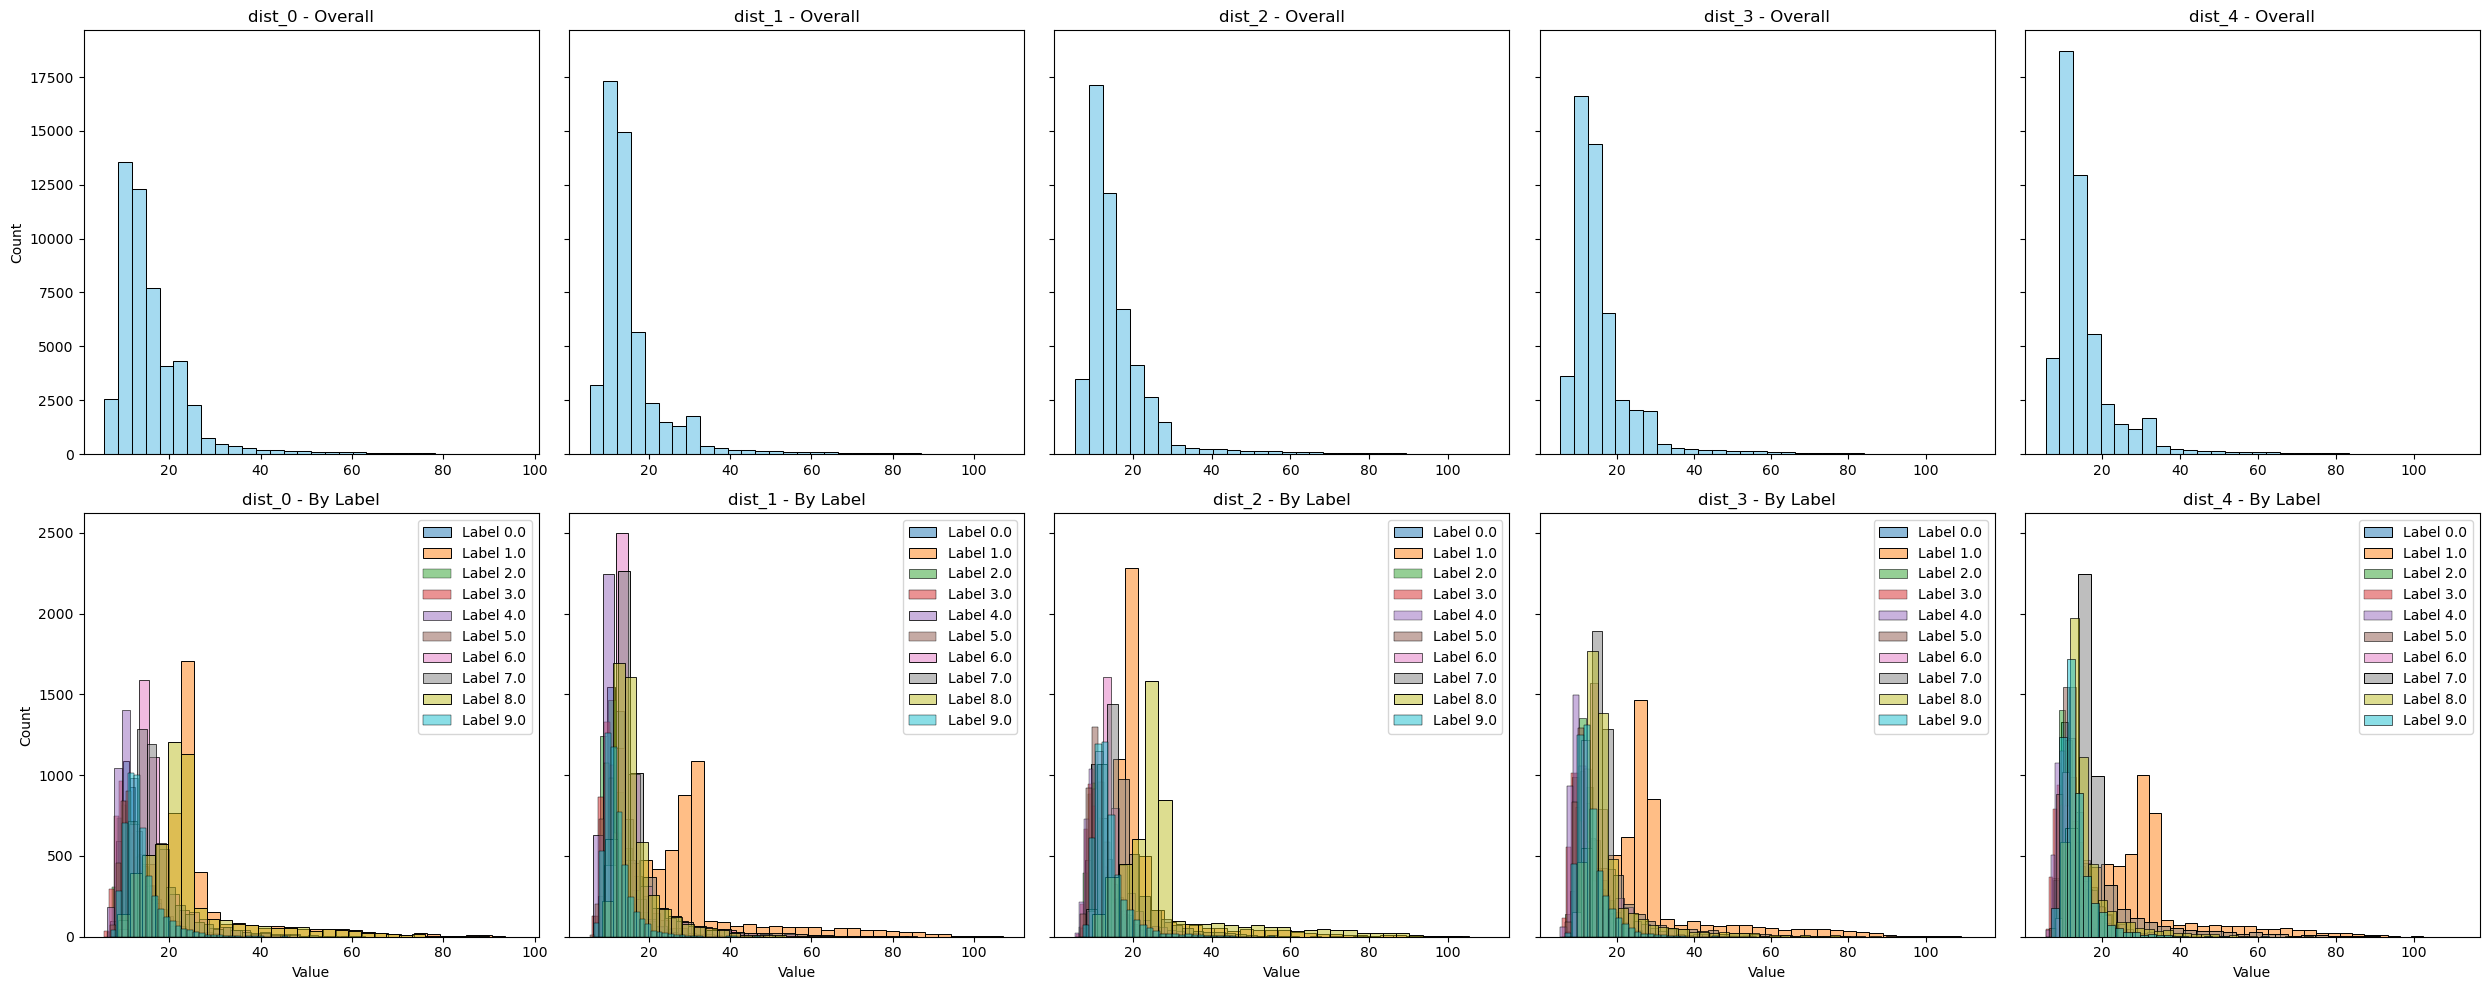

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,13.529994,4.522184,14.094144,5.114131,12.809703,3.866524,13.297068,3.835798,13.614703,4.607606
1.0,26.276194,12.306312,31.891953,16.050095,23.372992,12.187043,30.497881,15.204880,31.571835,14.626234
2.0,12.476824,3.919965,12.473110,4.232138,11.914615,3.464171,13.284082,4.340128,12.655661,4.523743
3.0,11.300230,3.306641,11.179324,3.239178,11.205266,3.231323,10.925236,3.194544,10.315095,2.948970
4.0,12.226588,4.128430,11.834479,3.910607,11.474789,3.657704,11.227339,3.470596,10.812215,3.039258
5.0,12.906898,3.831909,11.486322,3.294387,12.339943,4.054601,13.209730,4.587448,12.724345,4.050247
6.0,17.799248,6.566948,16.805231,8.394715,15.459998,5.623958,16.416849,6.510221,14.456791,4.935420
7.0,17.578007,6.766111,17.598837,9.120052,17.778238,7.236277,19.276085,9.186135,19.713434,10.377227
8.0,24.346914,11.855390,16.816105,6.947691,29.042974,15.112782,18.424330,9.566371,16.167049,7.071605


In [211]:
merged_df = process_merge(paths, 75, normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [212]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.03339980059820538
Size of Union: 14042
Size of Intersection: 469


#### Bottom 10% Per Class

In [213]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0025882352941176473
Size of Union: 17000
Size of Intersection: 44


### Unnormalized Cosine Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


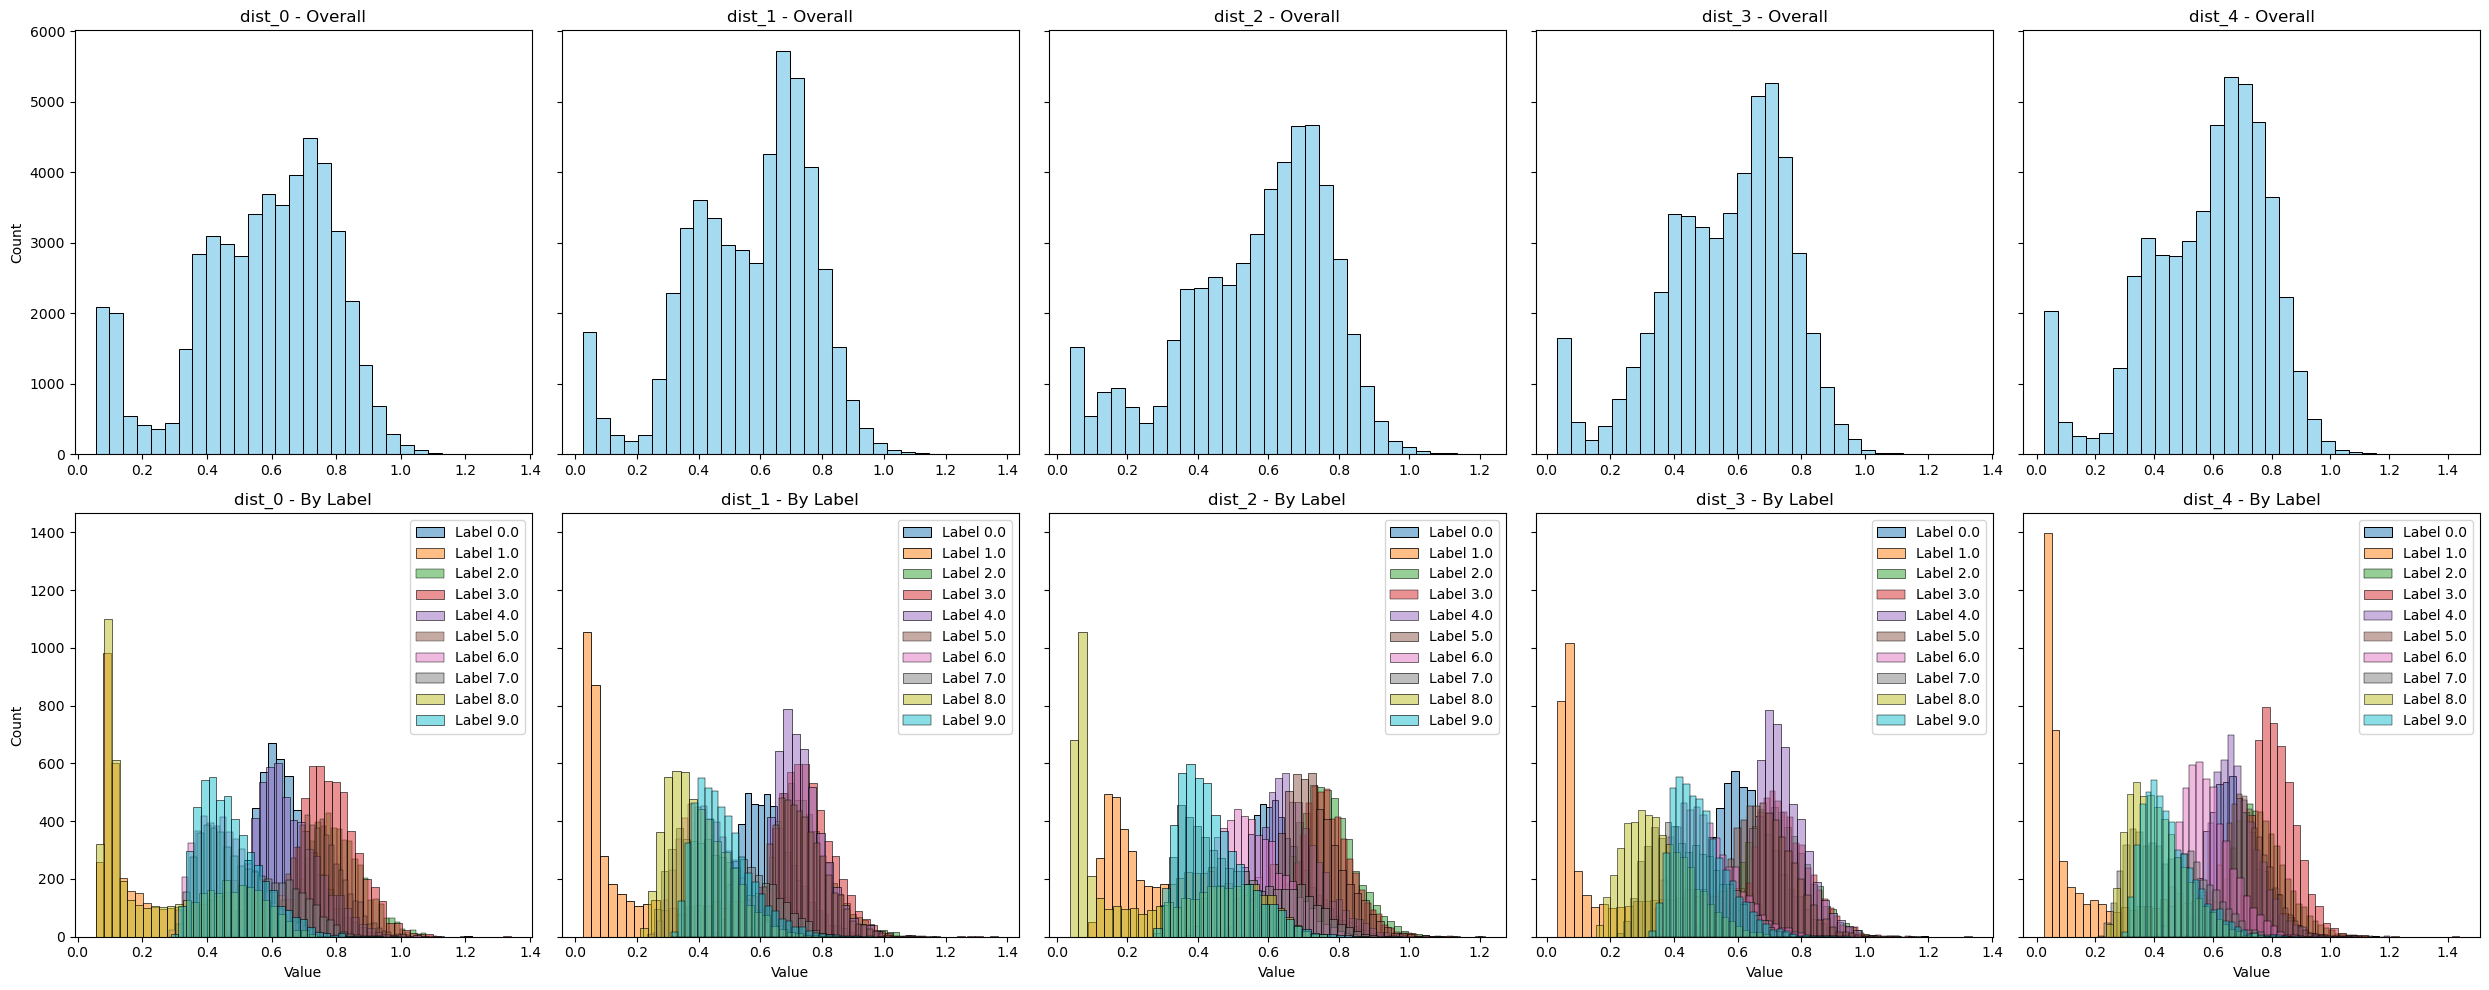

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.645340,0.084304,0.629682,0.087335,0.638889,0.082730,0.637645,0.092149,0.680411,0.084128
1.0,0.298120,0.202791,0.264410,0.233068,0.309799,0.144616,0.277038,0.220143,0.233013,0.214875
2.0,0.806264,0.080844,0.746554,0.086997,0.771319,0.077233,0.732942,0.090128,0.767723,0.084340
3.0,0.788829,0.080922,0.754593,0.081781,0.774268,0.067667,0.751742,0.078913,0.818085,0.067993
4.0,0.658196,0.092458,0.729293,0.077079,0.680274,0.078516,0.742410,0.072401,0.687009,0.074764
5.0,0.752088,0.073263,0.734225,0.081386,0.728991,0.080662,0.694675,0.084320,0.718775,0.073102
6.0,0.468110,0.097793,0.437490,0.089523,0.558768,0.090429,0.502326,0.094027,0.585923,0.081701
7.0,0.516742,0.124874,0.471631,0.127963,0.502359,0.137616,0.443647,0.111340,0.448431,0.118254
8.0,0.278290,0.191095,0.399508,0.100938,0.279827,0.210076,0.352597,0.103694,0.409968,0.094148


In [214]:
merged_df = process_merge(paths, 75, distance_metric = 'cosine', normalization = 'none')
graph_hists(merged_df)

#### Top 10% Per Class

In [215]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.024366673569407055
Size of Union: 14487
Size of Intersection: 353


#### Bottom 10% Per Class

In [216]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.012830793905372895
Size of Union: 14964
Size of Intersection: 192


### Class Normalized Cosine Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


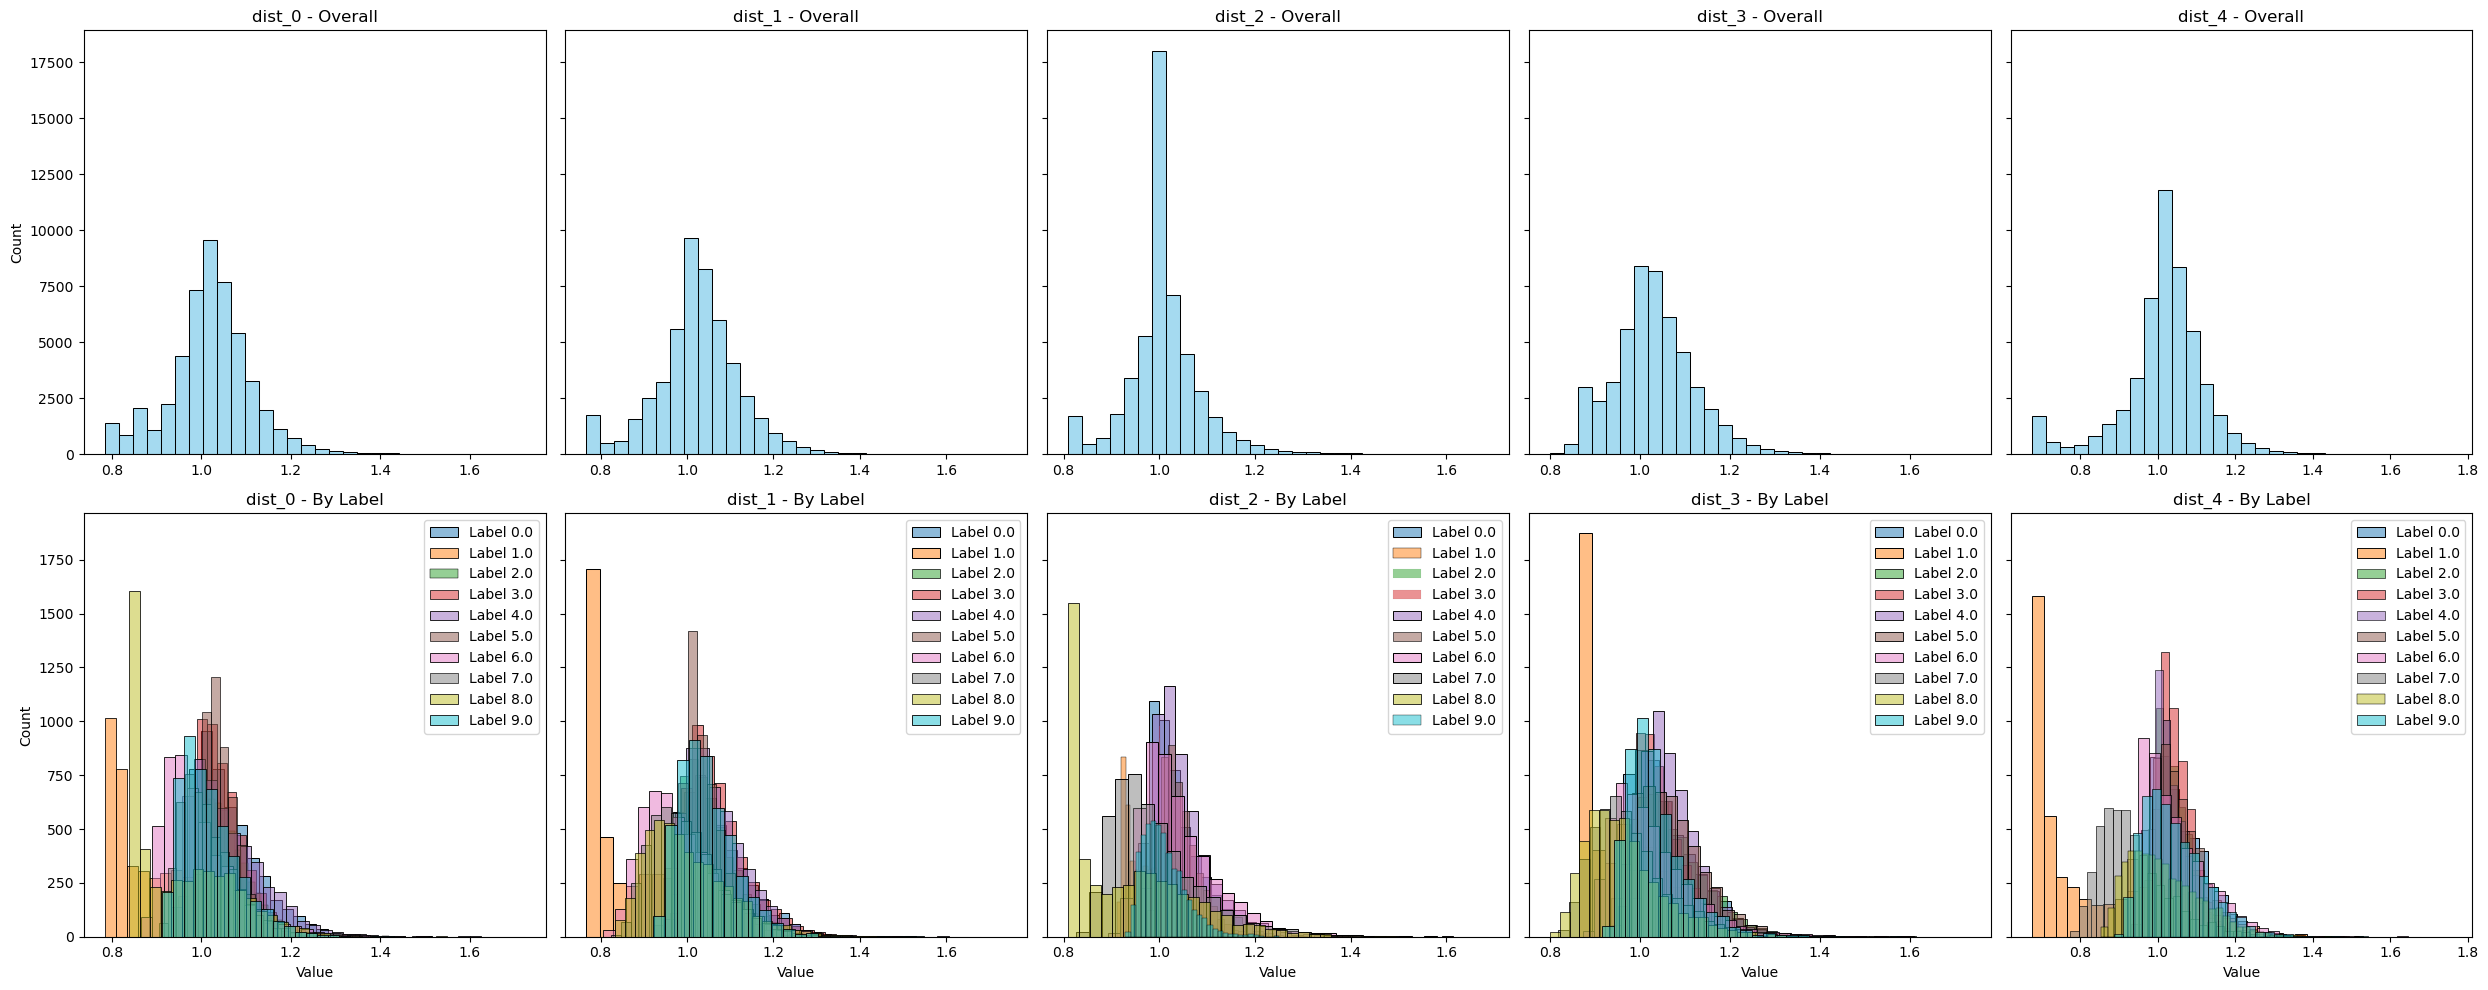

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,1.060495,0.072651,1.063246,0.079693,1.034660,0.055305,1.055890,0.074532,1.057840,0.076285
1.0,0.920285,0.120223,0.904762,0.130332,0.974367,0.047497,0.959120,0.089227,0.849678,0.173257
2.0,1.064475,0.057030,1.059657,0.063104,1.001565,0.001542,1.073475,0.077252,1.046669,0.048047
3.0,1.051993,0.052611,1.073195,0.067779,1.002235,0.002458,1.050785,0.051812,1.049809,0.041523
4.0,1.060245,0.082377,1.068346,0.071014,1.051969,0.063342,1.078634,0.061782,1.037927,0.044762
5.0,1.049687,0.043664,1.043721,0.047460,1.044731,0.042839,1.073752,0.079955,1.057559,0.060646
6.0,0.995604,0.084239,0.986085,0.095302,1.044173,0.084535,1.025489,0.090265,1.041391,0.085961
7.0,1.020138,0.072293,1.000631,0.086944,0.994136,0.097701,0.983162,0.091119,0.937872,0.091540
8.0,0.959639,0.110546,1.002403,0.097590,0.941130,0.123923,0.965602,0.088666,1.016202,0.092858


In [217]:
merged_df = process_merge(paths, 75, distance_metric = 'cosine', normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [218]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.006329502857494009
Size of Union: 16273
Size of Intersection: 103


#### Bottom 10% Per Class

In [219]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.005530698483718618
Size of Union: 16092
Size of Intersection: 89


### Global Normalize Cosine Distance From Class Means

torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])
torch.Size([50000, 515])


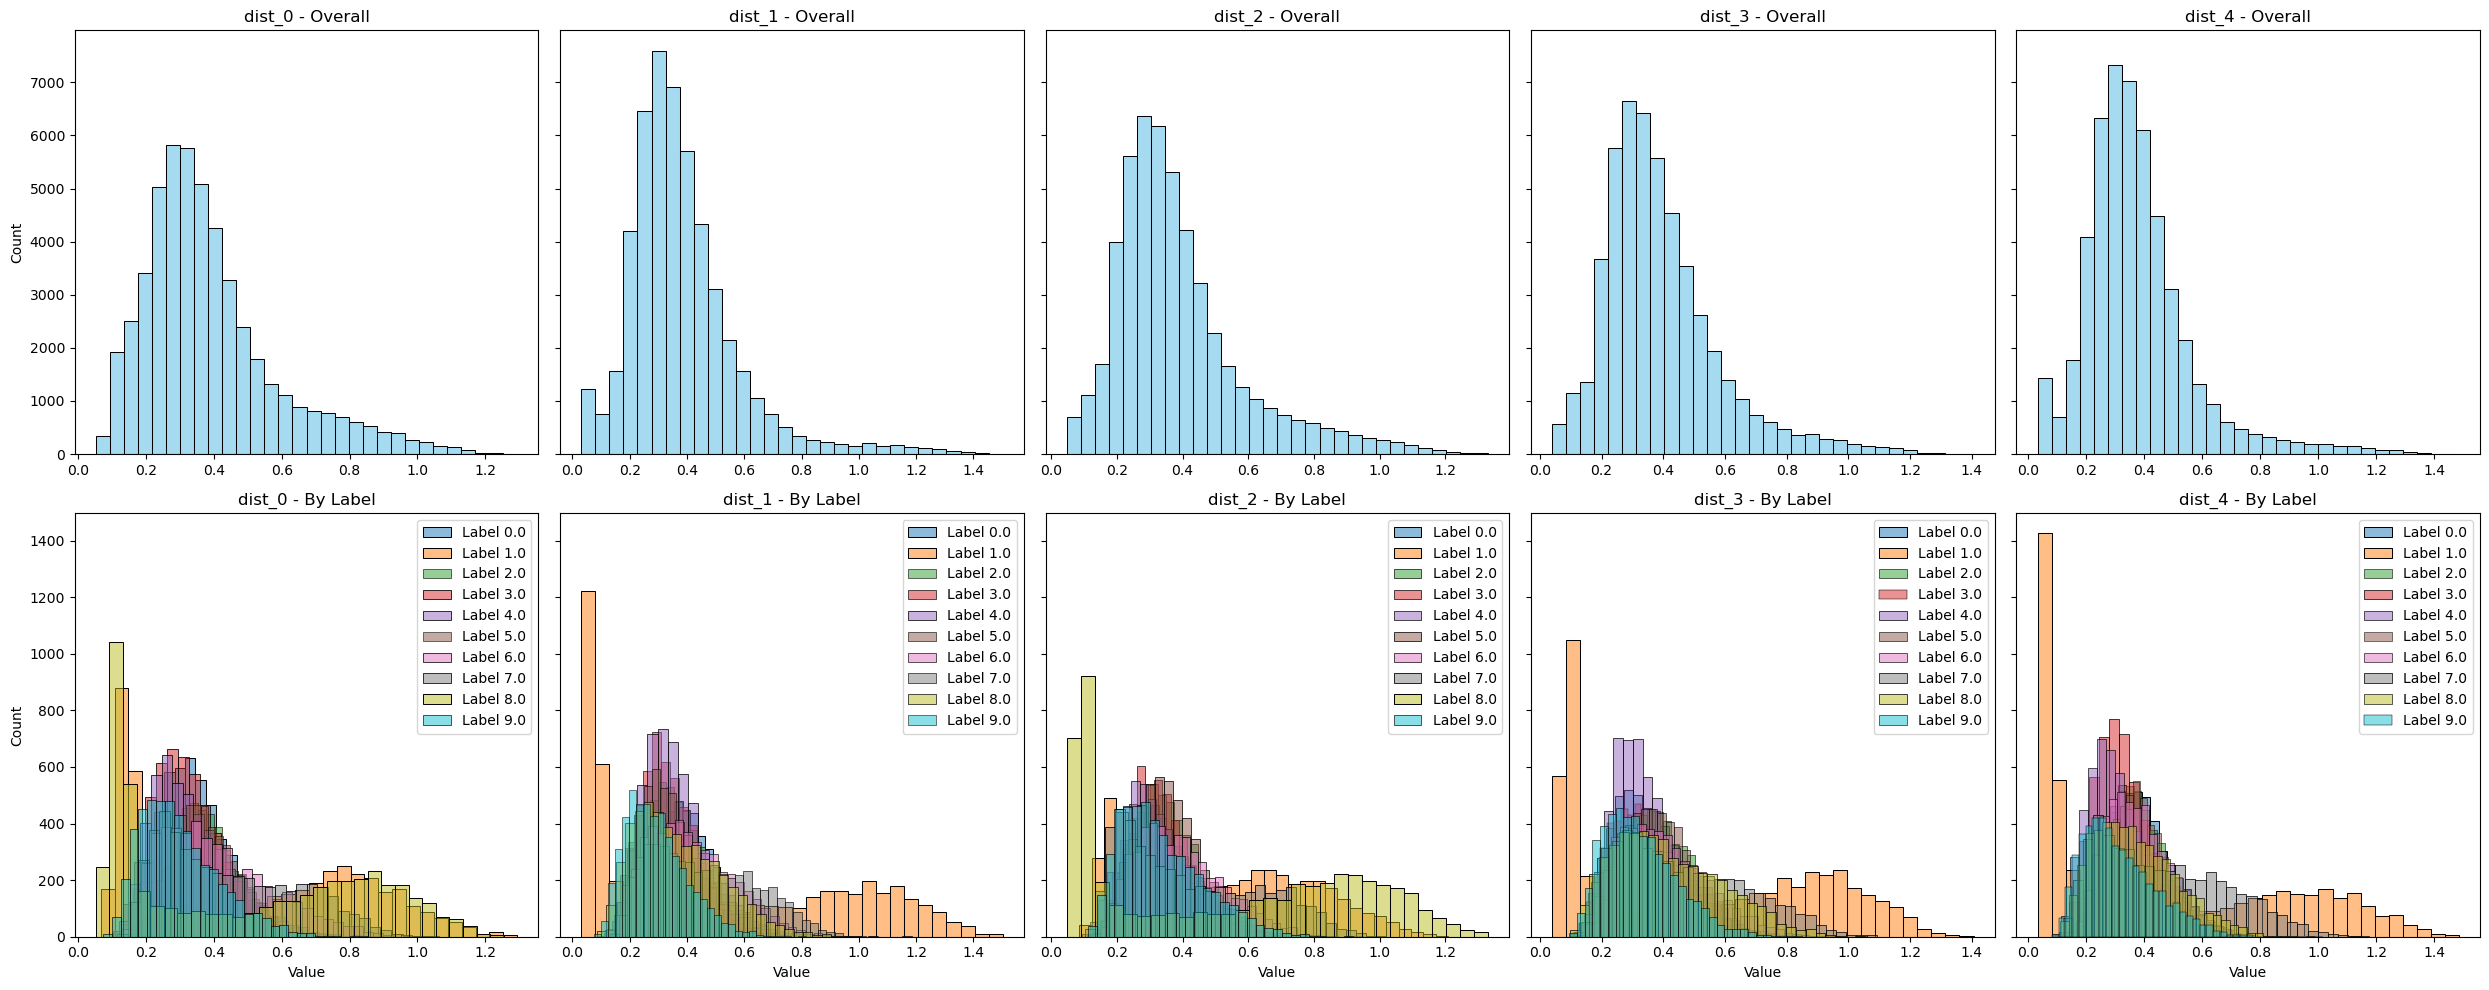

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.345690,0.103159,0.393034,0.109922,0.342029,0.102827,0.352193,0.114739,0.385669,0.106908
1.0,0.493710,0.325565,0.506429,0.437753,0.502770,0.268964,0.514026,0.387790,0.462494,0.419135
2.0,0.376650,0.104253,0.378888,0.113590,0.354797,0.098387,0.390221,0.115262,0.378747,0.107695
3.0,0.322781,0.100388,0.337760,0.098809,0.329601,0.091235,0.324252,0.103224,0.326162,0.097374
4.0,0.336012,0.119421,0.348751,0.103122,0.314820,0.103765,0.329597,0.096912,0.299883,0.097917
5.0,0.376654,0.094101,0.333900,0.101112,0.361420,0.101277,0.388522,0.111161,0.380814,0.092609
6.0,0.407593,0.161595,0.410529,0.148369,0.390710,0.129940,0.402184,0.139280,0.379048,0.110973
7.0,0.442058,0.194481,0.460282,0.178556,0.421747,0.207000,0.463132,0.199902,0.465790,0.213647
8.0,0.484891,0.348745,0.368721,0.150324,0.524701,0.390649,0.416318,0.172573,0.371029,0.140859


In [220]:
merged_df = process_merge(paths, 75, distance_metric = 'cosine', normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [221]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.021686746987951807
Size of Union: 14525
Size of Intersection: 315


#### Bottom 10% Per Class

In [222]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.009059873949579833
Size of Union: 15232
Size of Intersection: 138


# Grok

In [254]:
paths = [f'class_means_distance/grok_baseline_final_t_data_0.5_train_fraction_0.5_iter_{x}_max_epochs_400/train/train_raw_activations_epoch_' for x in list(range(5))]

In [255]:
all_idxs = []
epoch = 330
for i, path in enumerate(paths):
    dat = torch.load(path + str(epoch), map_location=torch.device('cpu'), weights_only=True)
    print(dat.shape)
    labels = dat[: , LABEL_INDEX]
    y_hats = dat[: , Y_HAT_INDEX]
    idx = dat[: , IDX_INDEX]
    all_idxs.append(idx)
    activations = dat[: , :-3]

intersection_all = reduce(np.intersect1d, all_idxs)
union_all = reduce(np.union1d, all_idxs)
len(intersection_all) == len(union_all)

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


True

## End of Convergence (Epoch 330)

### Unnormalized L2 distance from class means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


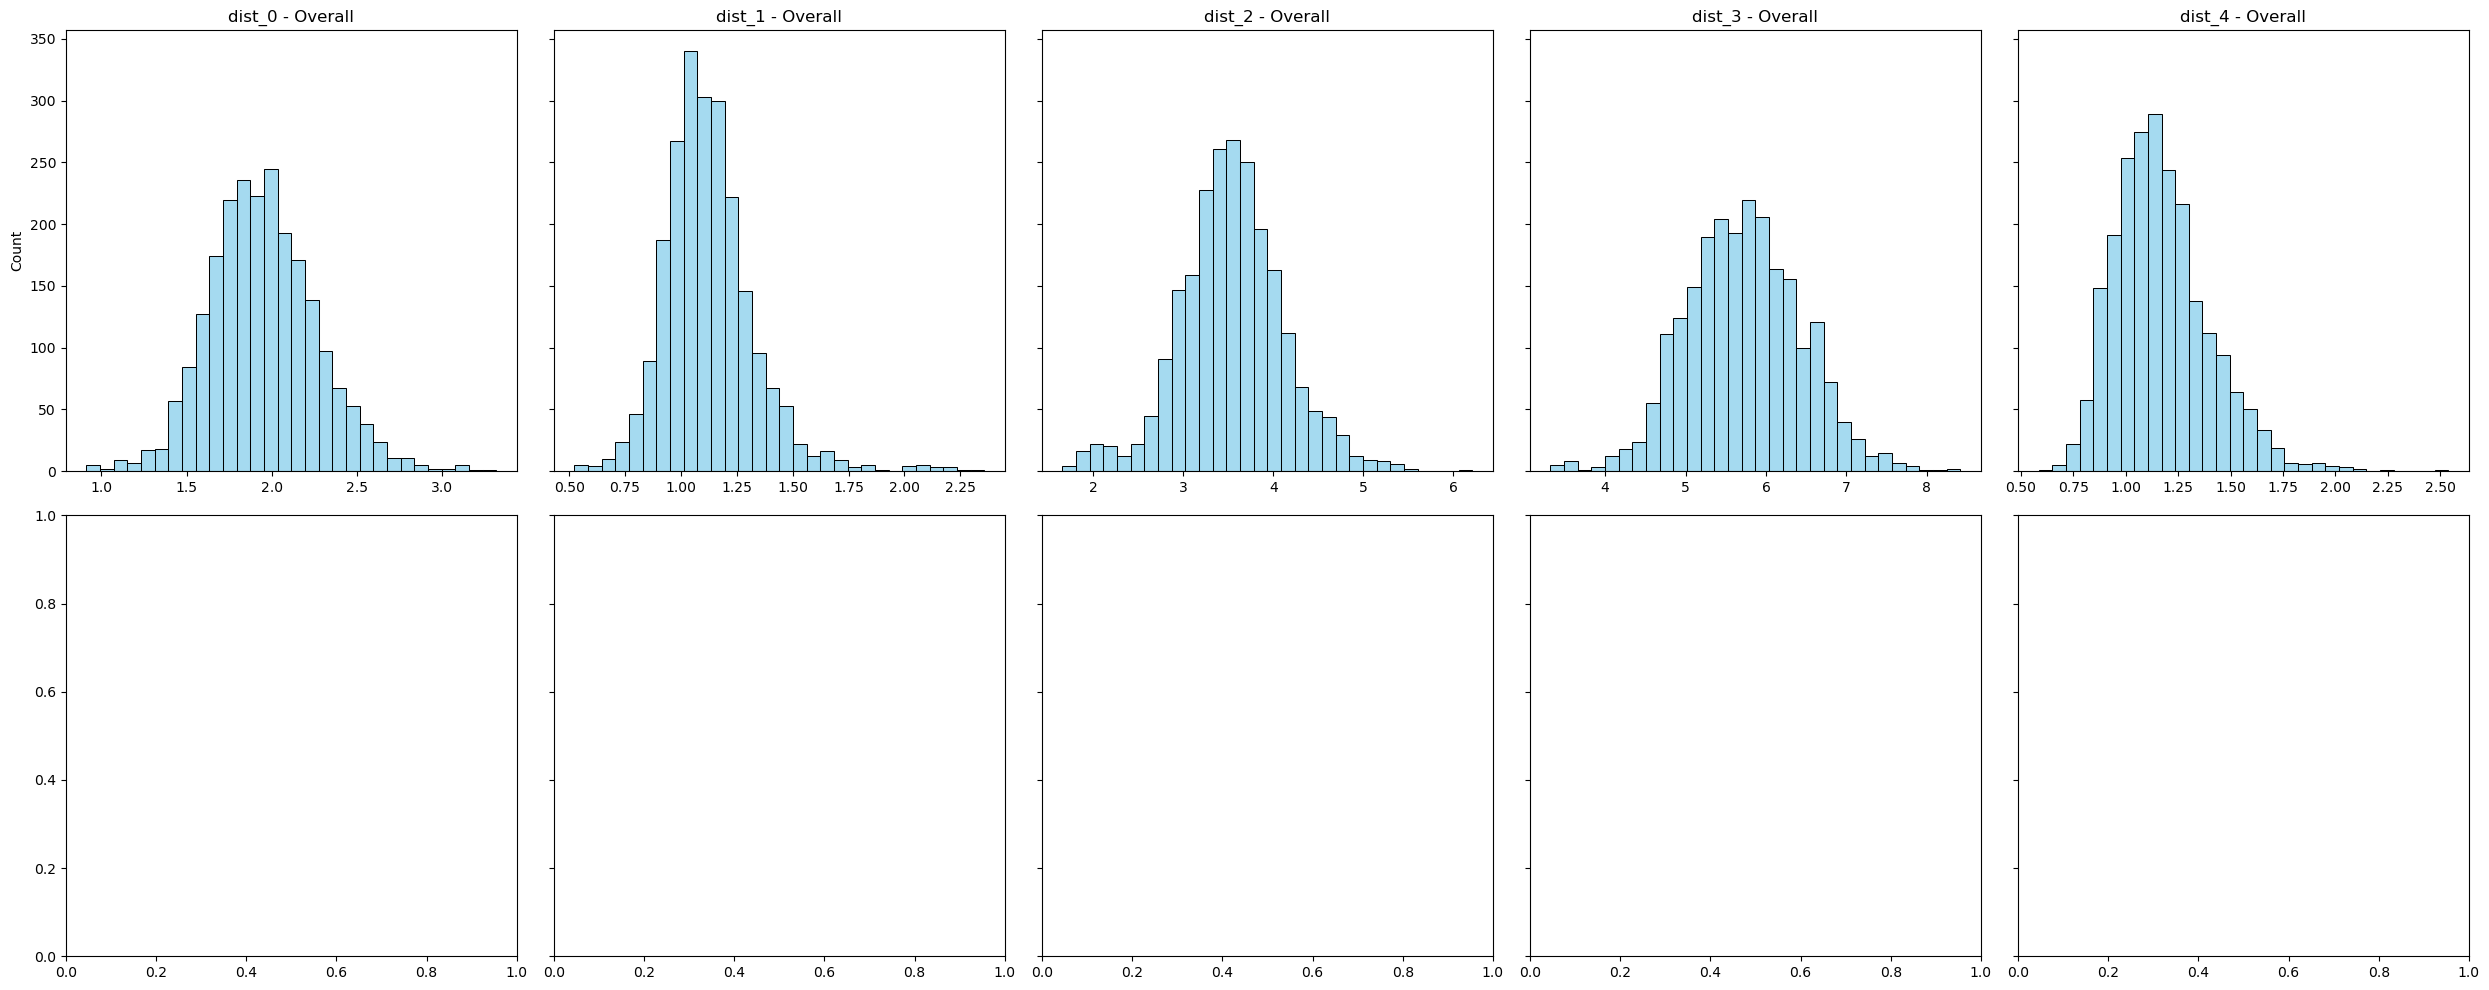

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,1.354758,0.236887,0.761514,0.101123,2.059807,0.170782,4.557494,0.749687,1.402403,0.233612
1.0,1.895216,0.195626,1.120106,0.139796,3.596804,0.394211,5.842323,0.454853,1.168992,0.181342
2.0,1.834604,0.262945,1.255578,0.172916,3.738688,0.434448,5.628325,0.578296,1.252550,0.199483
3.0,1.978810,0.331396,1.182723,0.189569,3.636690,0.417512,5.644967,0.452992,1.131465,0.215640
4.0,1.862740,0.272324,1.102456,0.164129,3.496831,0.517947,5.777881,0.450039,1.088037,0.238046
...,...,...,...,...,...,...,...,...,...,...
62.0,1.914990,0.297747,1.156940,0.197099,3.515404,0.528873,5.912173,0.663184,1.224368,0.250396
63.0,2.040124,0.283980,1.160328,0.190549,3.519678,0.582032,5.673056,0.599059,1.103349,0.208673
64.0,2.070037,0.296463,1.097770,0.167193,3.508422,0.521606,5.680016,0.322849,1.103218,0.270029


In [256]:
merged_df = process_merge(paths, 330)
graph_hists(merged_df)

#### Top 10% Per Class

In [257]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.004162330905306972
Size of Union: 961
Size of Intersection: 4


In [258]:
torch.save(union_all, 'baseline_indexes/unnormed_l2_end_grok')

#### Bottom 10% Per Class

In [259]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 980
Size of Intersection: 0


#### Highest 10% STD Per Class

### Class Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


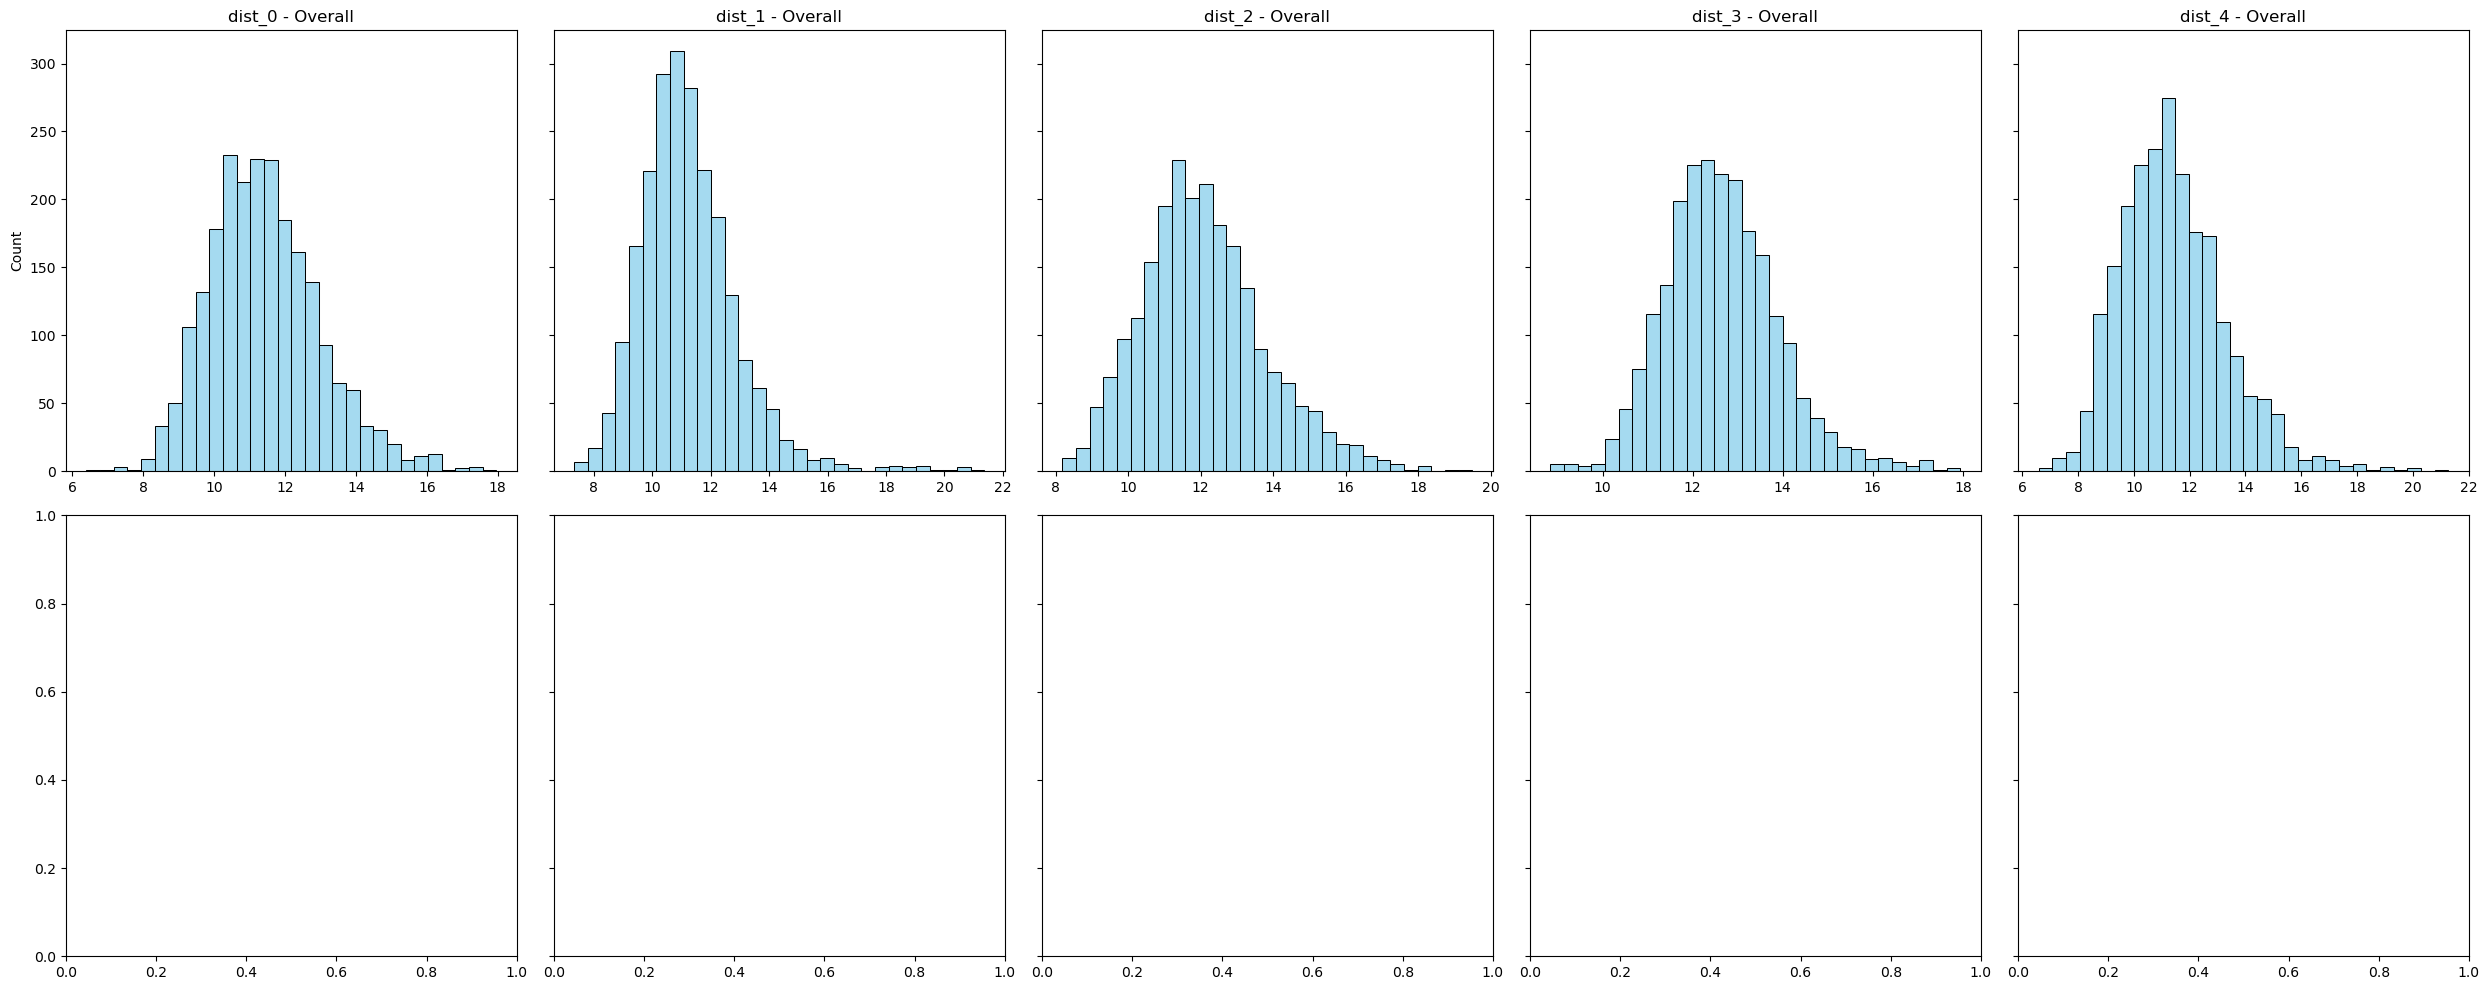

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,12.047235,1.929832,11.880303,1.342644,15.434938,1.182514,13.835903,1.871574,11.461819,1.847298
1.0,11.469067,1.150026,11.275802,1.225202,11.936685,1.313337,12.603621,0.805137,11.375673,1.854781
2.0,11.414479,1.610989,11.178376,1.316934,11.920142,1.390144,12.759028,1.088372,11.349439,1.725131
3.0,11.375799,1.707451,11.224955,1.516828,12.004196,1.456780,12.825969,0.715252,11.484487,1.914555
4.0,11.479464,1.565733,11.225629,1.628608,12.008071,1.750314,12.689142,0.766634,11.469922,2.147485
...,...,...,...,...,...,...,...,...,...,...
62.0,11.403905,1.554909,11.188100,1.700373,11.981858,1.772703,12.500225,1.212057,11.269724,2.217164
63.0,11.421127,1.472947,11.253209,1.540811,11.990281,1.837361,12.769237,0.864873,11.554011,1.724260
64.0,11.386174,1.562412,11.266582,1.552448,11.947505,1.719030,12.678420,0.687878,11.319889,2.473030


In [260]:
merged_df = process_merge(paths, 330, normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [261]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002176278563656148
Size of Union: 919
Size of Intersection: 2


#### Bottom 10% Per Class

In [262]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 986
Size of Intersection: 0


### Global Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


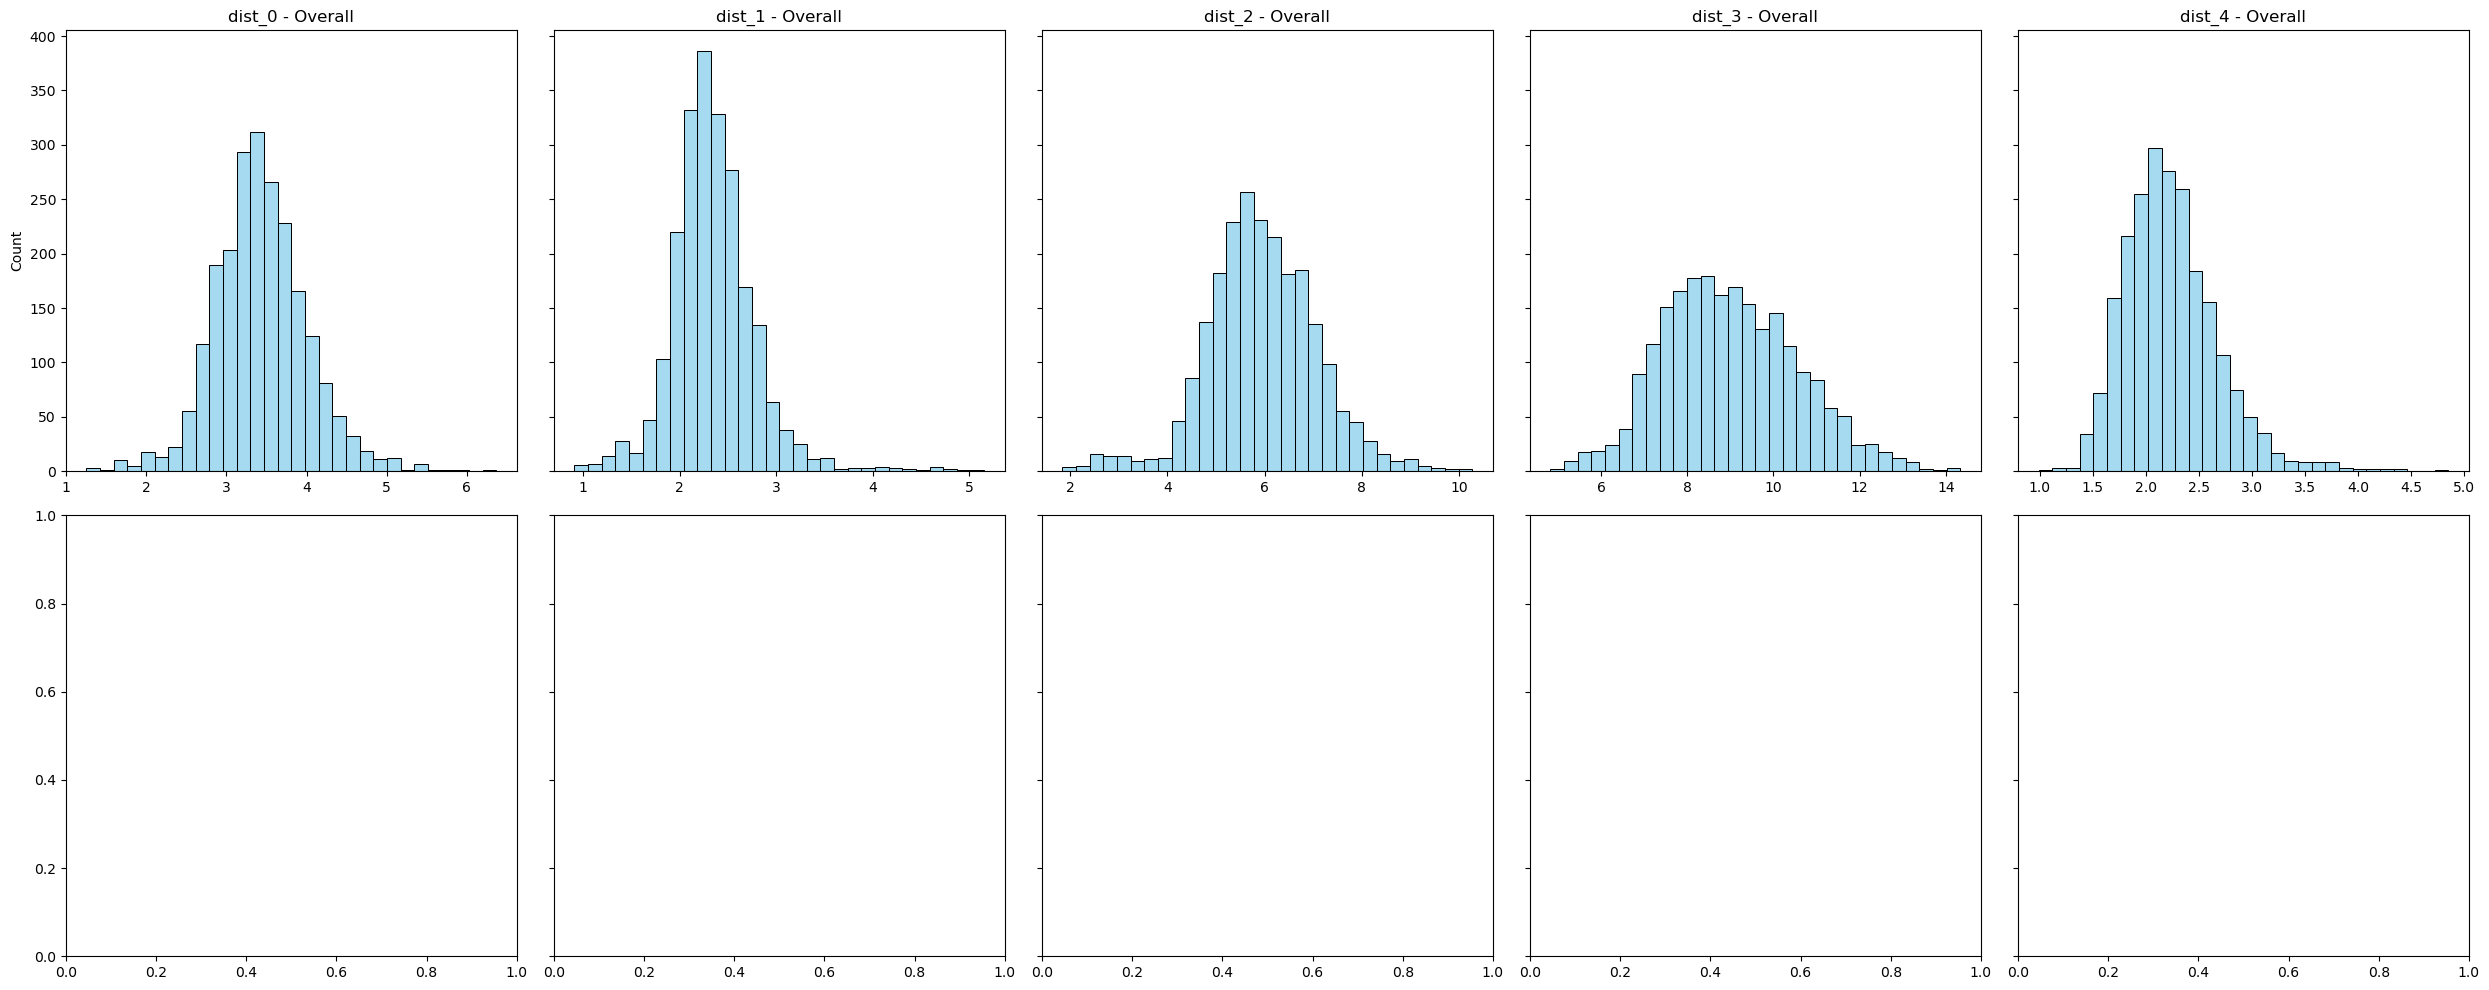

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,2.159839,0.429361,1.356140,0.192730,2.884377,0.478592,6.580201,1.076858,2.426725,0.452569
1.0,3.300898,0.355935,2.308748,0.296726,6.115218,0.763298,9.164880,1.483928,2.256826,0.381149
2.0,3.262657,0.540819,2.537683,0.332346,6.311502,0.937514,8.711544,1.610490,2.486593,0.387600
3.0,3.466848,0.577551,2.497192,0.352286,6.089009,0.857957,8.787532,1.390114,2.219469,0.398892
4.0,3.243983,0.460146,2.345471,0.383605,5.901328,1.007511,8.942661,1.466472,2.056860,0.462897
...,...,...,...,...,...,...,...,...,...,...
62.0,3.409930,0.564271,2.379163,0.387731,5.891612,1.068489,9.402546,1.349891,2.385188,0.533265
63.0,3.654345,0.464462,2.405883,0.371149,5.979243,0.977851,8.788508,1.419480,2.098809,0.350522
64.0,3.695256,0.522484,2.394214,0.388740,5.884381,0.989414,8.860794,1.525913,2.132919,0.481589


In [263]:
merged_df = process_merge(paths, 330, normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [264]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0032397408207343412
Size of Union: 926
Size of Intersection: 3


In [265]:
torch.save(union_all, 'baseline_indexes/global_normed_l2_end_grok')

#### Bottom 10% Per Class

In [266]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 989
Size of Intersection: 0


### Unnormalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


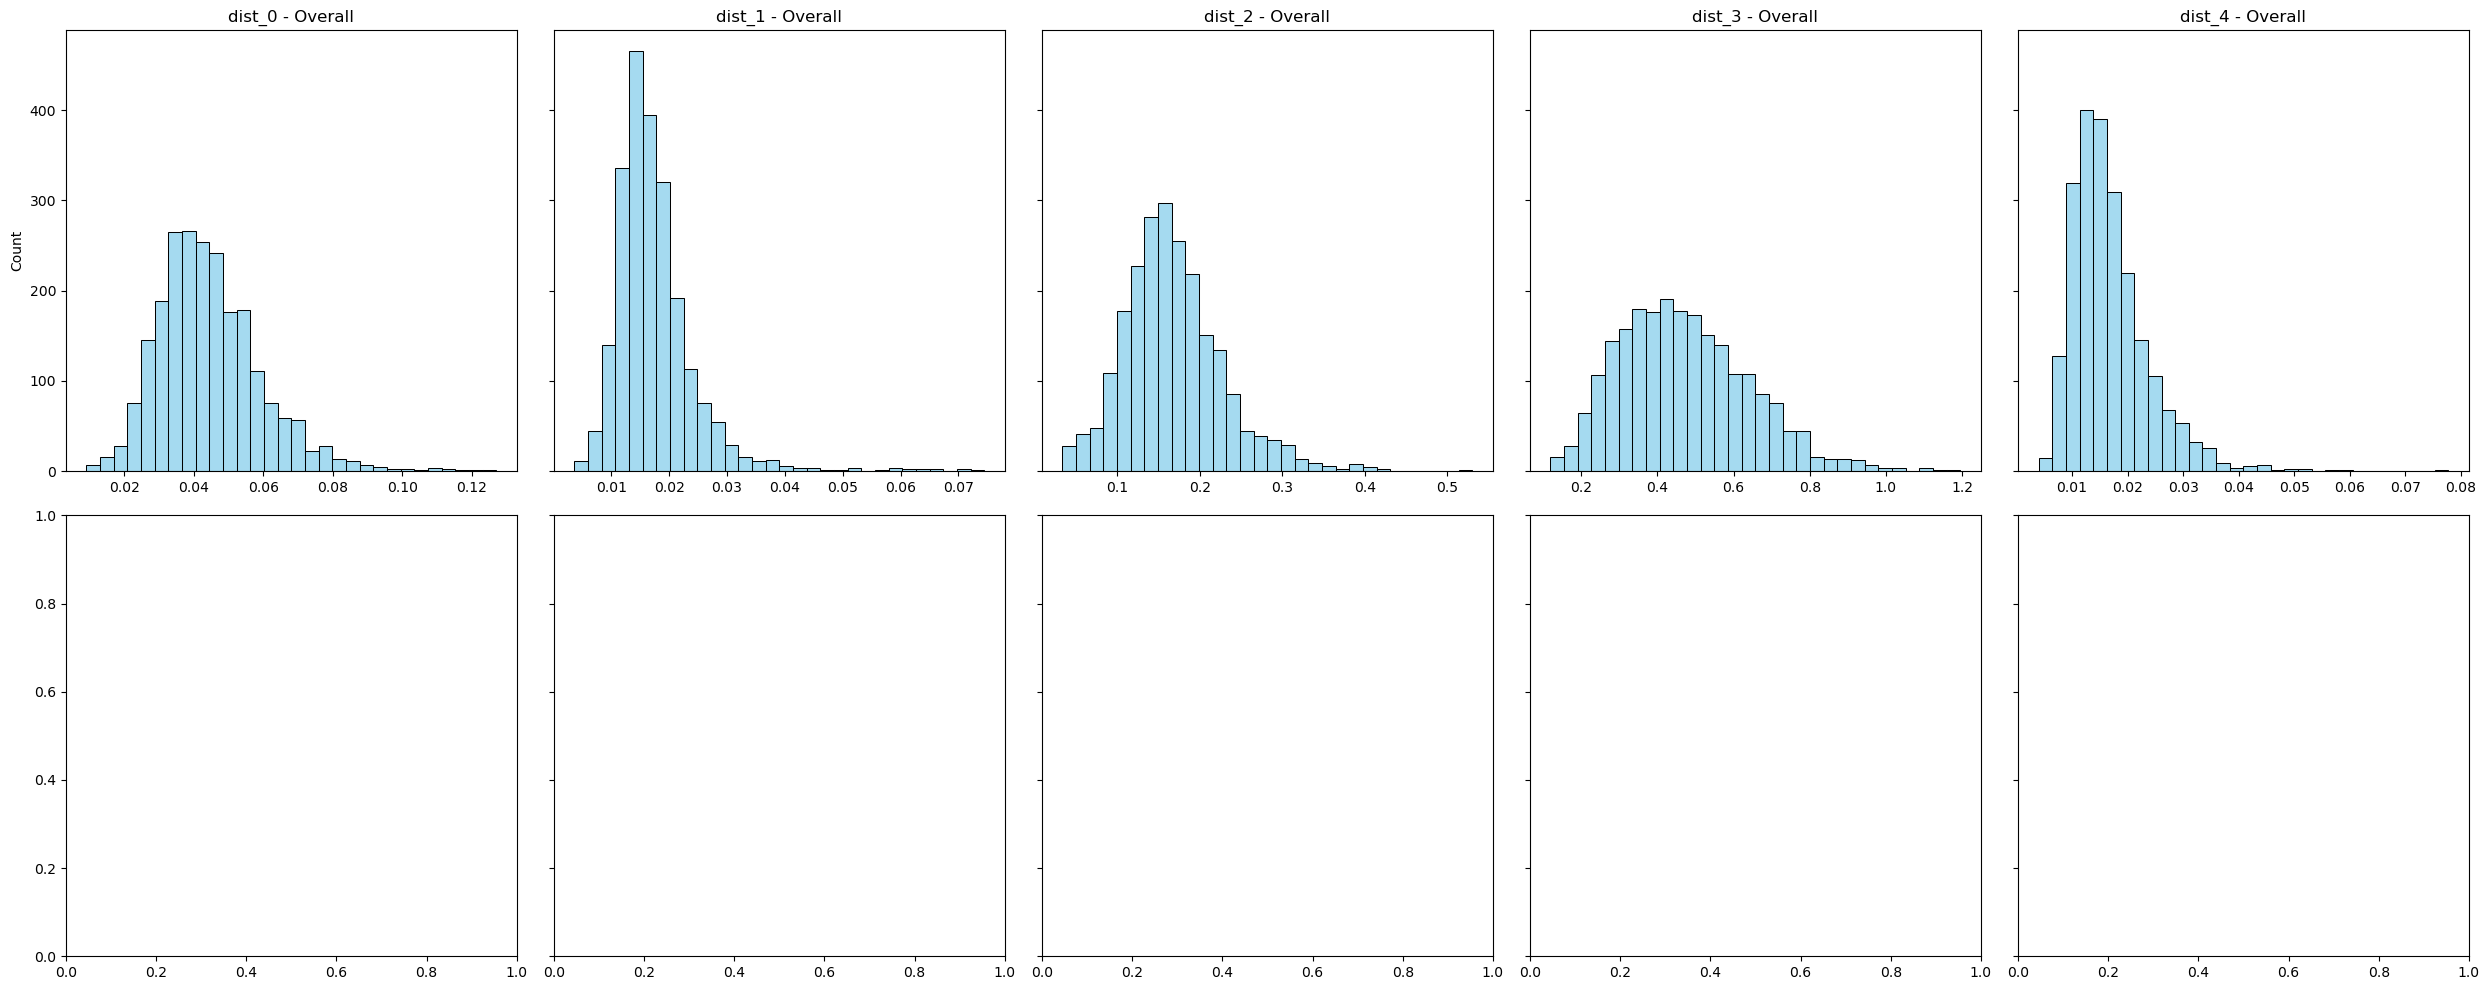

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.021486,0.007652,0.008113,0.002170,0.053011,0.009058,0.270325,0.102703,0.024833,0.008703
1.0,0.042049,0.009199,0.016725,0.004282,0.174374,0.041012,0.485474,0.108818,0.016572,0.005418
2.0,0.038852,0.011576,0.020665,0.006144,0.183514,0.046919,0.442314,0.146047,0.019394,0.006376
3.0,0.046308,0.015787,0.019710,0.006342,0.172308,0.044466,0.447074,0.108979,0.015499,0.005936
4.0,0.040880,0.012387,0.016735,0.005307,0.163129,0.051952,0.473852,0.133512,0.014532,0.007601
...,...,...,...,...,...,...,...,...,...,...
62.0,0.041316,0.013750,0.018464,0.006500,0.164972,0.053393,0.505642,0.191128,0.018778,0.008039
63.0,0.048354,0.013133,0.018251,0.006561,0.162233,0.058349,0.457689,0.146669,0.014233,0.005544
64.0,0.048791,0.015113,0.016321,0.005267,0.161717,0.054475,0.450568,0.082004,0.014616,0.007846


In [267]:
merged_df = process_merge(paths, 330, distance_metric = 'cosine', normalization = 'none')
graph_hists(merged_df)

#### Top 10% Per Class

In [268]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0041753653444676405
Size of Union: 958
Size of Intersection: 4


In [269]:
torch.save(union_all, 'baseline_indexes/unnormed_cos_end_grok')

#### Bottom 10% Per Class

In [270]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0010193679918450561
Size of Union: 981
Size of Intersection: 1


### Class Normalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


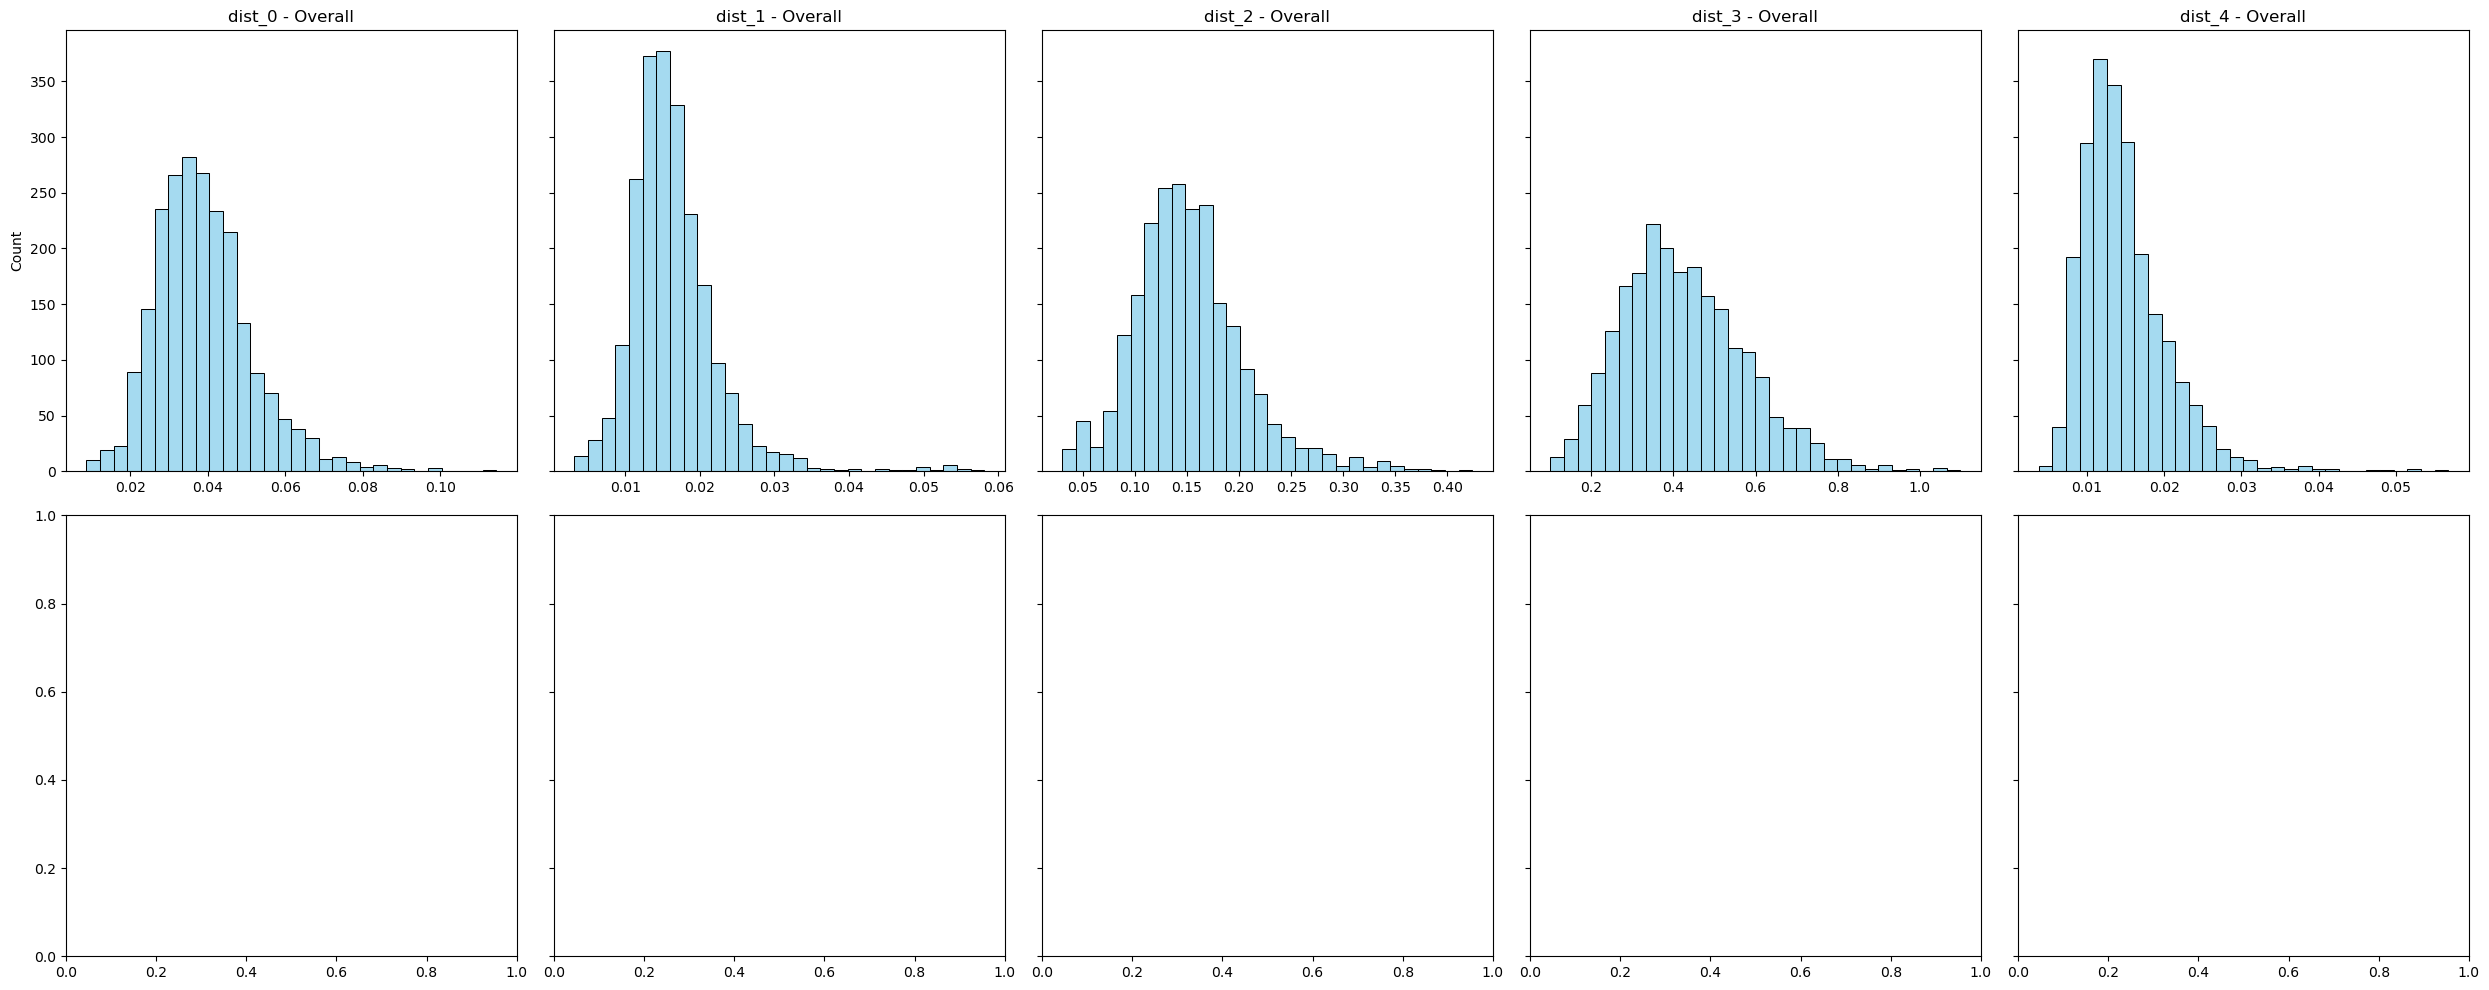

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.018450,0.006031,0.006354,0.001516,0.046658,0.007137,0.203777,0.066103,0.020490,0.007400
1.0,0.034187,0.007354,0.017105,0.003831,0.149521,0.034459,0.442695,0.120358,0.014956,0.005374
2.0,0.036850,0.010659,0.020788,0.005226,0.176447,0.050986,0.393670,0.130575,0.016224,0.005161
3.0,0.037477,0.012303,0.017346,0.004934,0.153039,0.040846,0.360560,0.056215,0.012870,0.004260
4.0,0.033942,0.010079,0.016288,0.005062,0.160829,0.051949,0.390398,0.099647,0.012035,0.005319
...,...,...,...,...,...,...,...,...,...,...
62.0,0.033165,0.009878,0.017178,0.005334,0.156297,0.051460,0.487042,0.133295,0.016470,0.006719
63.0,0.041445,0.010744,0.017151,0.005057,0.146854,0.046033,0.396696,0.100814,0.012875,0.003886
64.0,0.049055,0.014371,0.015539,0.004476,0.151304,0.055319,0.398592,0.070455,0.014435,0.006780


In [271]:
merged_df = process_merge(paths, 330, distance_metric = 'cosine', normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [272]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0032017075773745998
Size of Union: 937
Size of Intersection: 3


#### Bottom 10% Per Class

In [273]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 979
Size of Intersection: 0


### Global Normalize Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


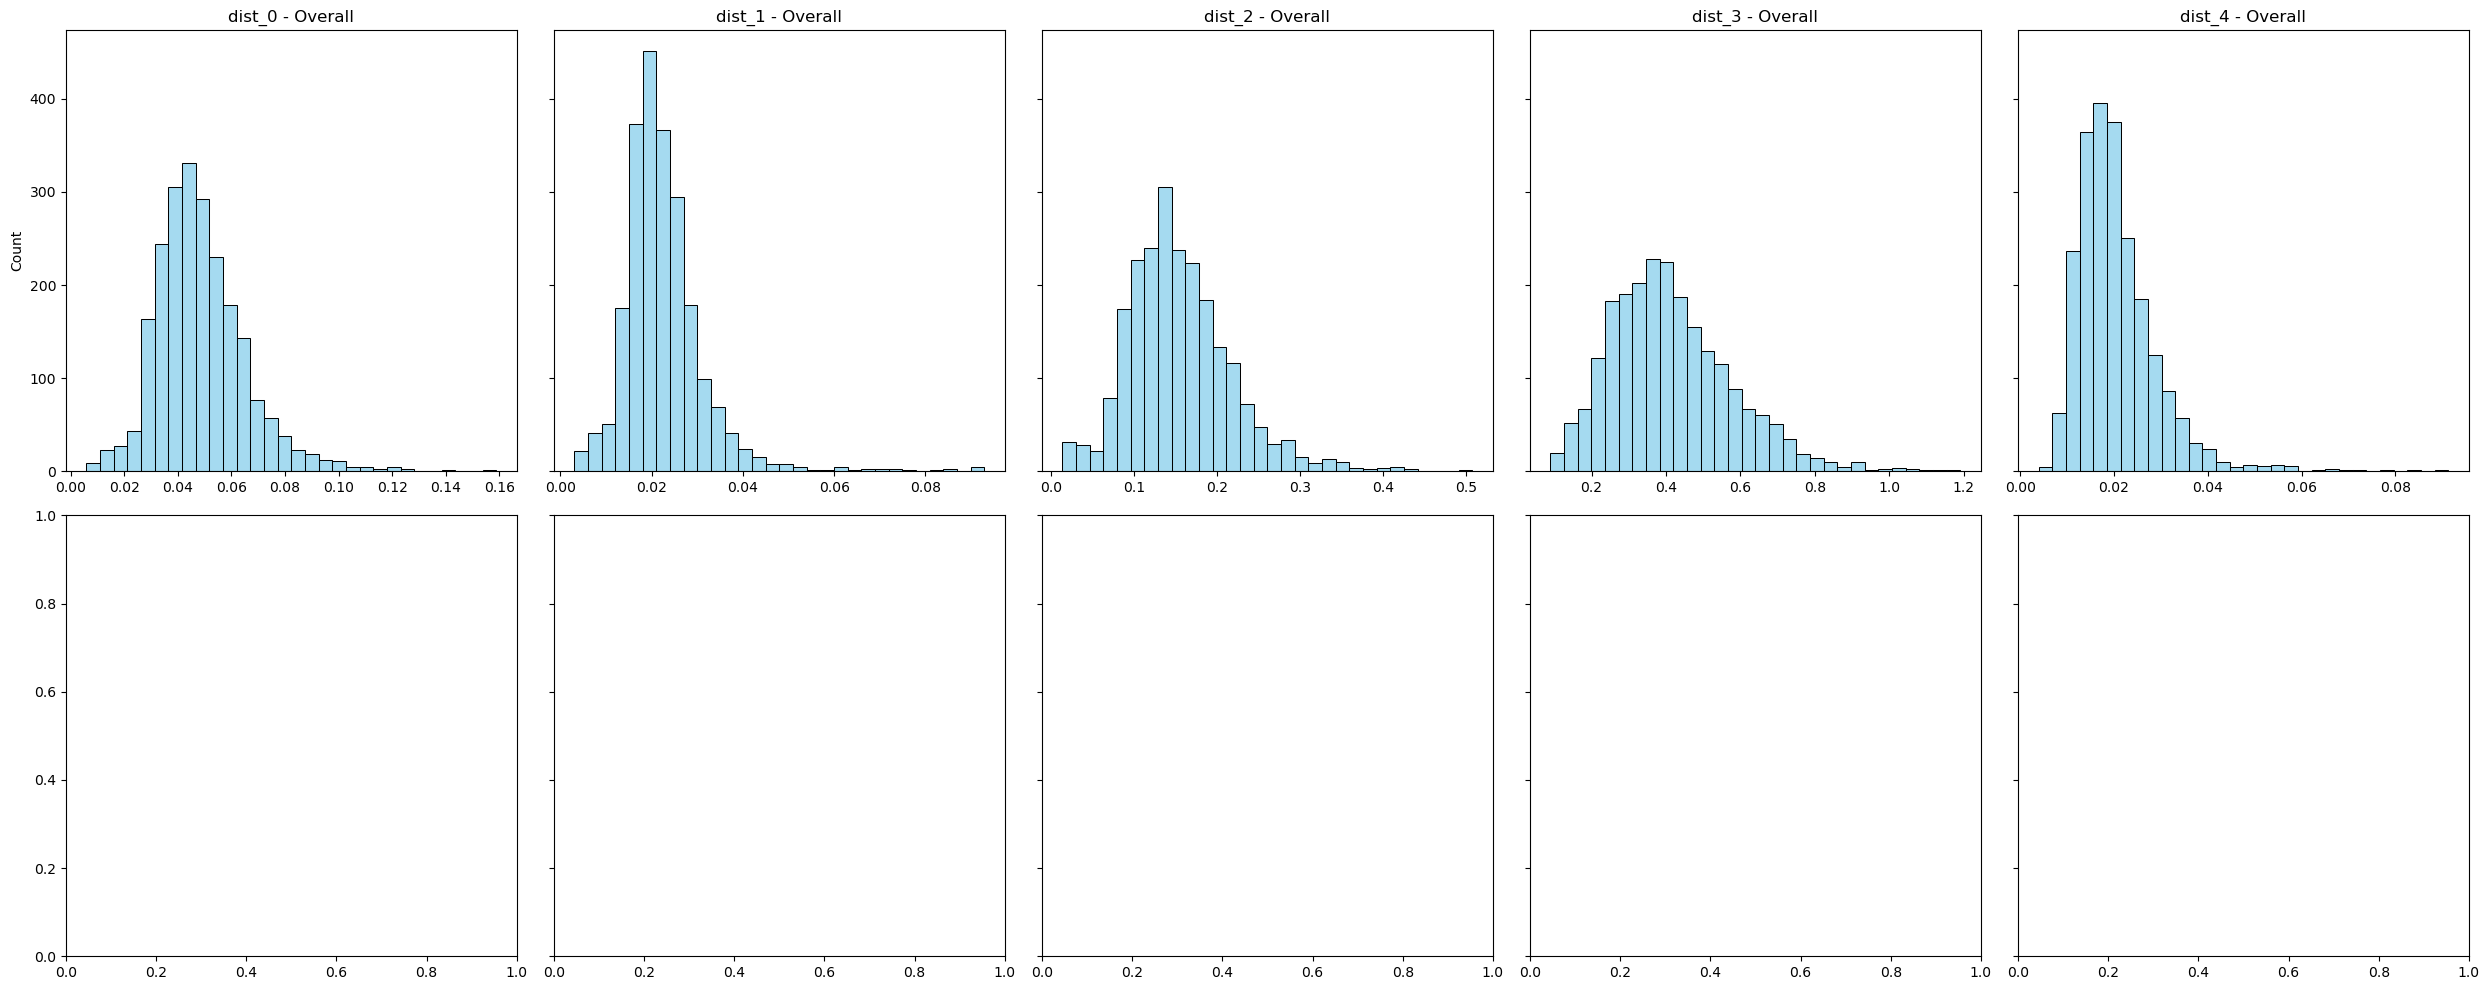

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.018361,0.007213,0.007032,0.001968,0.033763,0.011257,0.170779,0.061058,0.021868,0.009036
1.0,0.042242,0.009564,0.022056,0.005725,0.151045,0.036668,0.420827,0.118058,0.019738,0.007403
2.0,0.043819,0.016164,0.028036,0.007591,0.193500,0.063817,0.405955,0.172240,0.023438,0.007466
3.0,0.048435,0.017462,0.024111,0.007102,0.165554,0.049816,0.393943,0.085343,0.020102,0.007213
4.0,0.042087,0.012795,0.021618,0.007658,0.152650,0.058151,0.448038,0.132981,0.018085,0.009204
...,...,...,...,...,...,...,...,...,...,...
62.0,0.050783,0.018467,0.022007,0.007352,0.150550,0.056646,0.474158,0.154890,0.022340,0.010315
63.0,0.050872,0.013272,0.023765,0.007685,0.153508,0.053165,0.401274,0.133656,0.019176,0.006181
64.0,0.057978,0.018119,0.023692,0.008103,0.154915,0.061088,0.418447,0.094536,0.020442,0.009921


In [274]:
merged_df = process_merge(paths, 330, distance_metric = 'cosine', normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [275]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0032258064516129032
Size of Union: 930
Size of Intersection: 3


In [276]:
torch.save(union_all, 'baseline_indexes/global_normed_cos_end_grok')

#### Bottom 10% Per Class

In [117]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 977
Size of Intersection: 0


In [118]:
67 * 67

4489

## Start of Convergence (Epoch 75)

In [119]:
all_idxs = []
epoch = 75
for i, path in enumerate(paths):
    dat = torch.load(path + str(epoch), map_location=torch.device('cpu'), weights_only=True)
    print(dat.shape)
    labels = dat[: , LABEL_INDEX]
    y_hats = dat[: , Y_HAT_INDEX]
    idx = dat[: , IDX_INDEX]
    all_idxs.append(idx)
    activations = dat[: , :-3]

intersection_all = reduce(np.intersect1d, all_idxs)
union_all = reduce(np.union1d, all_idxs)
len(intersection_all) == len(union_all)

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


True

### Unnormalized L2 distance from class means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


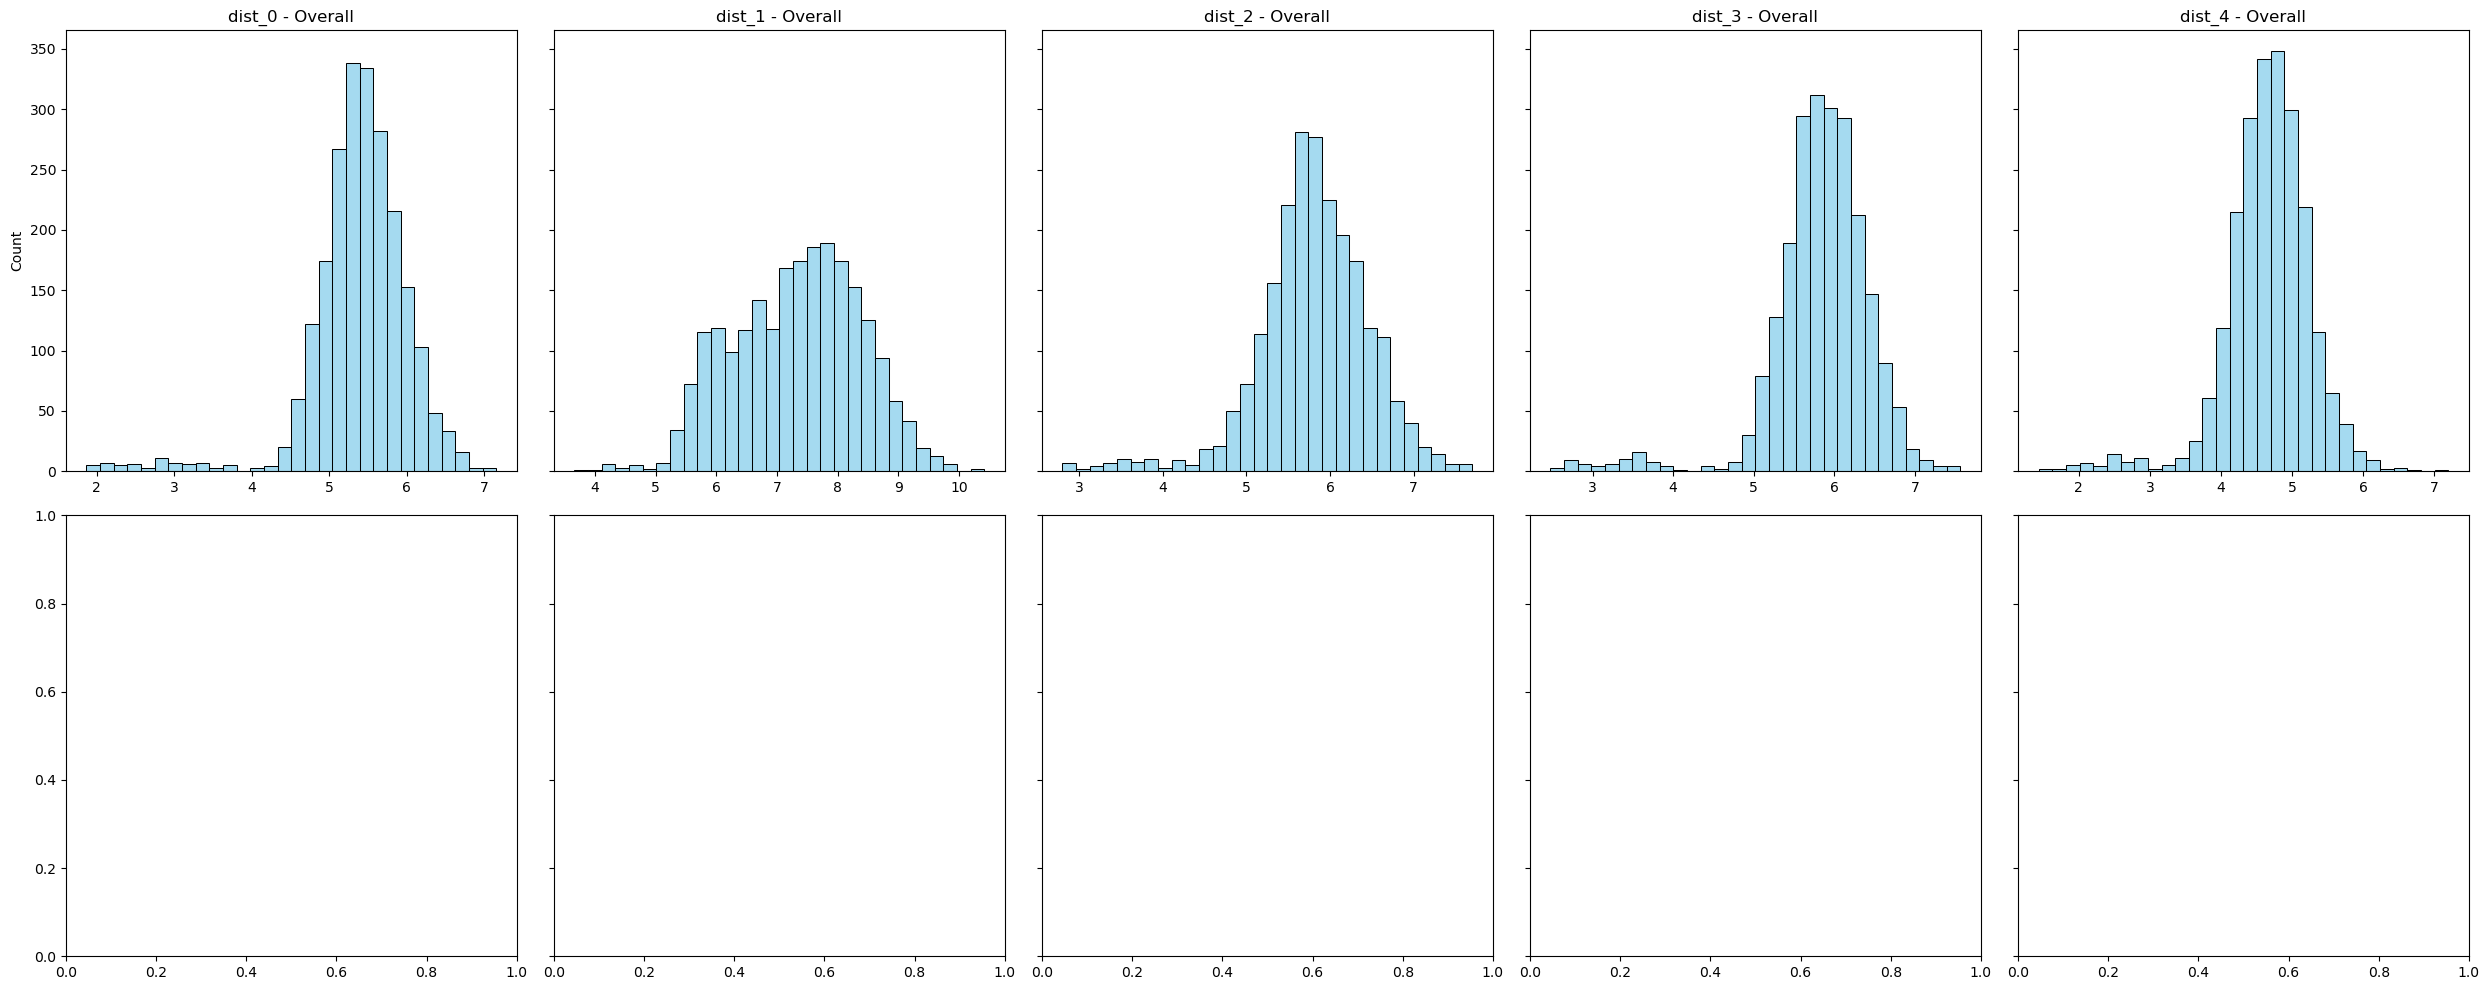

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,2.893856,0.623152,6.173421,1.326102,3.738672,0.517662,3.339162,0.443352,2.637177,0.567923
1.0,5.288543,0.507385,7.348846,0.610265,5.750811,0.610041,5.849399,0.527848,4.787286,0.424042
2.0,5.571643,0.509417,7.401447,0.782470,6.049667,0.549531,5.799573,0.531425,4.536262,0.457788
3.0,5.362228,0.401275,7.458969,0.774241,6.121944,0.669458,5.648903,0.497485,4.649310,0.375494
4.0,5.352938,0.436472,7.432409,0.905237,5.546036,0.424760,5.845864,0.413684,4.769827,0.379500
...,...,...,...,...,...,...,...,...,...,...
62.0,5.456863,0.492288,7.532409,1.322835,5.762970,0.530429,5.789507,0.321031,4.764730,0.493376
63.0,5.515505,0.376373,7.458199,1.148200,5.595740,0.615379,5.853711,0.306290,4.670941,0.456674
64.0,5.207134,0.410959,7.367286,0.865950,5.893205,0.477379,6.147307,0.419082,4.779617,0.447182


In [120]:
merged_df = process_merge(paths, 165)
graph_hists(merged_df)

#### Top 10% Per Class

In [121]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002150537634408602
Size of Union: 930
Size of Intersection: 2


#### Bottom 10% Per Class

In [122]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 965
Size of Intersection: 0


#### Highest 10% STD Per Class

### Class Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


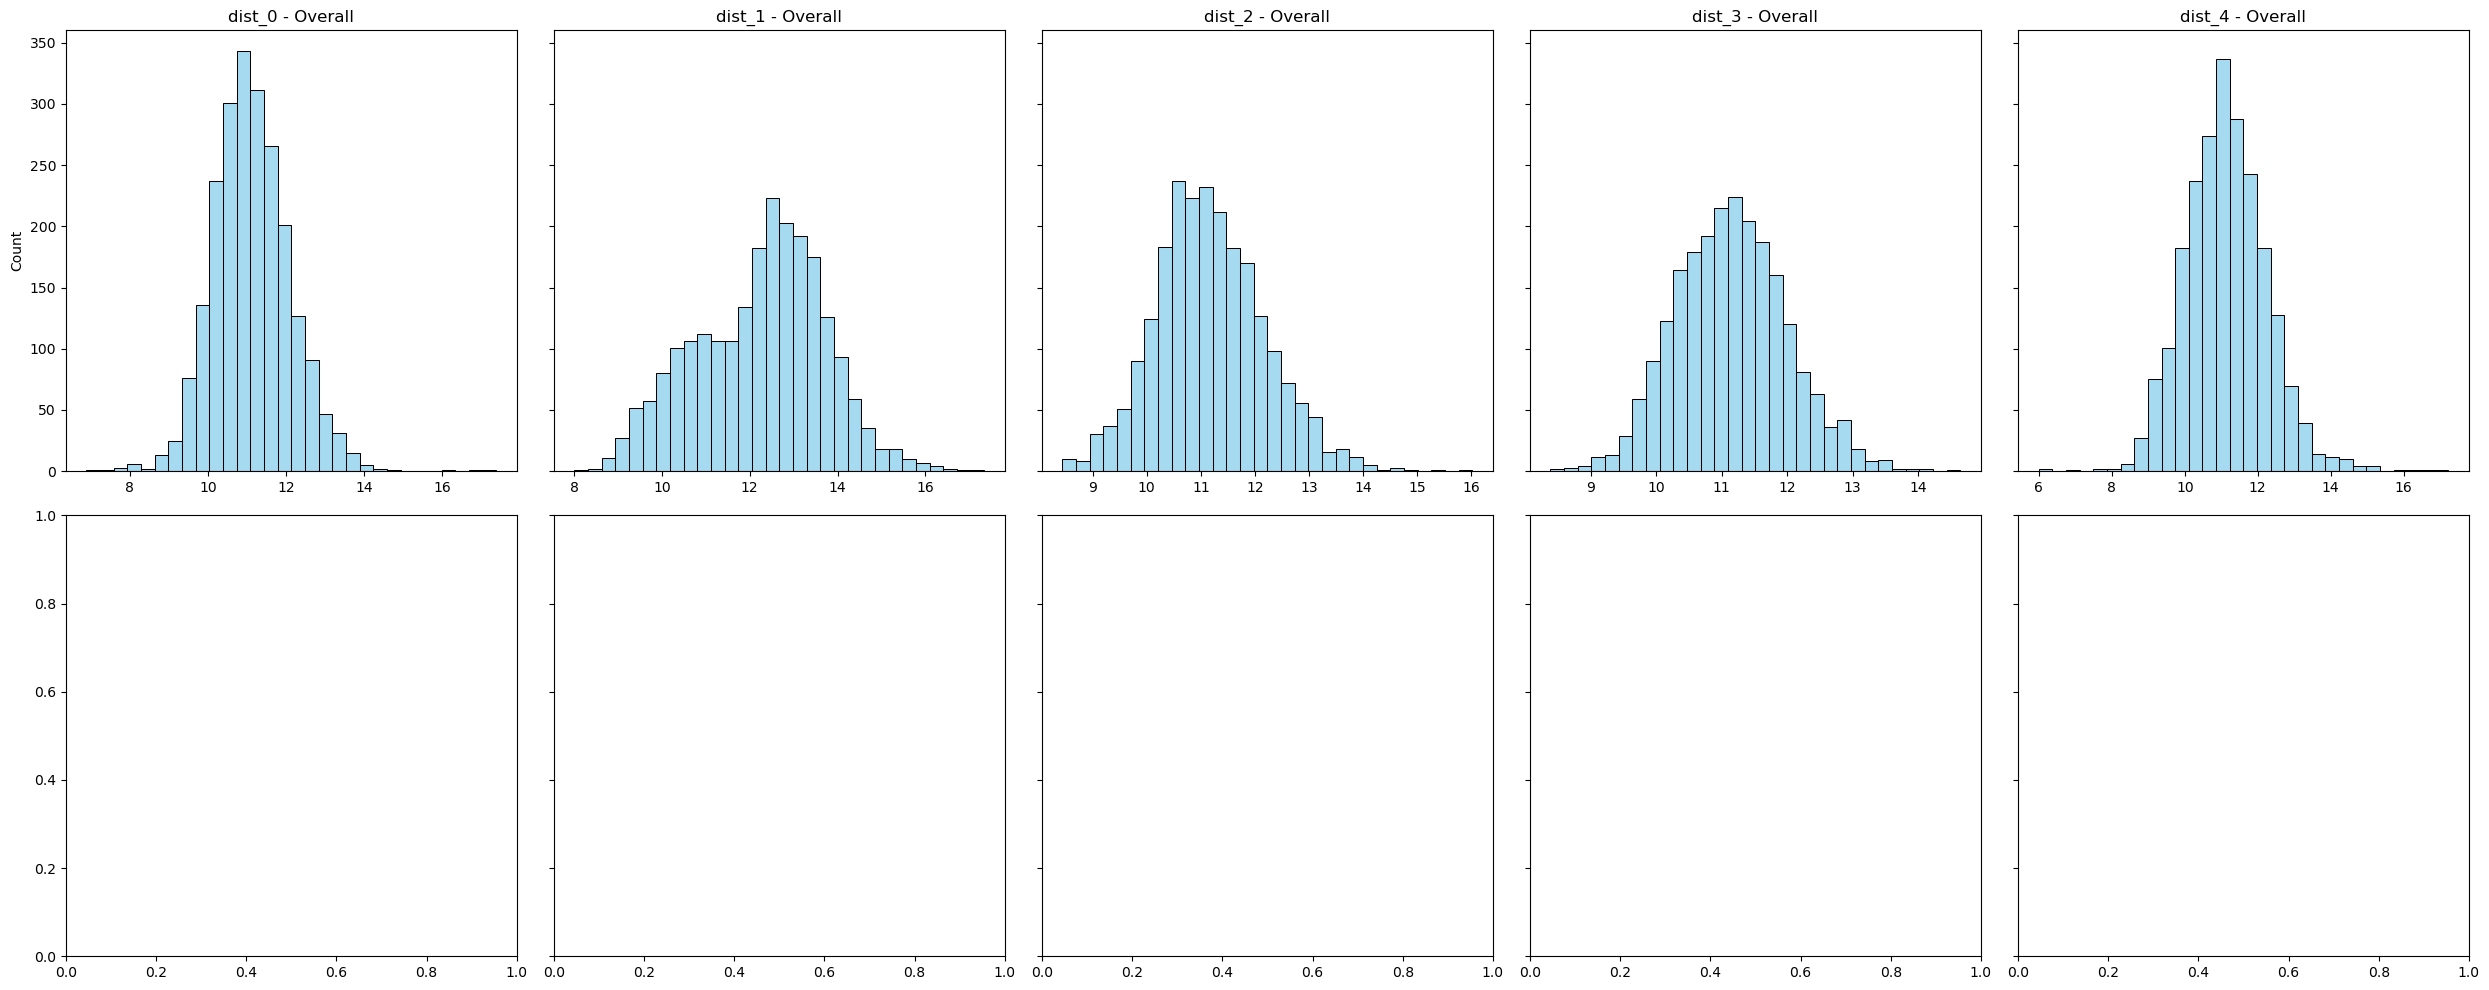

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,11.070231,2.326409,12.732127,2.227306,11.335523,1.569292,11.257837,1.422587,11.131578,2.307149
1.0,11.110968,1.003707,12.281871,0.934881,11.155971,1.171676,11.125841,0.931276,11.126153,1.006046
2.0,11.081249,0.981308,12.268624,1.044591,11.136721,0.916791,11.095525,1.002475,11.096218,1.073893
3.0,11.124833,0.869140,12.206034,1.135728,11.152549,1.147129,11.136200,0.935244,11.146110,0.889280
4.0,11.145286,0.876353,12.247074,1.274164,11.208480,0.843097,11.158996,0.879893,11.161065,0.888302
...,...,...,...,...,...,...,...,...,...,...
62.0,11.095743,1.056756,12.042864,1.686653,11.160065,0.991470,11.139730,0.679310,11.104059,1.201336
63.0,11.162275,0.794433,12.296004,1.759836,11.187909,1.186607,11.182783,0.681354,11.166115,0.987164
64.0,11.146021,0.856024,12.233098,1.121876,11.193418,0.892980,11.154805,0.786218,11.140767,1.046245


In [123]:
merged_df = process_merge(paths, 165, normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [124]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.001098901098901099
Size of Union: 910
Size of Intersection: 1


#### Bottom 10% Per Class

In [125]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 933
Size of Intersection: 0


### Global Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


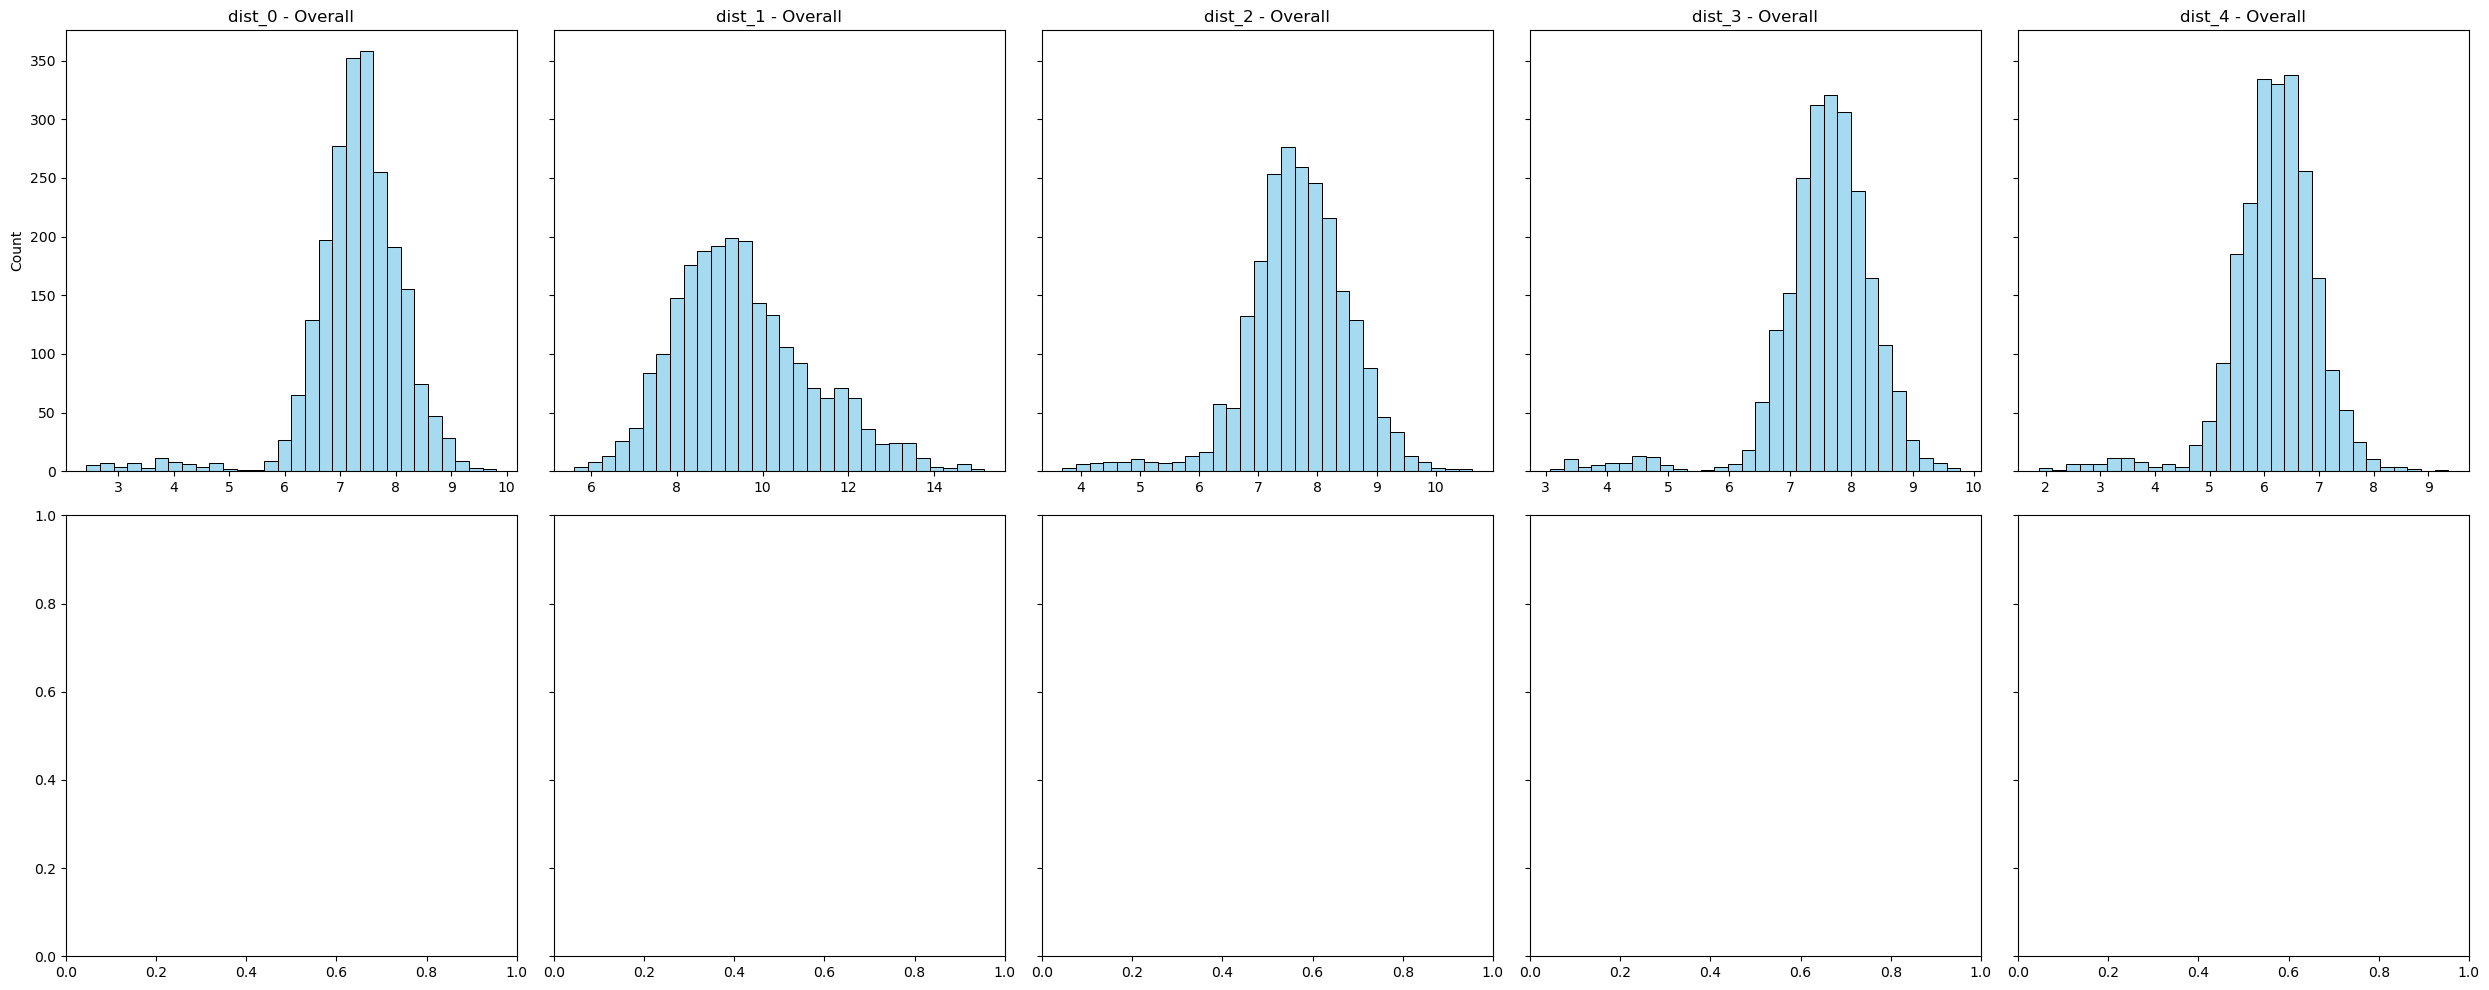

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,3.857198,0.858410,7.850786,1.063752,4.884800,0.672476,4.281095,0.569762,3.411823,0.745162
1.0,7.174717,0.719463,9.491033,1.884103,7.534461,0.736799,7.601470,0.652381,6.351732,0.563729
2.0,7.590507,0.684854,9.690985,1.339082,7.995481,0.699484,7.551389,0.719704,6.018485,0.616923
3.0,7.232275,0.535257,9.647958,1.656028,8.063410,0.834292,7.320074,0.651273,6.222808,0.490217
4.0,7.227046,0.605738,9.743732,1.662179,7.328934,0.556689,7.589678,0.607498,6.359828,0.492170
...,...,...,...,...,...,...,...,...,...,...
62.0,7.394935,0.673763,9.979224,1.270645,7.606972,0.611106,7.518721,0.452084,6.346771,0.670061
63.0,7.440249,0.522000,9.815653,1.018559,7.369556,0.775348,7.631787,0.456142,6.164620,0.609586
64.0,7.035305,0.590693,9.551133,1.859824,7.829323,0.657428,8.040304,0.528914,6.323107,0.595976


In [126]:
merged_df = process_merge(paths, 165, normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [127]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0021164021164021165
Size of Union: 945
Size of Intersection: 2


#### Bottom 10% Per Class

In [128]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 937
Size of Intersection: 0


### Unnormalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


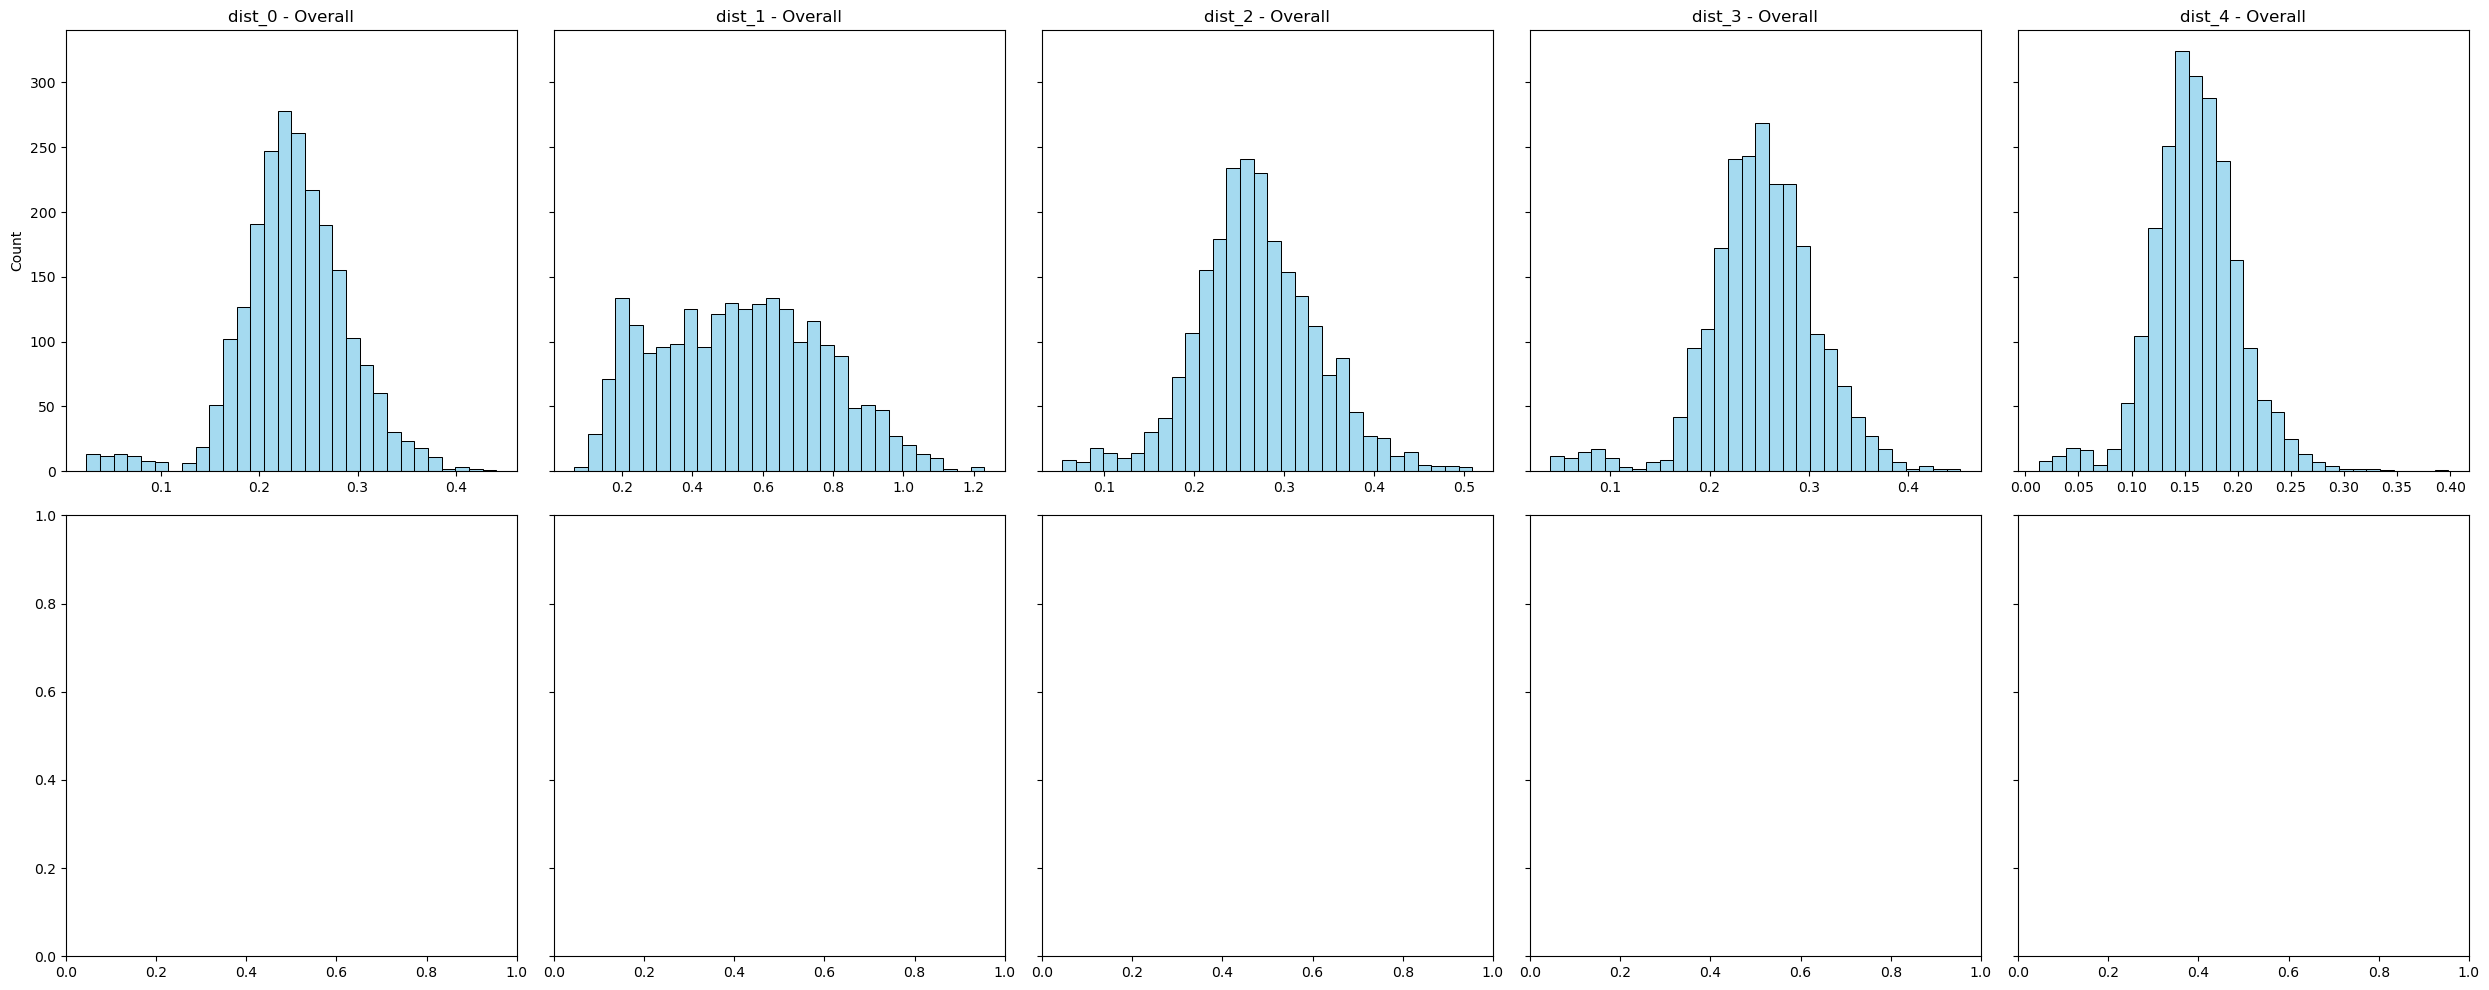

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.065010,0.029614,0.345861,0.171693,0.104532,0.031339,0.077128,0.021244,0.050809,0.022875
1.0,0.224636,0.049138,0.526928,0.146719,0.262904,0.067601,0.256884,0.052544,0.167058,0.032677
2.0,0.251889,0.053939,0.546692,0.186098,0.293437,0.064695,0.249719,0.053359,0.148412,0.032418
3.0,0.230717,0.038535,0.560027,0.185964,0.303914,0.080466,0.233857,0.049574,0.157648,0.028281
4.0,0.228045,0.043343,0.557003,0.208471,0.239436,0.041726,0.251134,0.043657,0.167012,0.028990
...,...,...,...,...,...,...,...,...,...,...
62.0,0.237488,0.049005,0.591149,0.298831,0.264073,0.058554,0.248923,0.033307,0.166808,0.039811
63.0,0.246563,0.038740,0.563729,0.255909,0.246013,0.062179,0.249280,0.030806,0.159524,0.033191
64.0,0.214573,0.038836,0.541540,0.215885,0.274999,0.052074,0.285605,0.046902,0.166514,0.033561


In [129]:
merged_df = process_merge(paths, 165, distance_metric = 'cosine', normalization = 'none')
graph_hists(merged_df)

#### Top 10% Per Class

In [130]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0021344717182497333
Size of Union: 937
Size of Intersection: 2


#### Bottom 10% Per Class

In [131]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 957
Size of Intersection: 0


### Class Normalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


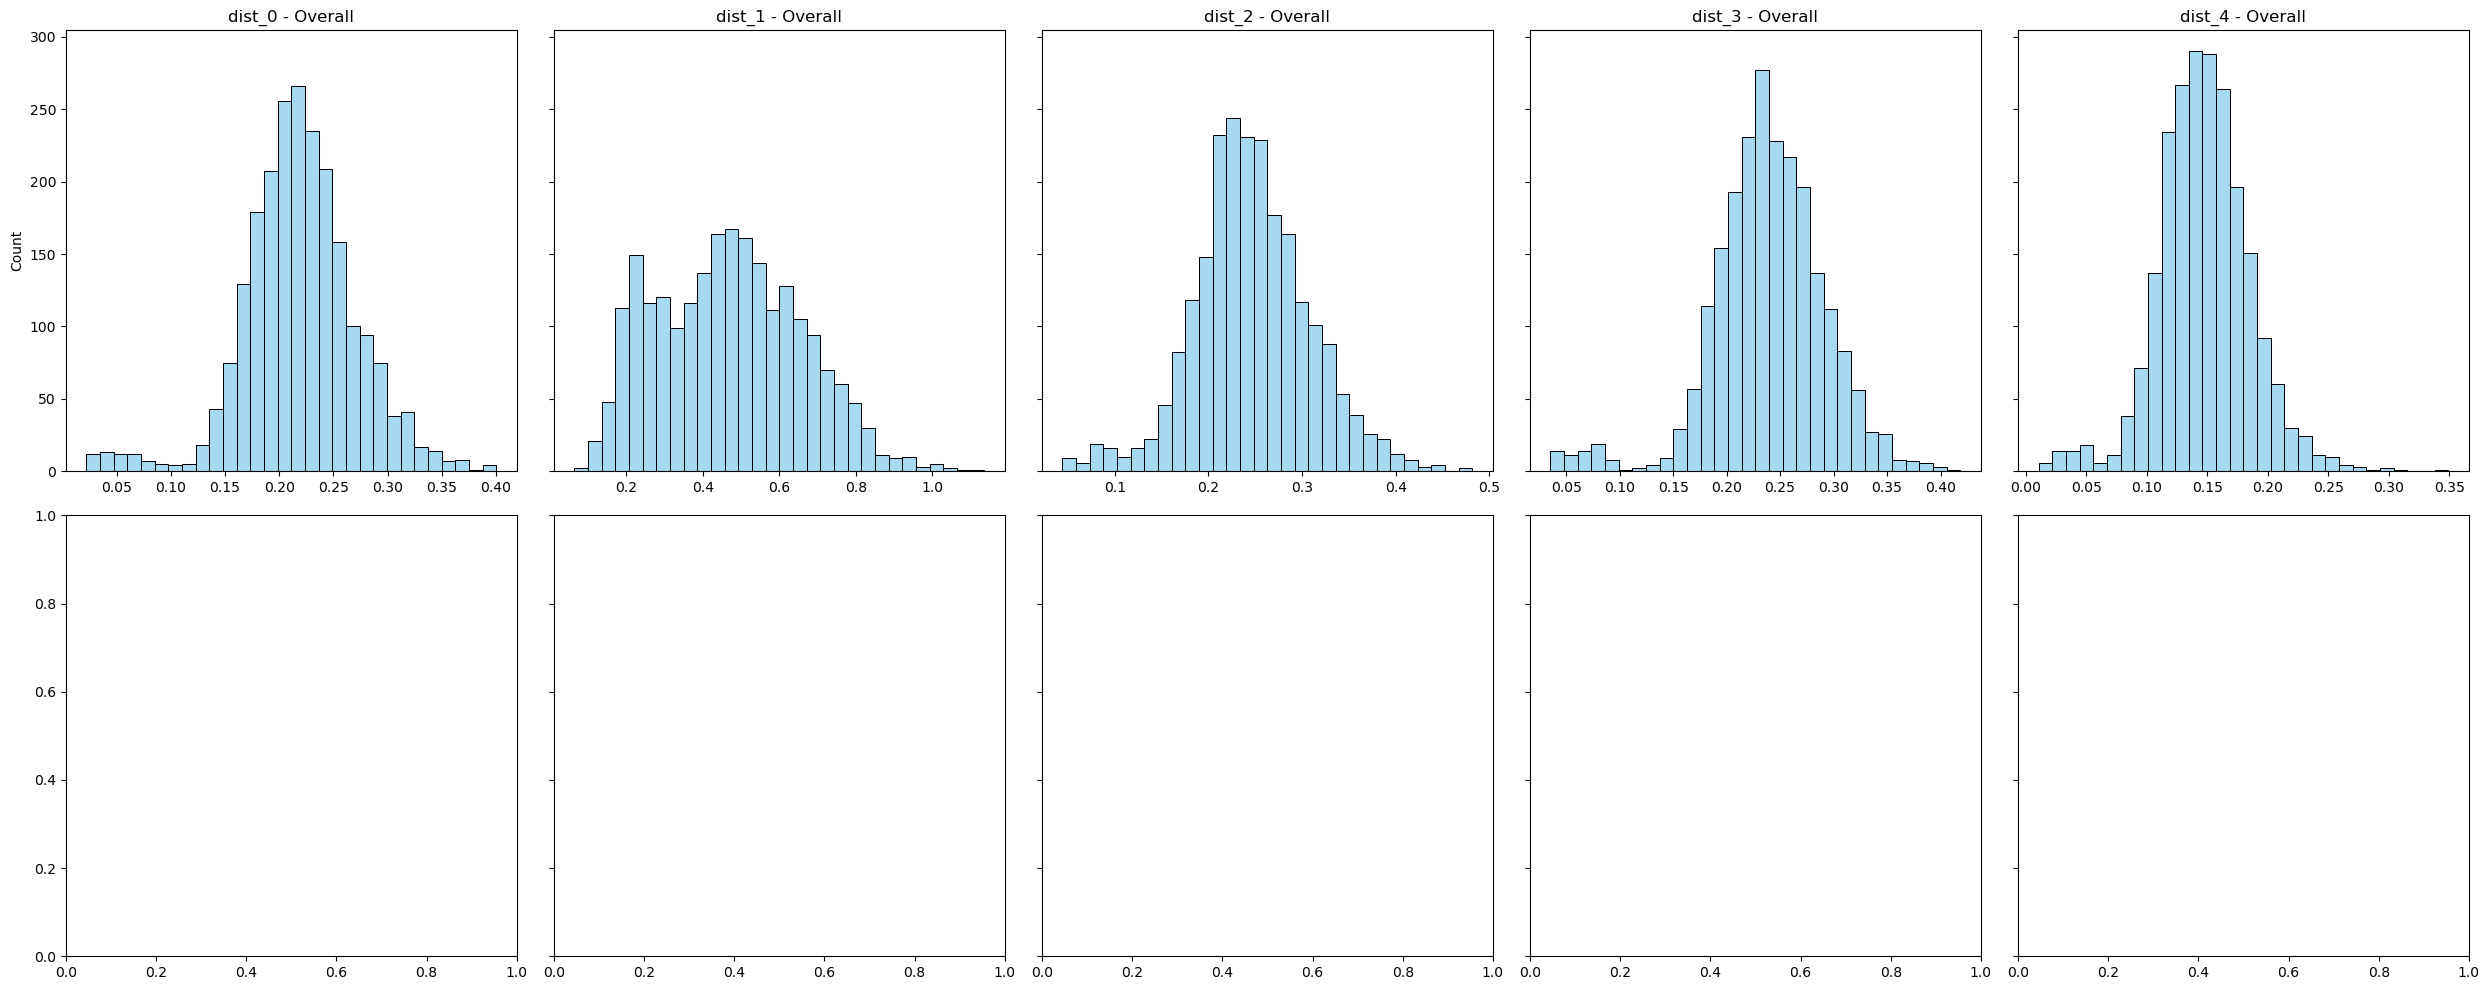

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.061518,0.027544,0.295777,0.126692,0.090693,0.027632,0.067415,0.018138,0.045032,0.019727
1.0,0.201264,0.043503,0.460375,0.139093,0.244491,0.061707,0.236037,0.046205,0.157722,0.030276
2.0,0.234835,0.046925,0.462444,0.148487,0.268134,0.056180,0.233941,0.050477,0.130715,0.027500
3.0,0.210238,0.035868,0.470671,0.150084,0.275285,0.074226,0.218649,0.039781,0.139148,0.024704
4.0,0.215959,0.038760,0.493212,0.177071,0.225558,0.039149,0.238072,0.042627,0.156532,0.026404
...,...,...,...,...,...,...,...,...,...,...
62.0,0.207849,0.046870,0.509216,0.220811,0.243685,0.051036,0.233751,0.033509,0.157383,0.039654
63.0,0.226013,0.037465,0.487713,0.192468,0.227995,0.057944,0.242405,0.030815,0.147769,0.028857
64.0,0.194907,0.034959,0.482479,0.163063,0.253554,0.051394,0.271393,0.045711,0.159100,0.032438


In [132]:
merged_df = process_merge(paths, 165, distance_metric = 'cosine', normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [133]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002157497303128371
Size of Union: 927
Size of Intersection: 2


#### Bottom 10% Per Class

In [134]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 956
Size of Intersection: 0


### Global Normalize Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


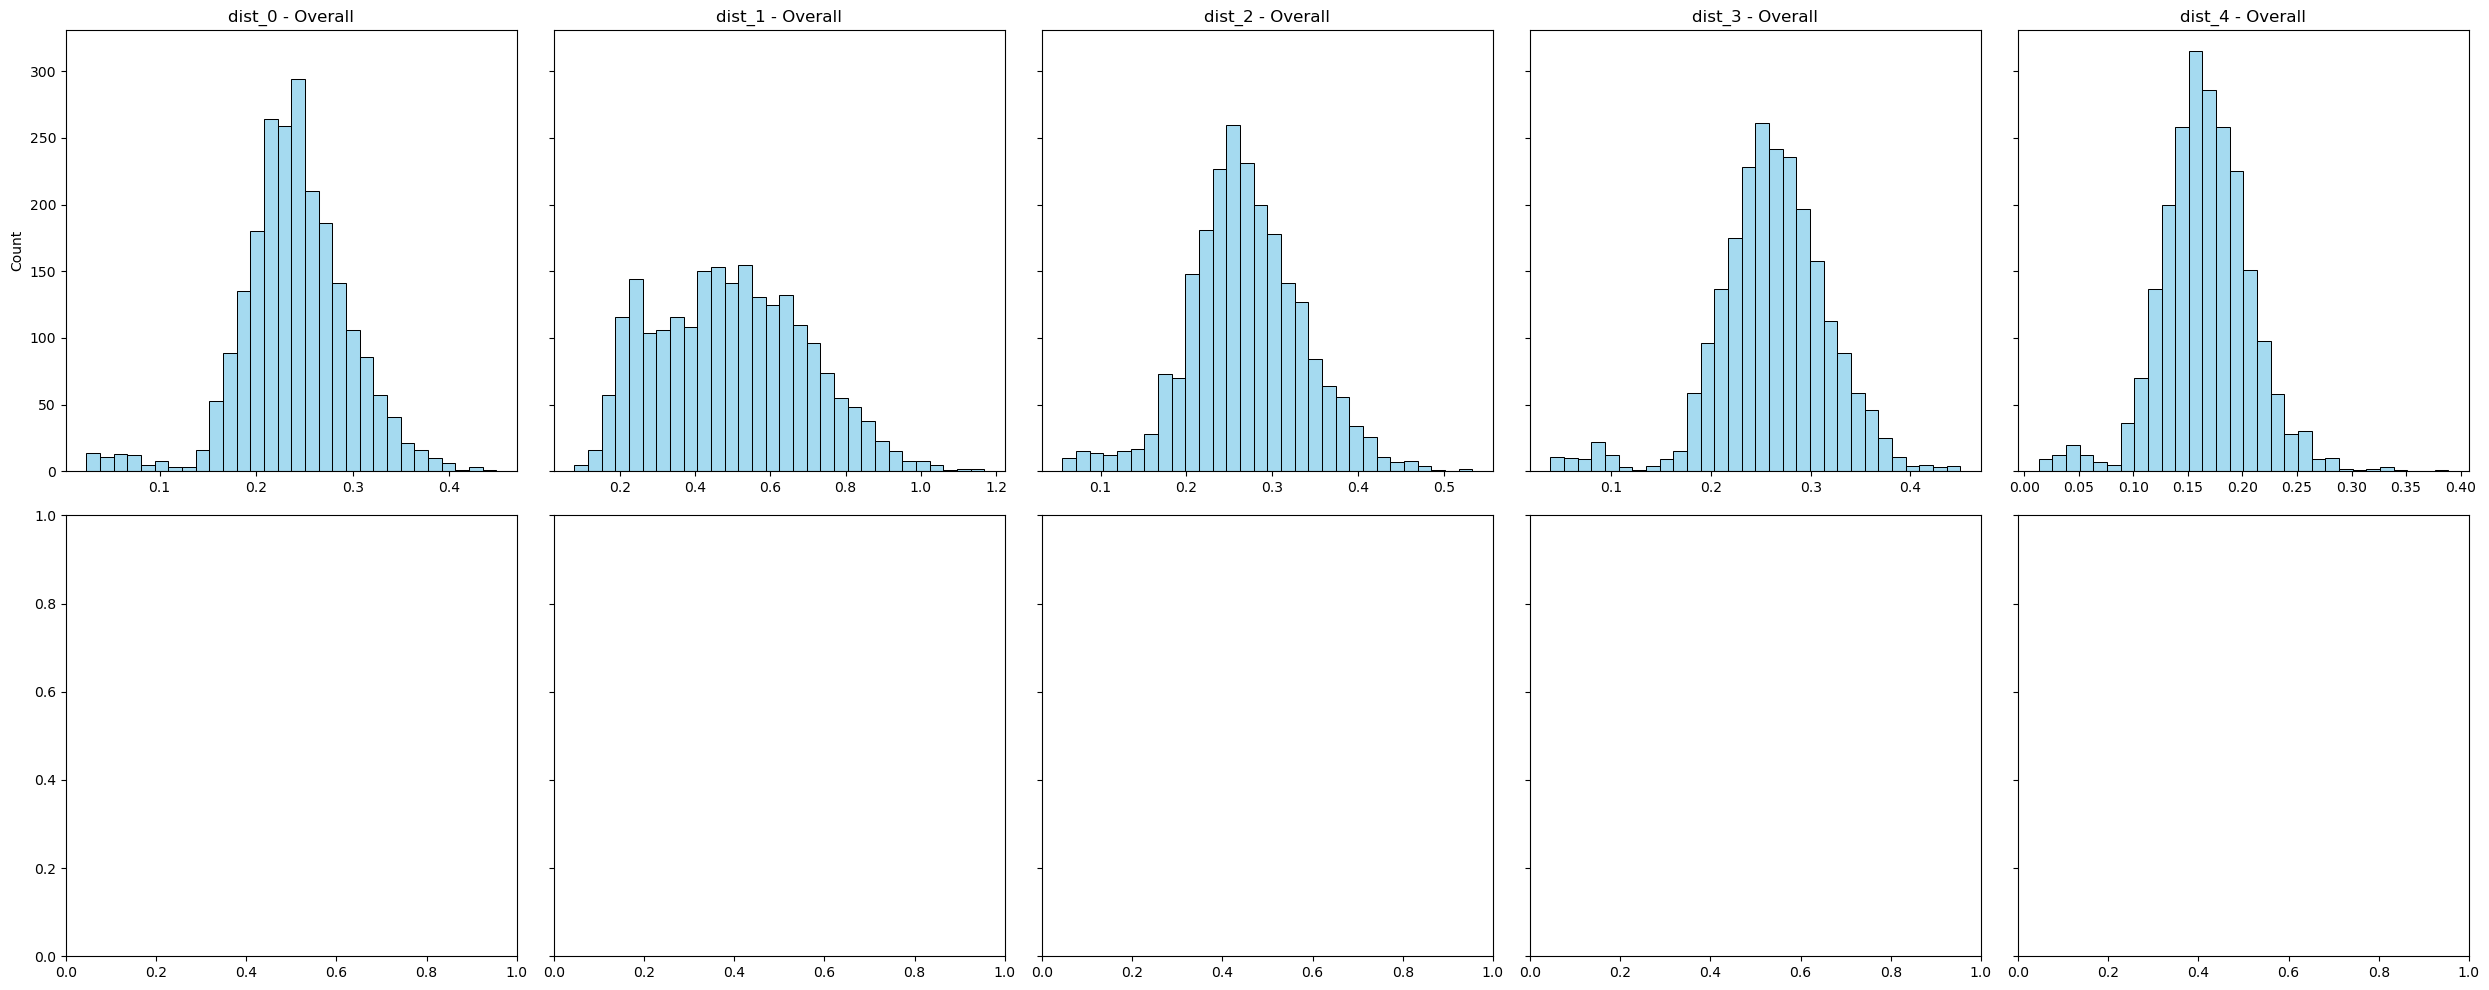

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.066872,0.030887,0.275477,0.105866,0.101577,0.030072,0.079232,0.021040,0.049455,0.022517
1.0,0.226847,0.050697,0.521817,0.140740,0.263966,0.063797,0.256865,0.052017,0.175991,0.032043
2.0,0.260906,0.056326,0.506145,0.152540,0.292152,0.063689,0.253038,0.054578,0.158105,0.032849
3.0,0.236065,0.038326,0.496427,0.150863,0.300382,0.077658,0.239568,0.046604,0.165938,0.029274
4.0,0.234411,0.045027,0.510512,0.188562,0.237475,0.038646,0.263971,0.047085,0.171426,0.027960
...,...,...,...,...,...,...,...,...,...,...
62.0,0.243560,0.051154,0.524330,0.242180,0.261834,0.049512,0.248804,0.033093,0.175918,0.041931
63.0,0.244400,0.038223,0.479730,0.206398,0.240045,0.058868,0.267018,0.033417,0.162495,0.034486
64.0,0.220206,0.040401,0.533039,0.196122,0.281390,0.053156,0.297074,0.047218,0.175190,0.034057


In [135]:
merged_df = process_merge(paths, 165, distance_metric = 'cosine', normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [136]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002136752136752137
Size of Union: 936
Size of Intersection: 2


#### Bottom 10% Per Class

In [137]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 945
Size of Intersection: 0


# Grok No Shuffle

In [138]:
paths = [f'class_means_distance/grok_baseline_no_shuffle_data_0.5_train_fraction_0.5_iter_{x}_max_epochs_400/train/train_raw_activations_epoch_' for x in list(range(5))]

In [139]:
all_idxs = []
epoch = 330
for i, path in enumerate(paths):
    dat = torch.load(path + str(epoch), map_location=torch.device('cpu'), weights_only=True)
    print(dat.shape)
    labels = dat[: , LABEL_INDEX]
    y_hats = dat[: , Y_HAT_INDEX]
    idx = dat[: , IDX_INDEX]
    all_idxs.append(idx)
    activations = dat[: , :-3]

intersection_all = reduce(np.intersect1d, all_idxs)
union_all = reduce(np.union1d, all_idxs)
len(intersection_all) == len(union_all)

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


True

## End of Convergence (Epoch 330)

### Unnormalized L2 distance from class means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


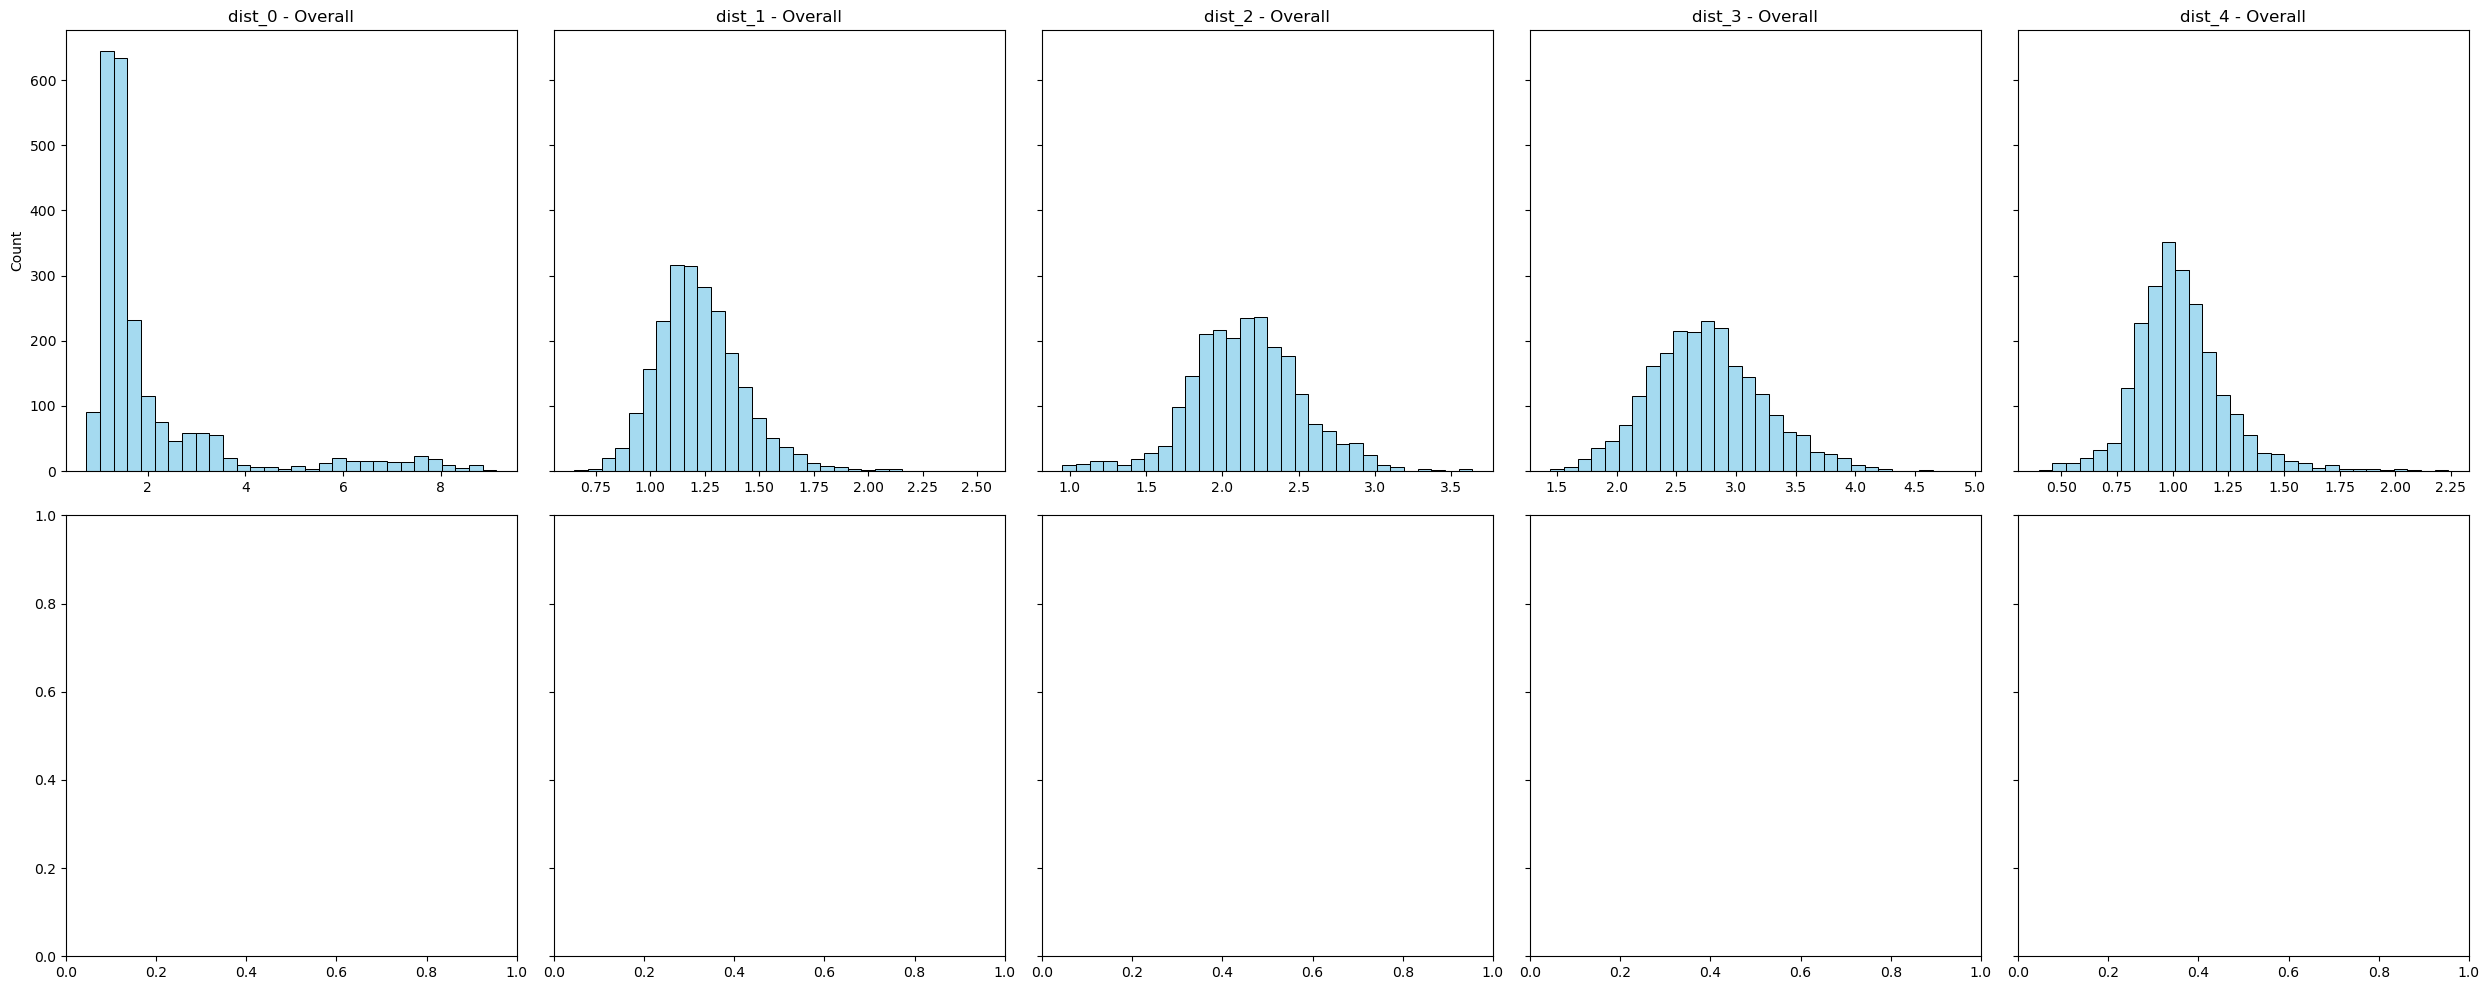

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,1.676831,1.454973,0.975612,0.137352,1.221013,0.151641,1.889211,0.190853,0.596373,0.082712
1.0,2.005215,1.714481,1.305690,0.192890,2.259978,0.278308,2.502896,0.373262,0.951150,0.144253
2.0,1.738045,0.615139,1.266458,0.195742,2.268349,0.339806,2.865550,0.484559,0.964903,0.173255
3.0,1.578004,0.576932,1.184673,0.124666,1.989892,0.316490,2.445074,0.285167,1.091488,0.199131
4.0,2.169654,1.554702,1.182888,0.121159,2.127020,0.350842,2.818654,0.561085,1.064719,0.179536
...,...,...,...,...,...,...,...,...,...,...
62.0,1.700940,0.607513,1.345021,0.202581,2.090607,0.311510,2.429844,0.417555,1.033115,0.153278
63.0,2.455761,1.923976,1.233701,0.175756,2.067078,0.217738,2.589159,0.375868,1.042035,0.163221
64.0,1.633046,0.934786,1.238244,0.182644,2.017887,0.284868,2.929922,0.409760,1.086389,0.183071


In [140]:
merged_df = process_merge(paths, 330)
graph_hists(merged_df)

#### Top 10% Per Class

In [141]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002061855670103093
Size of Union: 970
Size of Intersection: 2


#### Bottom 10% Per Class

In [142]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 1012
Size of Intersection: 0


#### Highest 10% STD Per Class

### Class Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


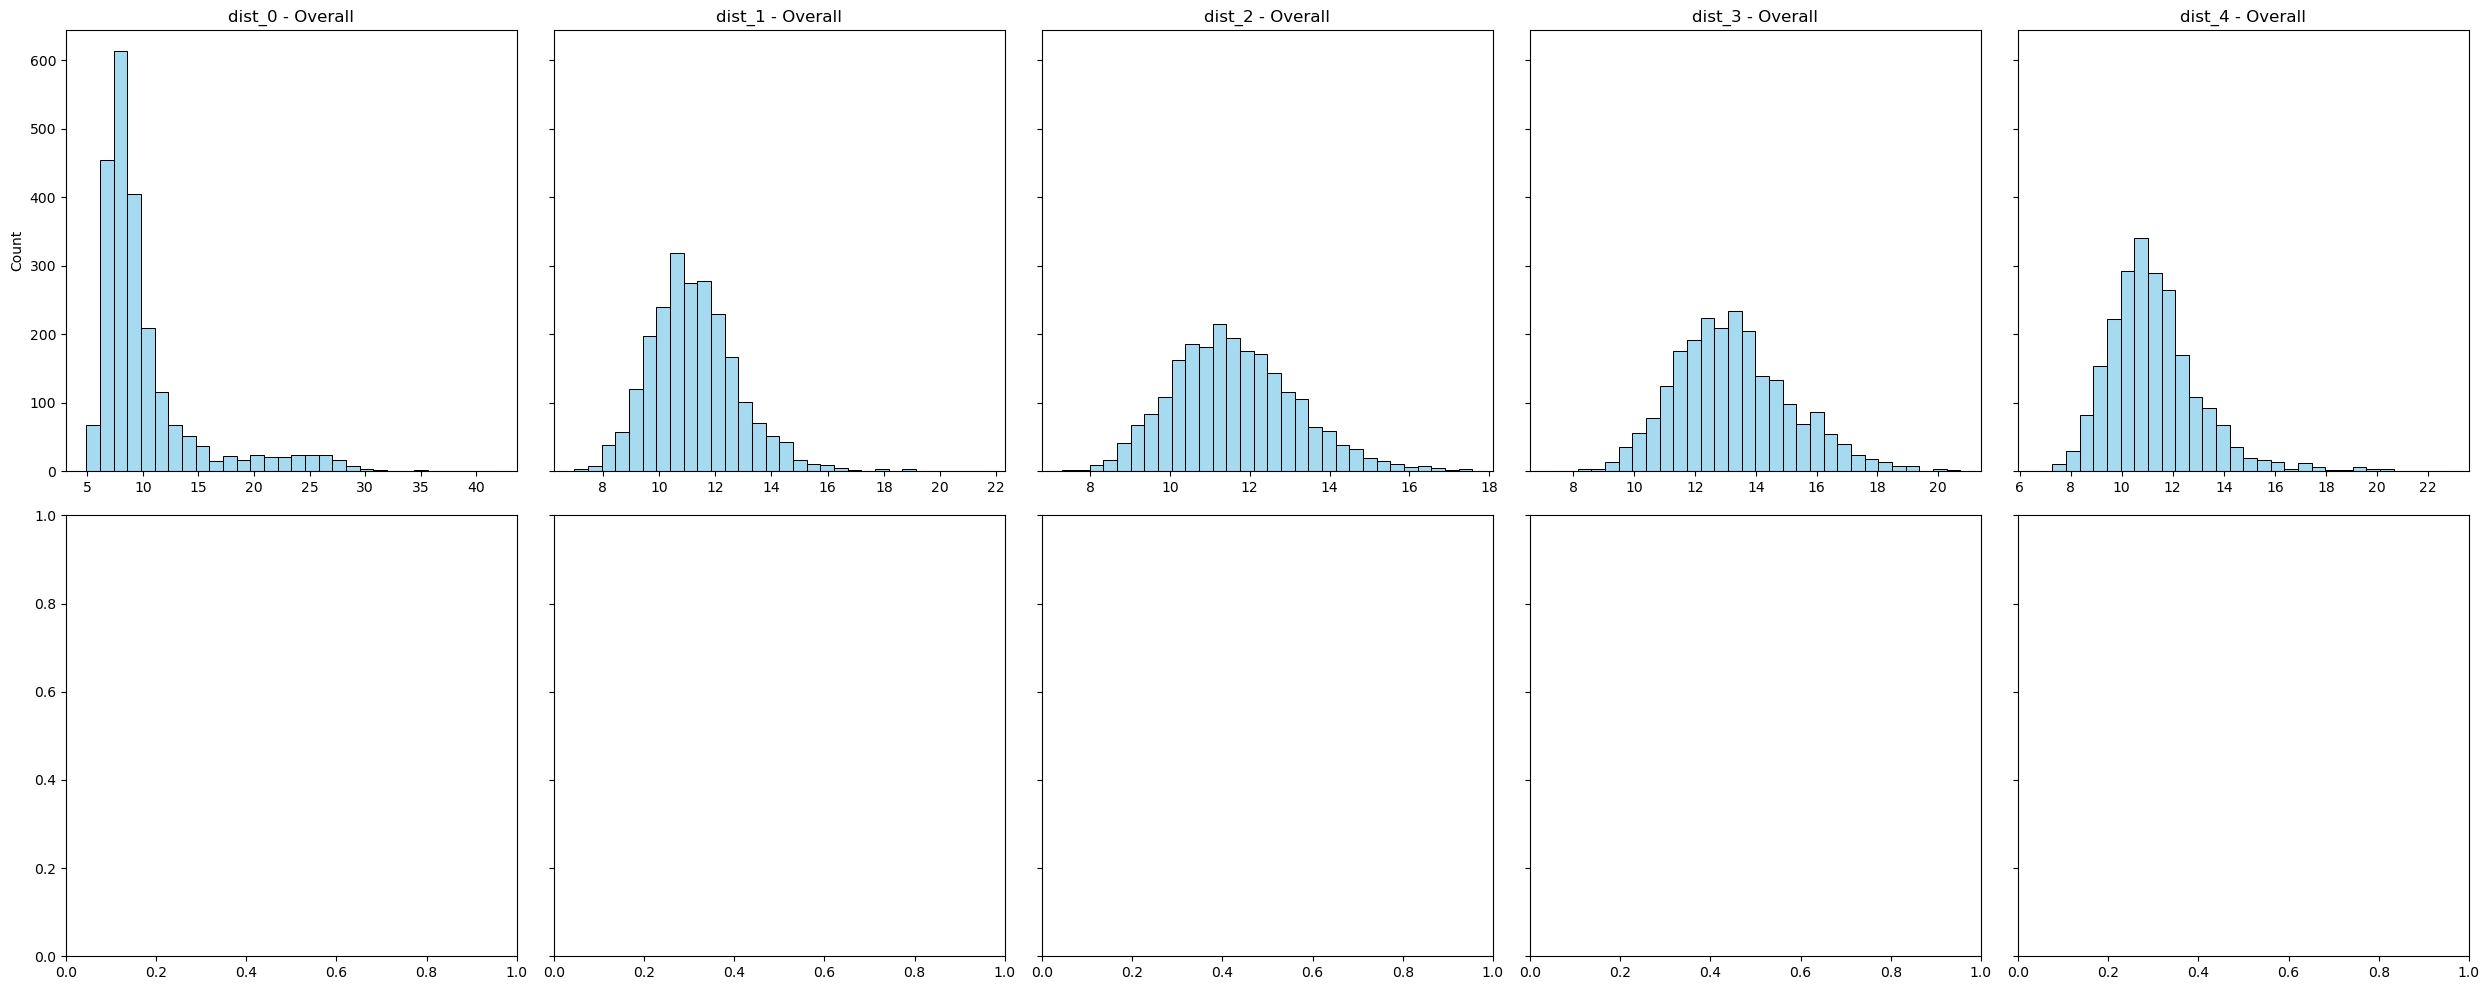

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,10.178522,5.523419,11.653661,1.345279,13.075986,1.502245,17.037951,1.473439,12.133979,1.589562
1.0,9.783631,5.736220,11.225786,1.464600,11.549829,1.474726,13.677010,1.754249,11.336419,1.514846
2.0,11.052349,2.678466,11.225319,1.623234,11.480288,1.535673,12.891006,1.641806,11.262341,1.750843
3.0,11.085455,2.959779,11.324736,1.089378,11.696847,1.677518,14.035448,1.610342,11.222578,1.771935
4.0,10.181000,4.966561,11.375224,1.069217,11.537780,1.837685,12.964289,2.195489,11.274240,1.605237
...,...,...,...,...,...,...,...,...,...,...
62.0,11.055699,2.748573,11.210453,1.573761,11.610001,1.605430,13.997289,1.943574,11.272175,1.664862
63.0,10.025484,5.264323,11.289578,1.494438,11.725667,1.091079,13.477541,1.879428,11.263244,1.745970
64.0,10.522911,4.479236,11.259350,1.554248,11.738483,1.509211,13.023017,1.442606,11.257047,1.578992


In [143]:
merged_df = process_merge(paths, 330, normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [144]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002107481559536354
Size of Union: 949
Size of Intersection: 2


#### Bottom 10% Per Class

In [145]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 1004
Size of Intersection: 0


### Global Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


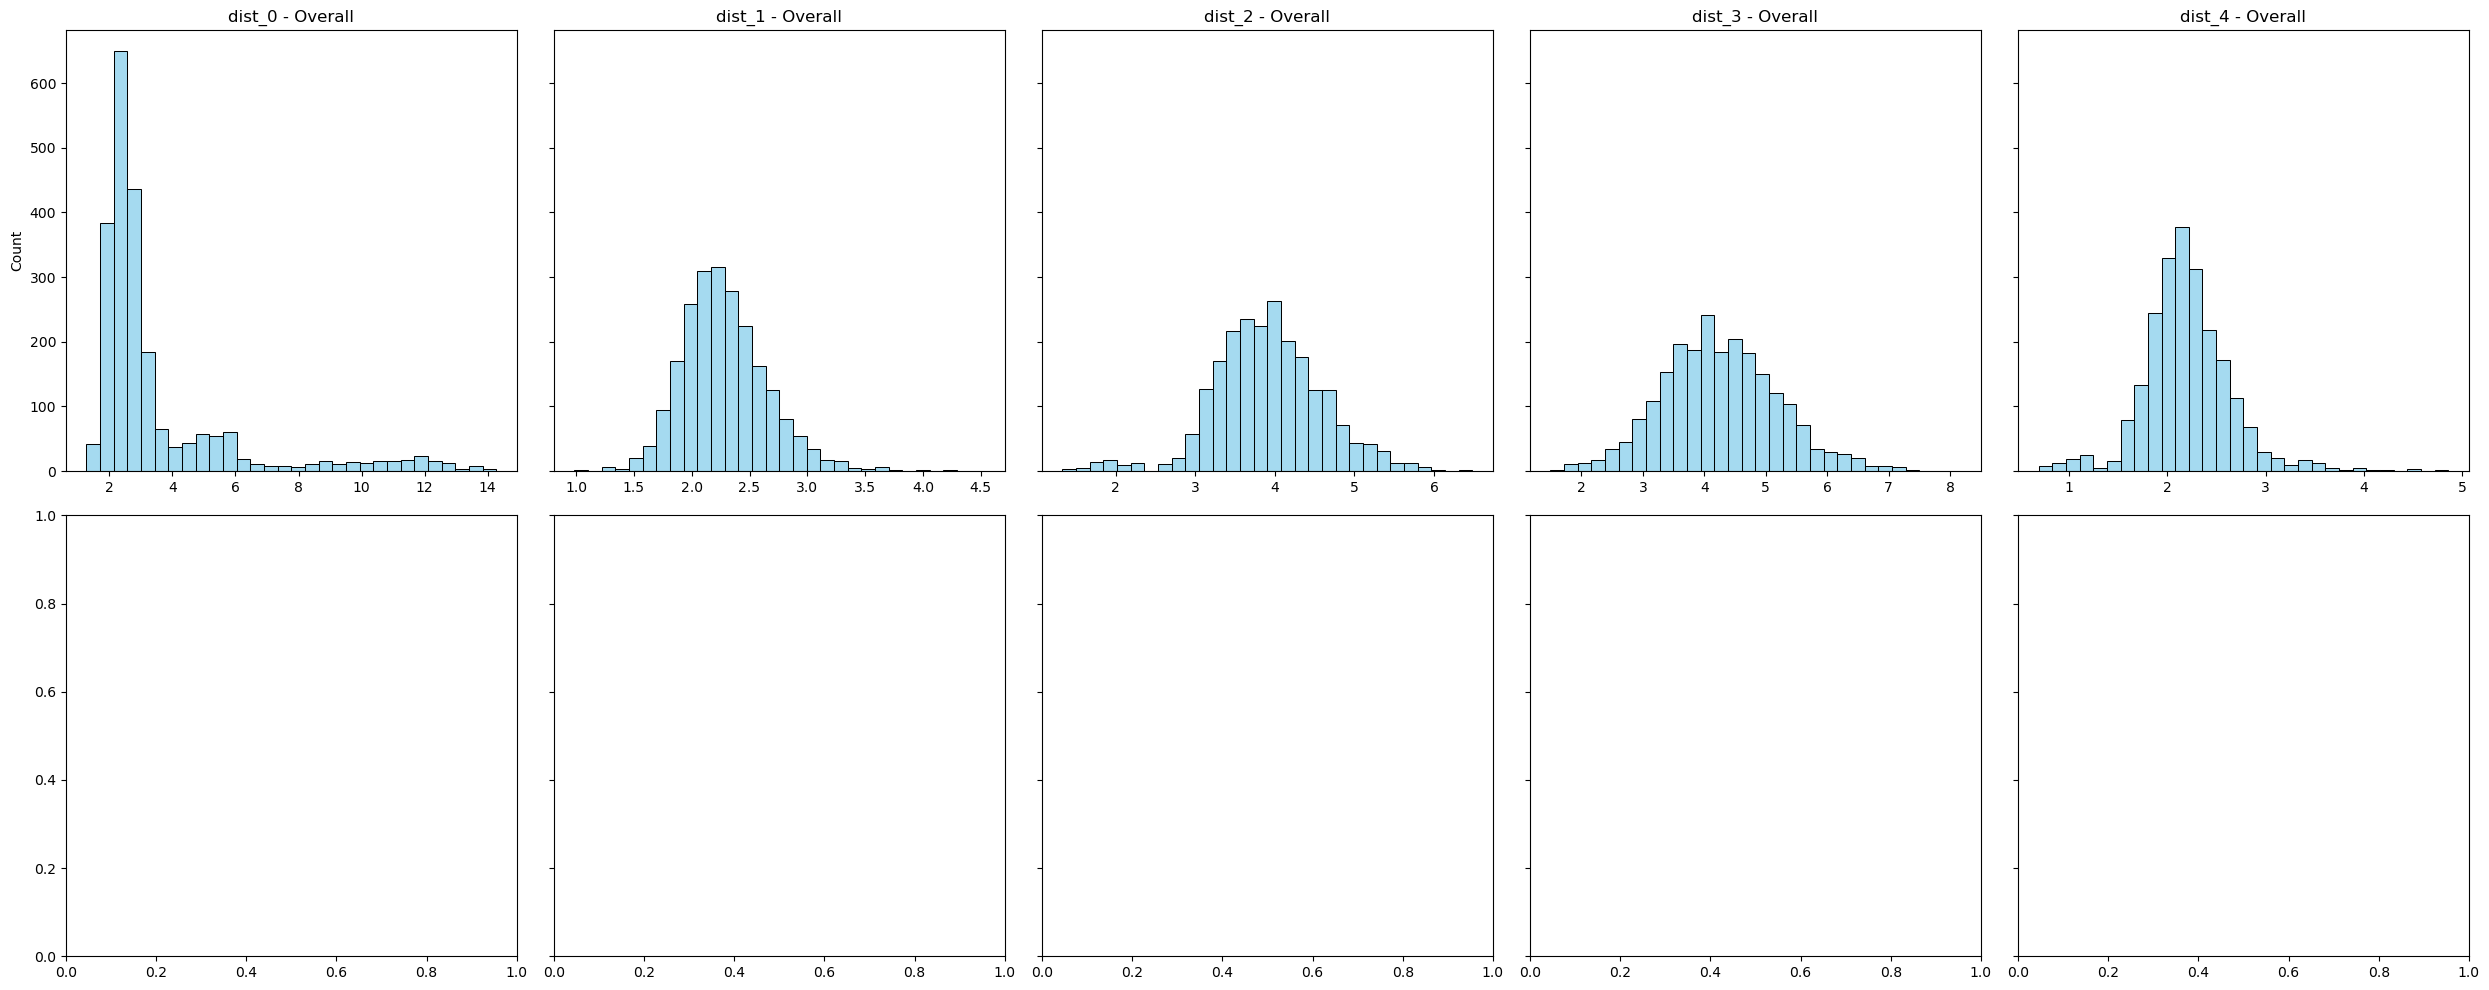

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,2.772022,2.132716,1.686165,0.258976,1.994962,0.309402,2.319350,0.363435,1.050904,0.167615
1.0,3.467494,2.731597,2.401618,0.371765,4.058285,0.491459,3.716565,0.769729,2.008618,0.313455
2.0,2.884497,1.089704,2.320635,0.346304,4.230840,0.687817,4.507546,0.956640,2.014290,0.344779
3.0,2.696986,0.969476,2.196442,0.212744,3.552499,0.541054,3.723574,0.530780,2.322180,0.409189
4.0,3.736949,2.299026,2.214091,0.234890,3.853249,0.608239,4.313134,0.871511,2.253512,0.378361
...,...,...,...,...,...,...,...,...,...,...
62.0,2.764402,1.058316,2.553670,0.429600,3.832398,0.578358,3.607911,0.657933,2.234426,0.372871
63.0,4.160499,3.017436,2.277611,0.353921,3.765795,0.436053,3.928502,0.830350,2.170794,0.344187
64.0,2.815710,1.636458,2.312763,0.374929,3.526984,0.451703,4.582965,0.655203,2.281345,0.375423


In [146]:
merged_df = process_merge(paths, 330, normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [147]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0031545741324921135
Size of Union: 951
Size of Intersection: 3


#### Bottom 10% Per Class

In [148]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 995
Size of Intersection: 0


### Unnormalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


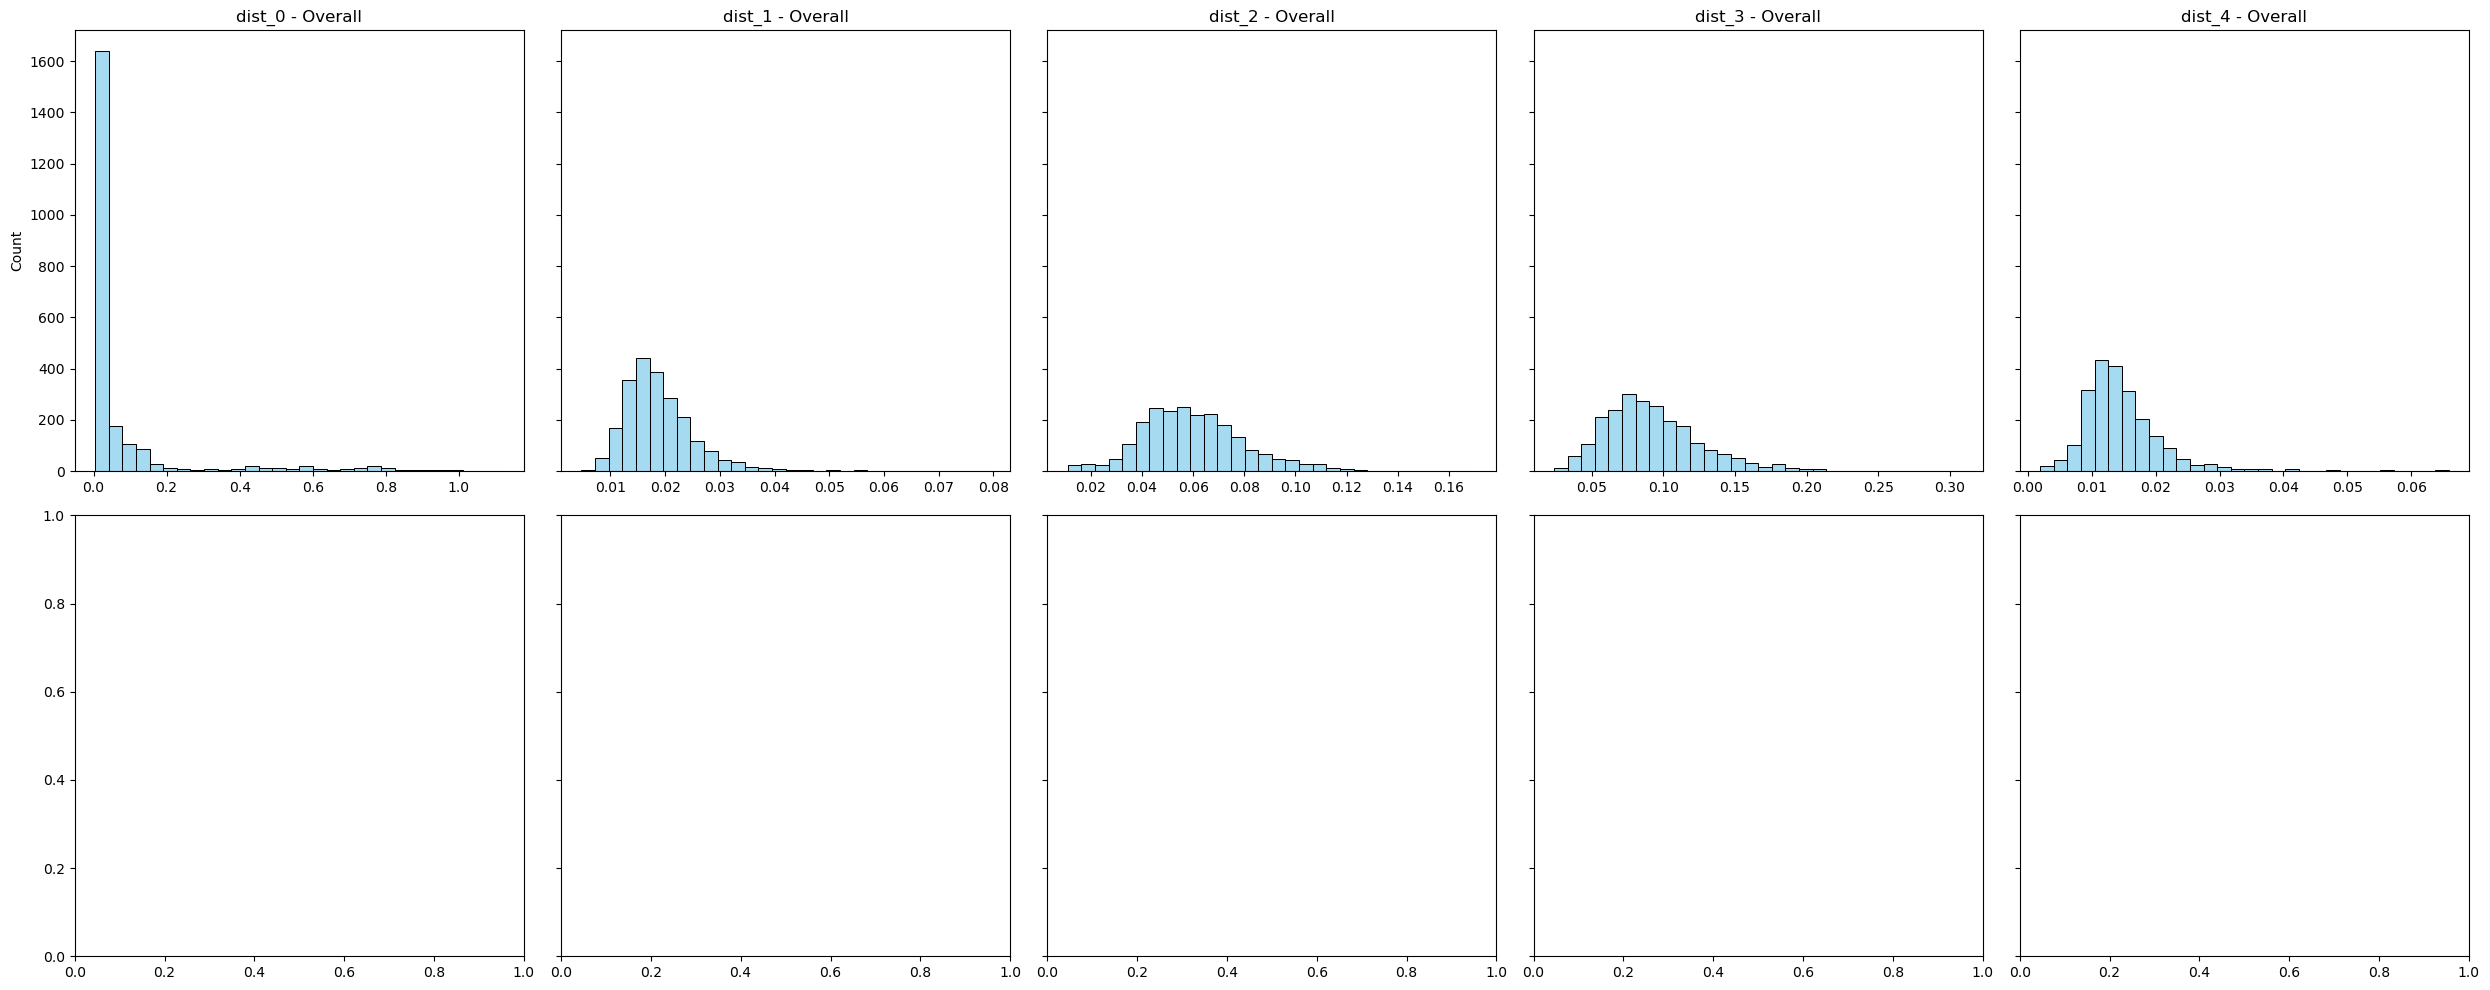

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.059321,0.128492,0.011620,0.003364,0.018941,0.004953,0.041765,0.008801,0.004882,0.001420
1.0,0.080919,0.165862,0.021682,0.006809,0.067197,0.017082,0.075291,0.023868,0.012553,0.003886
2.0,0.039786,0.029719,0.019927,0.006253,0.065937,0.019833,0.099695,0.036151,0.012924,0.004734
3.0,0.033465,0.024719,0.016357,0.003732,0.048500,0.016539,0.072193,0.016960,0.016391,0.006202
4.0,0.085202,0.140480,0.017166,0.003715,0.055407,0.020187,0.097440,0.041699,0.015459,0.005380
...,...,...,...,...,...,...,...,...,...,...
62.0,0.037796,0.027807,0.022027,0.006802,0.057006,0.017370,0.068320,0.023057,0.014373,0.004424
63.0,0.119076,0.225575,0.019462,0.005795,0.055315,0.012249,0.077446,0.022802,0.014770,0.004636
64.0,0.040692,0.061209,0.019179,0.005810,0.050921,0.015609,0.104043,0.032957,0.016054,0.005890


In [149]:
merged_df = process_merge(paths, 330, distance_metric = 'cosine', normalization = 'none')
graph_hists(merged_df)

#### Top 10% Per Class

In [150]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002066115702479339
Size of Union: 968
Size of Intersection: 2


#### Bottom 10% Per Class

In [151]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 1015
Size of Intersection: 0


### Class Normalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


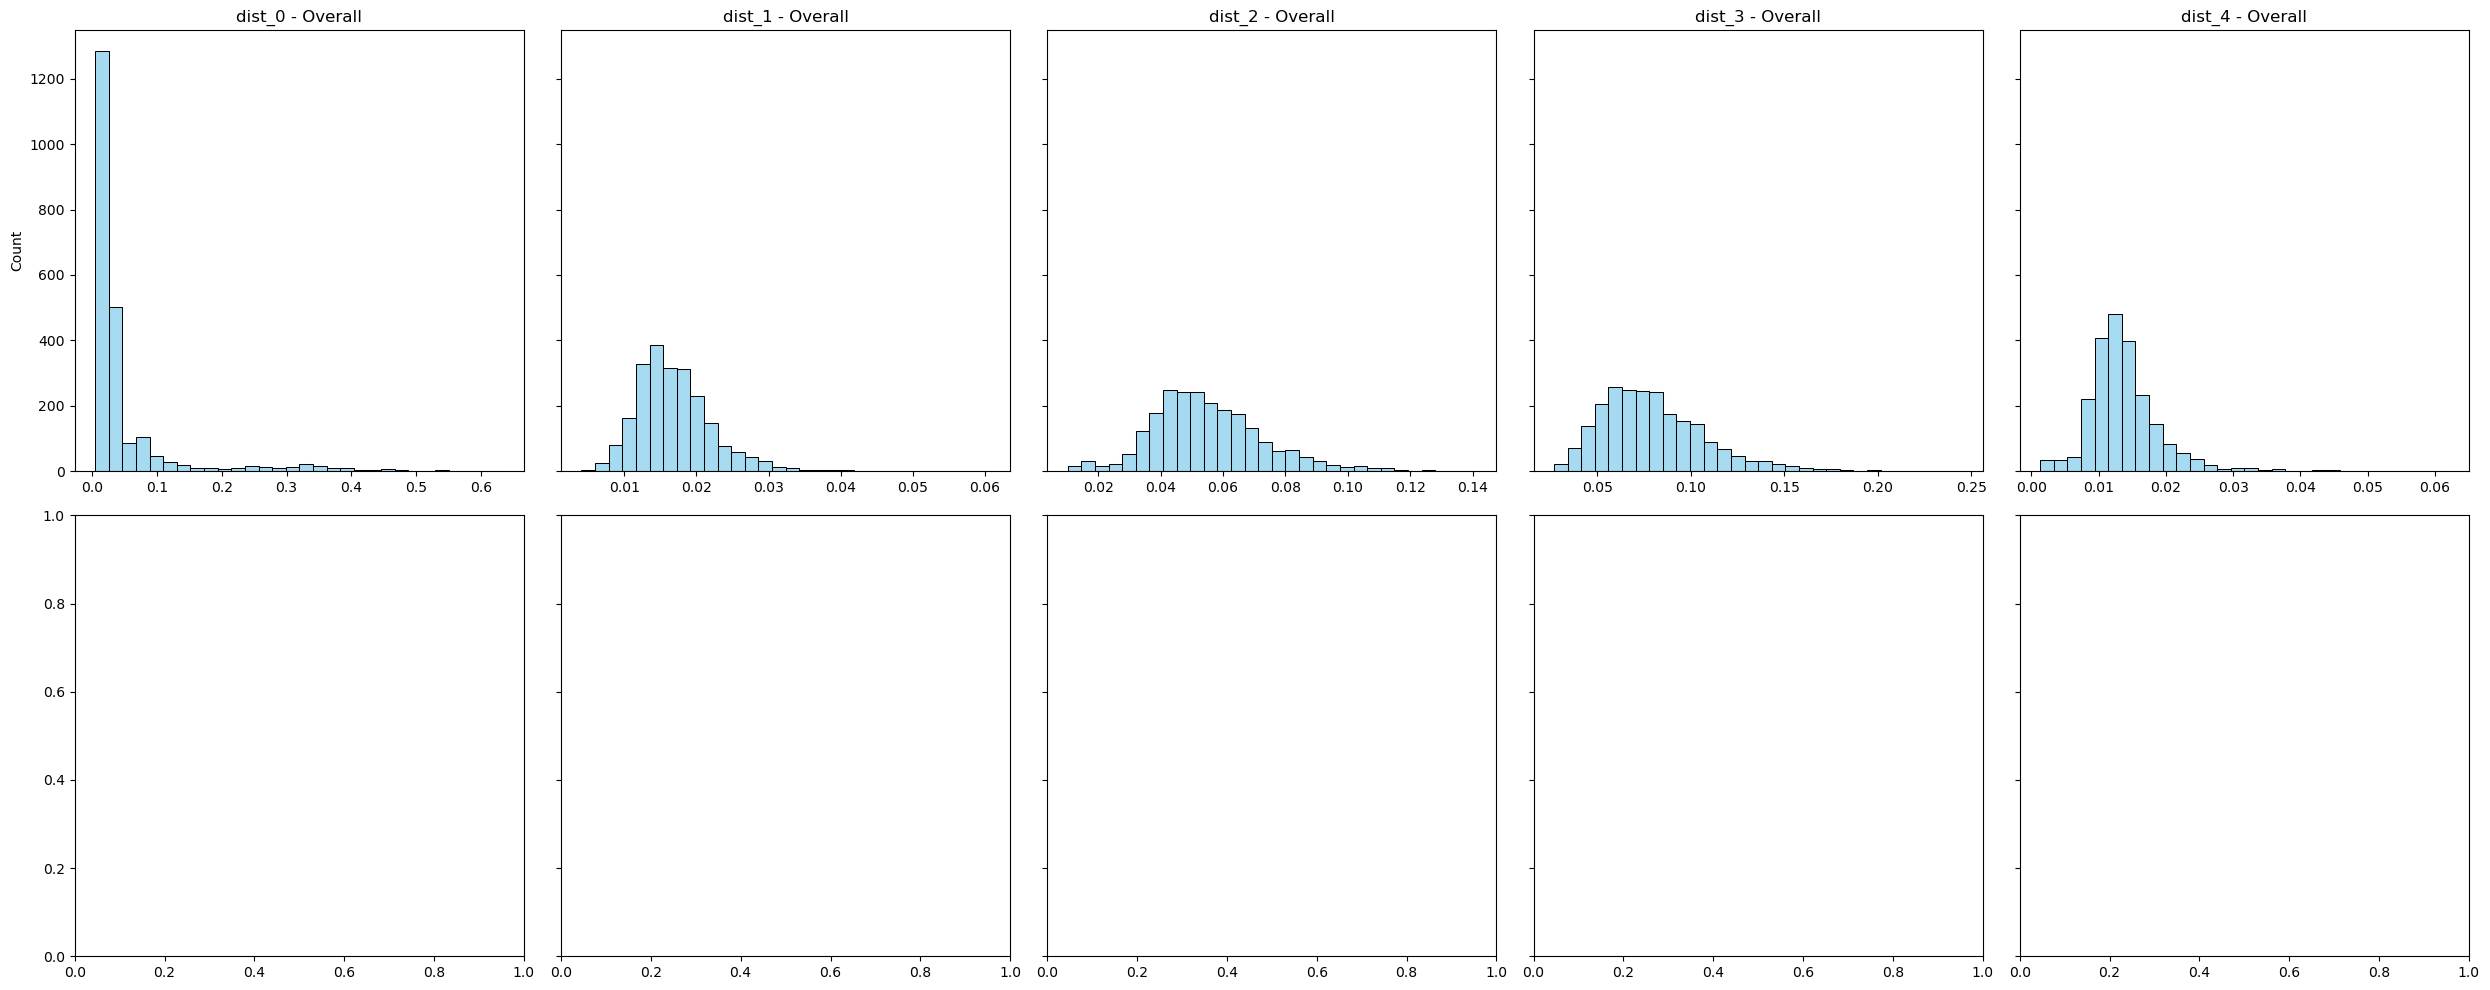

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.024139,0.038157,0.009116,0.002255,0.017383,0.004328,0.042549,0.007988,0.003455,0.000963
1.0,0.055544,0.089818,0.018038,0.005036,0.056962,0.014814,0.062660,0.017611,0.010664,0.002904
2.0,0.025958,0.013741,0.018099,0.005456,0.062494,0.017252,0.079089,0.023024,0.011646,0.003689
3.0,0.024229,0.013341,0.015504,0.003180,0.050791,0.015728,0.059014,0.013594,0.015718,0.004984
4.0,0.047356,0.059809,0.015087,0.002895,0.056934,0.019625,0.084460,0.030714,0.014243,0.004128
...,...,...,...,...,...,...,...,...,...,...
62.0,0.025218,0.013359,0.019625,0.005690,0.052049,0.014778,0.059866,0.017122,0.013995,0.004258
63.0,0.069766,0.107084,0.017566,0.004814,0.049101,0.010066,0.076107,0.021677,0.014504,0.004640
64.0,0.030031,0.037290,0.018483,0.005385,0.046456,0.013598,0.093736,0.024123,0.015594,0.004841


In [152]:
merged_df = process_merge(paths, 330, distance_metric = 'cosine', normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [153]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.002105263157894737
Size of Union: 950
Size of Intersection: 2


#### Bottom 10% Per Class

In [154]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 1000
Size of Intersection: 0


### Global Normalize Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


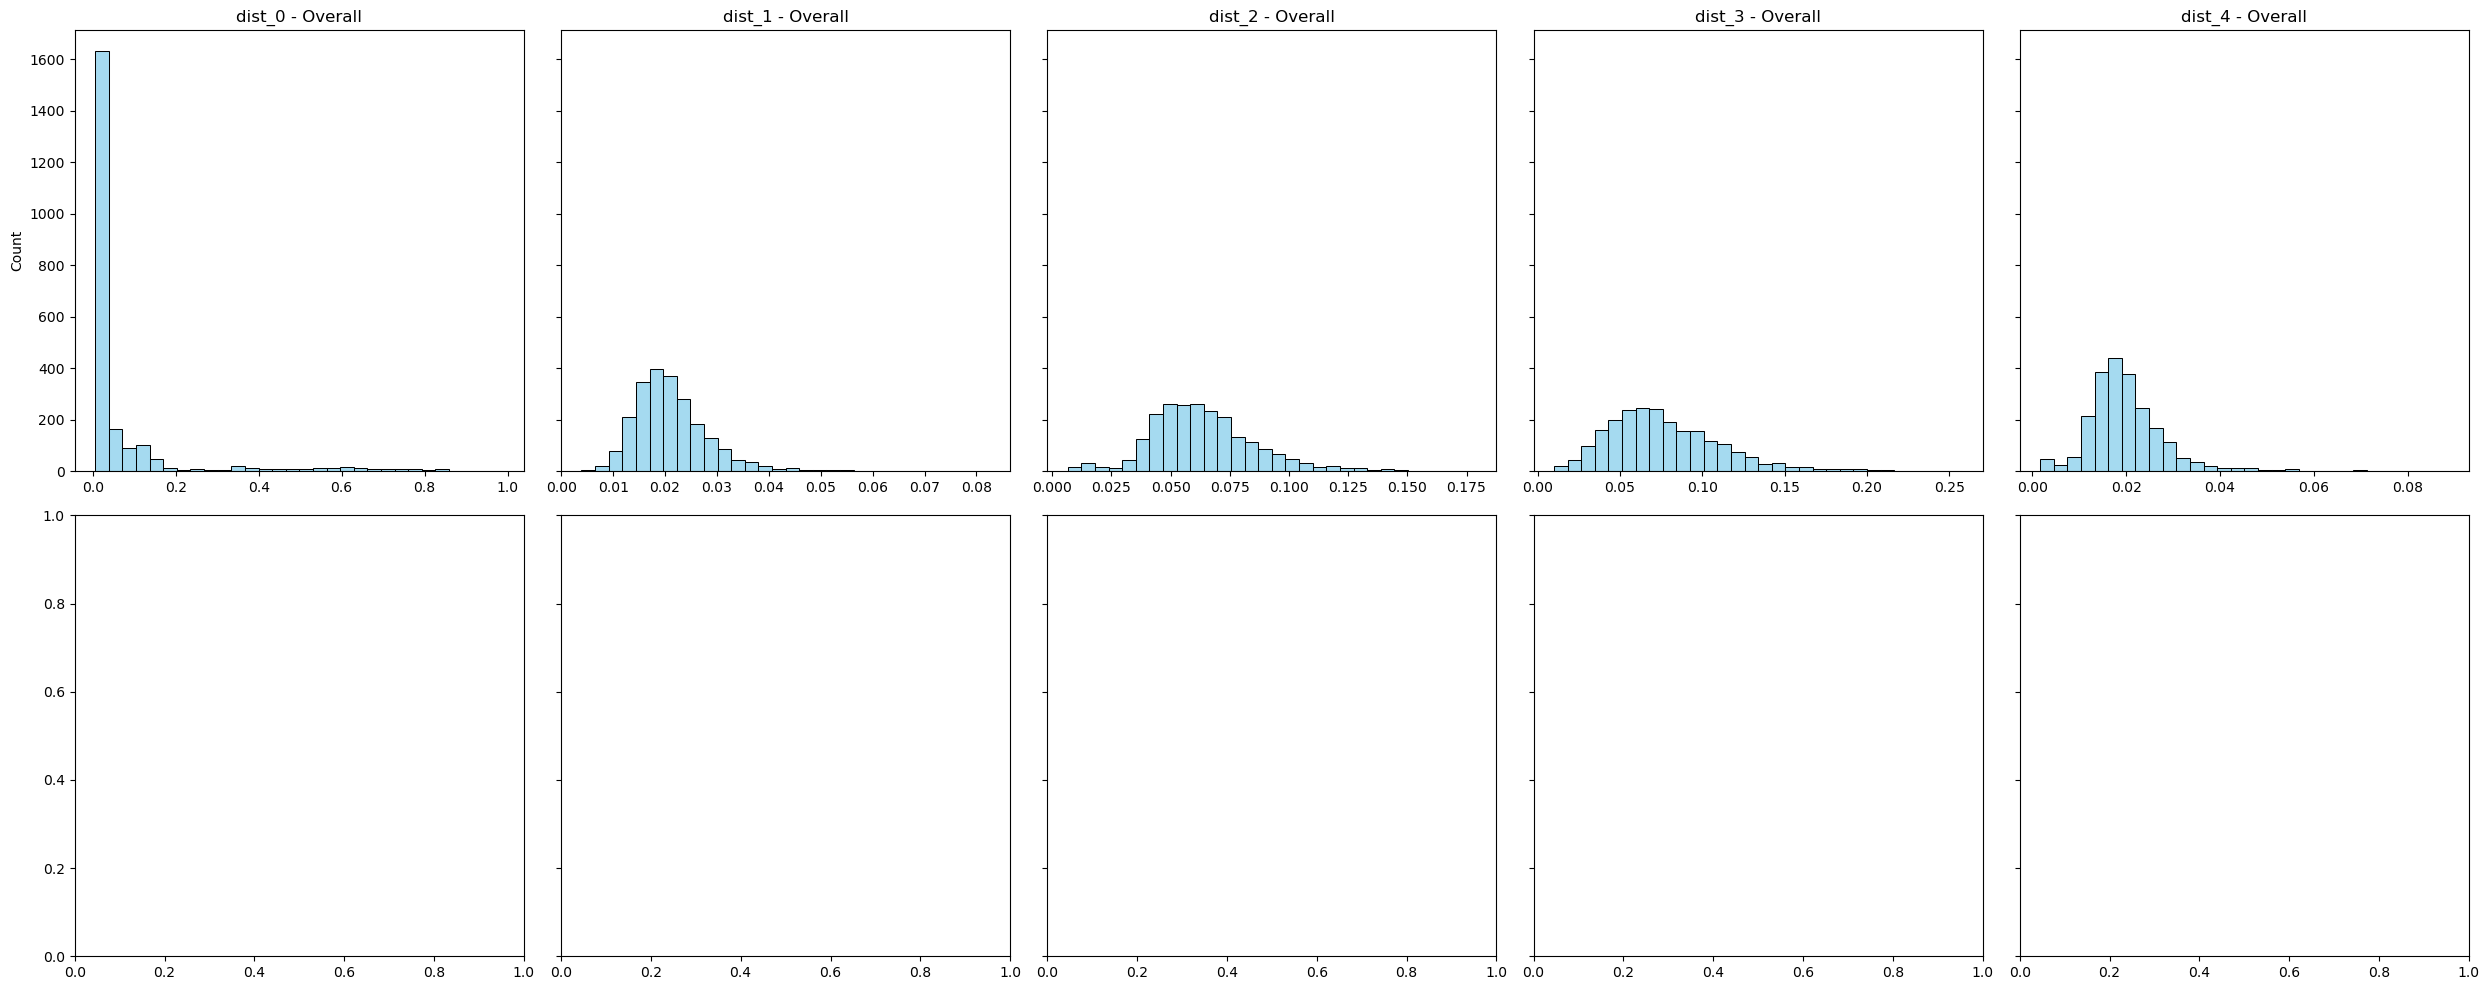

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.051695,0.099071,0.011464,0.003421,0.015419,0.004918,0.023879,0.007776,0.003972,0.001244
1.0,0.085420,0.177281,0.022571,0.007322,0.062963,0.016667,0.056914,0.024143,0.016346,0.005021
2.0,0.038489,0.031544,0.021390,0.006652,0.071766,0.024587,0.086468,0.038938,0.016373,0.005592
3.0,0.030982,0.024549,0.020853,0.004146,0.056800,0.018471,0.050705,0.015048,0.021879,0.007444
4.0,0.081348,0.123273,0.020456,0.004511,0.069840,0.022463,0.079536,0.034678,0.020286,0.006747
...,...,...,...,...,...,...,...,...,...,...
62.0,0.036084,0.030083,0.027373,0.009508,0.061847,0.018797,0.050575,0.019124,0.020400,0.006831
63.0,0.112726,0.219526,0.019751,0.006209,0.059723,0.014169,0.067449,0.027596,0.019146,0.006120
64.0,0.045556,0.070057,0.022407,0.007692,0.056385,0.015665,0.094111,0.029531,0.021452,0.007242


In [155]:
merged_df = process_merge(paths, 330, distance_metric = 'cosine', normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [156]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.003125
Size of Union: 960
Size of Intersection: 3


#### Bottom 10% Per Class

In [157]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 996
Size of Intersection: 0


In [158]:
67 * 67

4489

## Start of Convergence (Epoch 75)

In [159]:
all_idxs = []
epoch = 75
for i, path in enumerate(paths):
    dat = torch.load(path + str(epoch), map_location=torch.device('cpu'), weights_only=True)
    print(dat.shape)
    labels = dat[: , LABEL_INDEX]
    y_hats = dat[: , Y_HAT_INDEX]
    idx = dat[: , IDX_INDEX]
    all_idxs.append(idx)
    activations = dat[: , :-3]

intersection_all = reduce(np.intersect1d, all_idxs)
union_all = reduce(np.union1d, all_idxs)
len(intersection_all) == len(union_all)

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


True

### Unnormalized L2 distance from class means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


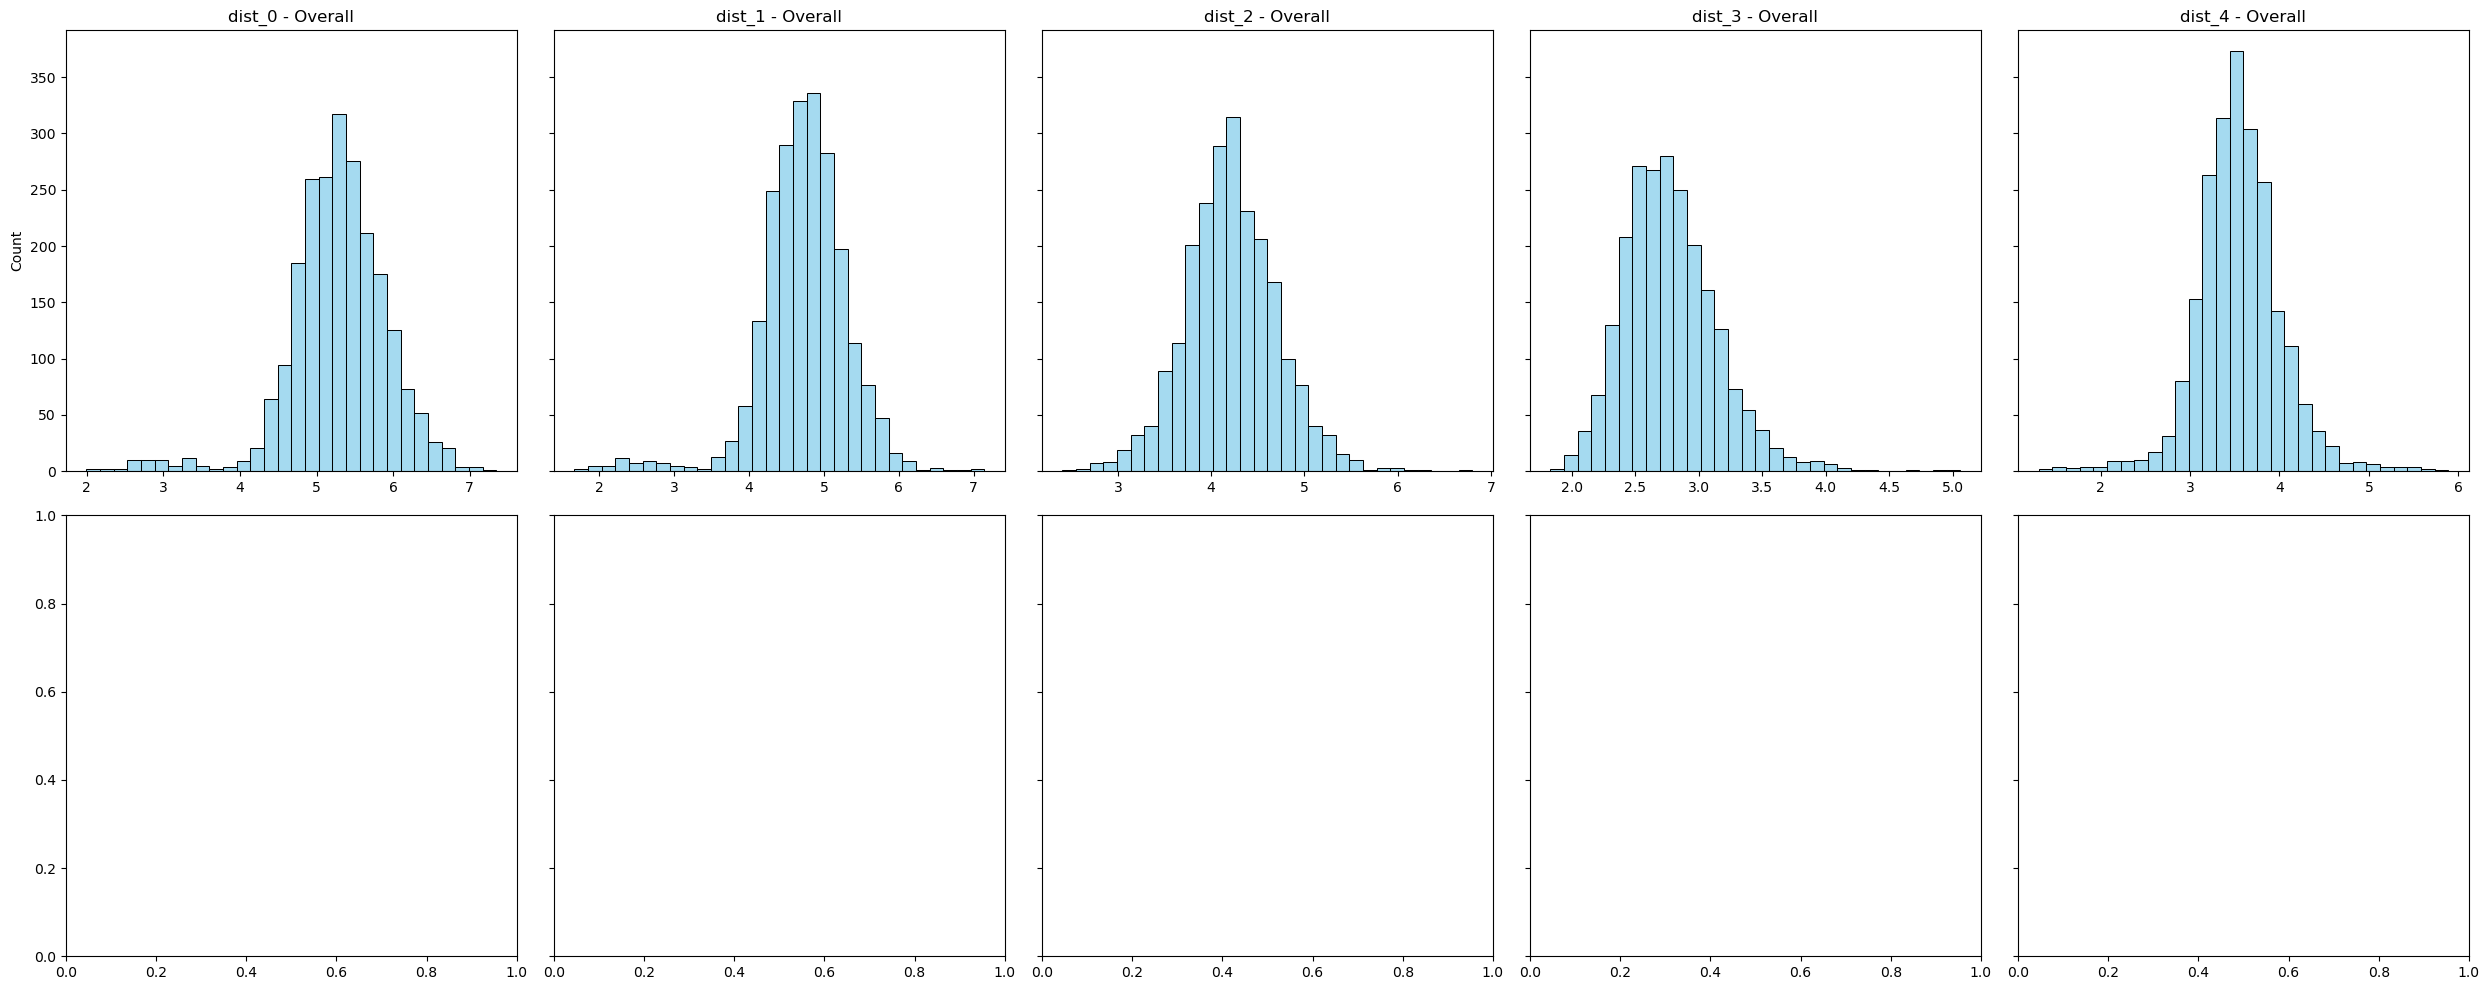

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,3.076712,0.496190,2.709539,0.566895,3.202550,0.358963,2.771603,0.410753,2.328058,0.457016
1.0,5.278418,0.386338,4.754716,0.513095,4.094978,0.353002,2.786535,0.329589,3.501561,0.425626
2.0,5.245834,0.527795,4.877234,0.416956,4.147307,0.429413,2.731501,0.321861,3.616439,0.348828
3.0,5.431684,0.467356,5.072553,0.471752,4.167348,0.435915,2.798190,0.308604,3.554997,0.324406
4.0,5.048277,0.517644,4.846707,0.396708,4.253033,0.500766,2.777154,0.264465,3.576951,0.437693
...,...,...,...,...,...,...,...,...,...,...
62.0,5.263524,0.448664,4.815822,0.371399,4.323647,0.374214,2.757401,0.385575,3.697151,0.419811
63.0,5.334982,0.398774,4.583179,0.490587,4.343908,0.387231,2.724100,0.363323,3.610475,0.337494
64.0,5.190264,0.538081,4.878189,0.365931,4.268998,0.660332,2.769589,0.323053,3.686962,0.416096


In [160]:
merged_df = process_merge(paths, 165)
graph_hists(merged_df)

#### Top 10% Per Class

In [161]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.012318029115341545
Size of Union: 893
Size of Intersection: 11


#### Bottom 10% Per Class

In [162]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 950
Size of Intersection: 0


#### Highest 10% STD Per Class

### Class Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


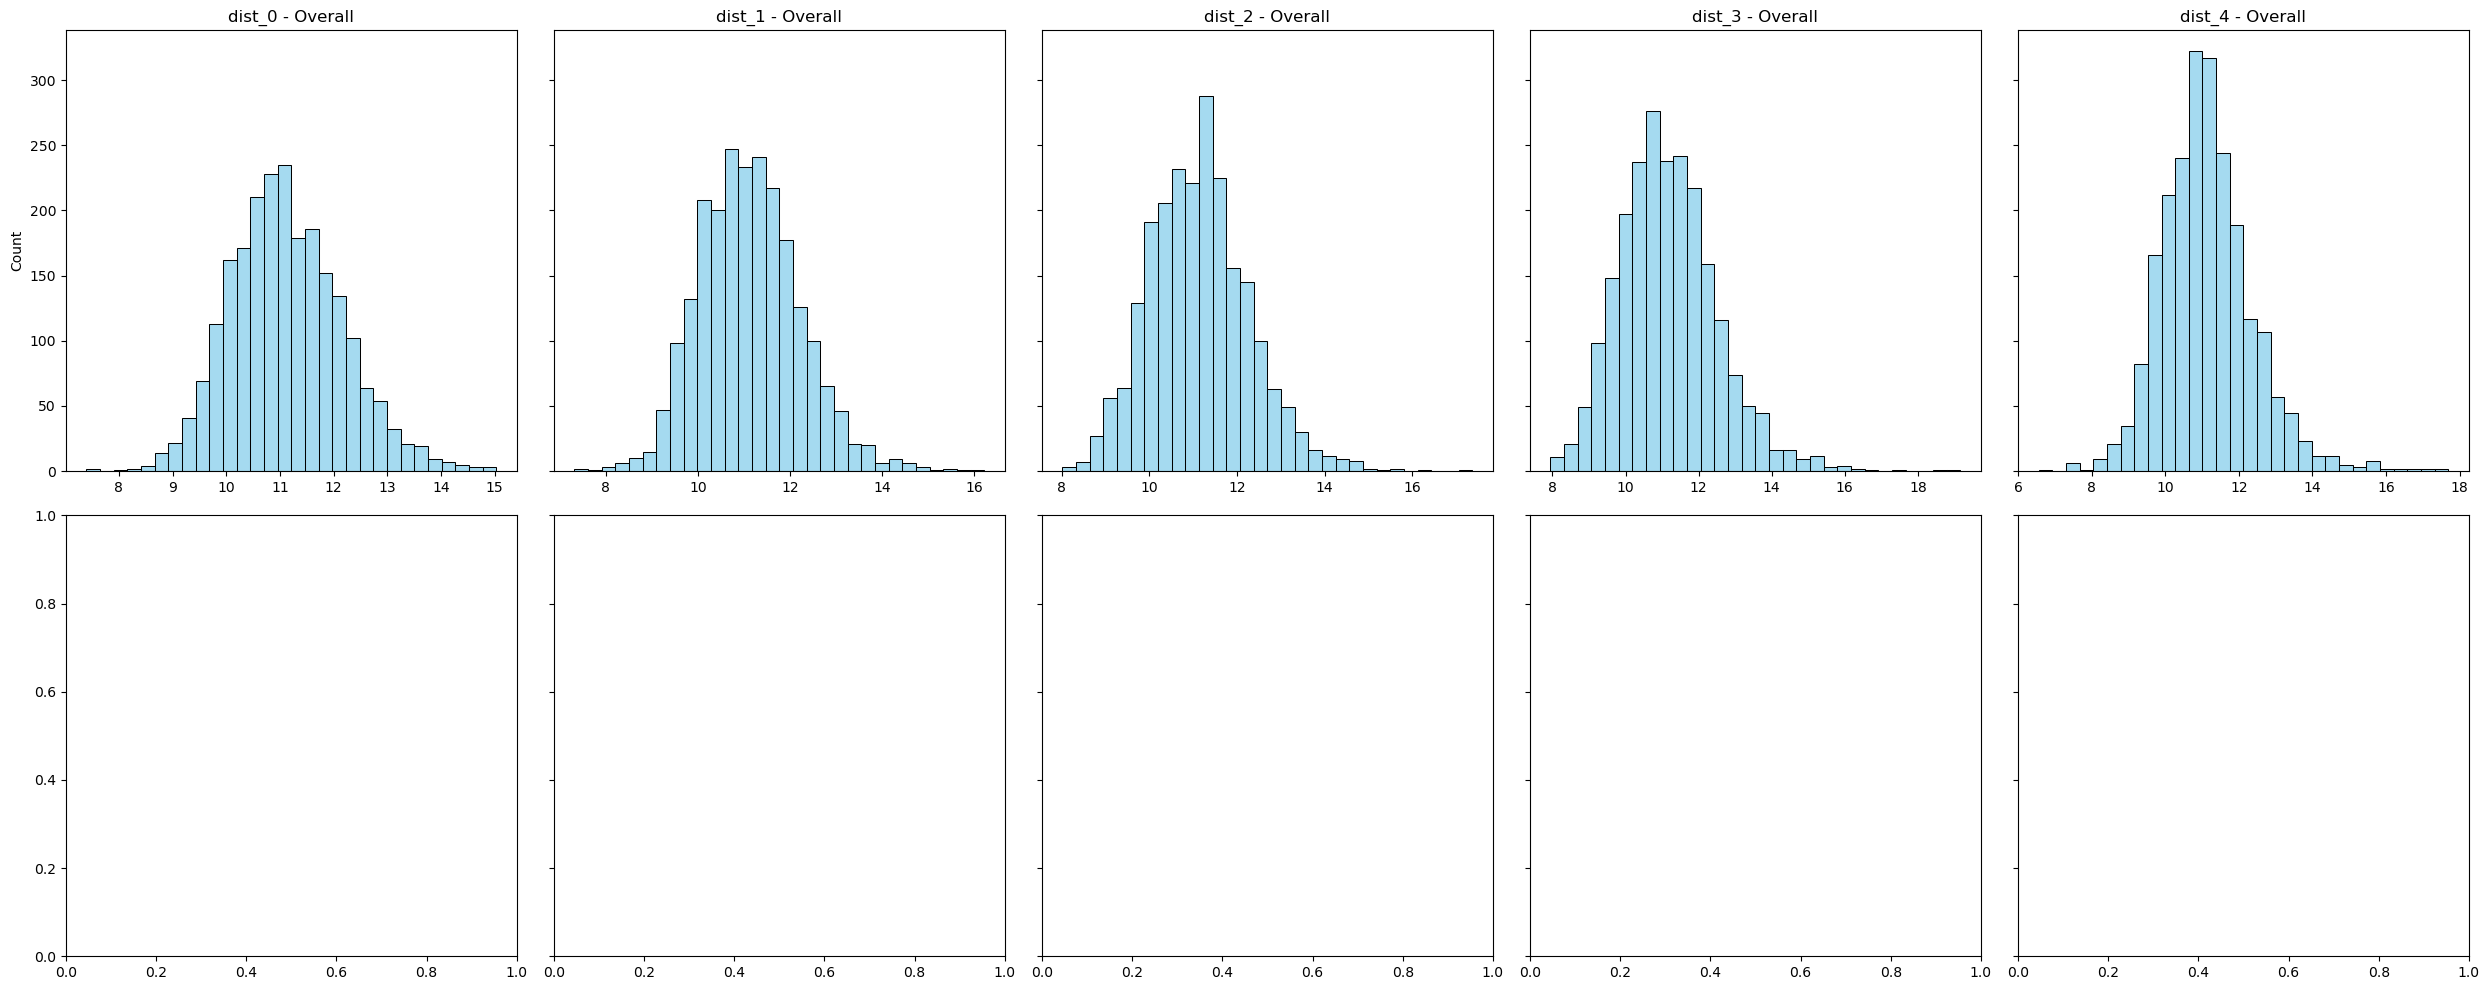

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,11.183280,1.736276,11.142983,2.114498,11.255356,1.253852,11.271673,1.504563,11.183514,2.103860
1.0,11.128140,0.794963,11.103210,1.195698,11.153120,0.819841,11.178456,1.215303,11.120366,1.239381
2.0,11.088674,0.986158,11.094164,0.925936,11.099786,1.194710,11.161912,1.236056,11.104246,1.043929
3.0,11.125434,0.887017,11.121768,0.986447,11.127288,1.174130,11.186159,1.150936,11.152884,0.961331
4.0,11.132530,1.079721,11.145853,0.972494,11.129573,1.300118,11.230844,1.027472,11.146438,1.184343
...,...,...,...,...,...,...,...,...,...,...
62.0,11.116236,0.896449,11.119365,0.887919,11.129377,0.951750,11.141750,1.488637,11.109124,1.242873
63.0,11.161258,0.870653,11.143000,1.193317,11.174906,0.946987,11.201028,1.431793,11.184885,0.908131
64.0,11.129931,1.060552,11.149531,0.865531,11.076659,1.668300,11.181923,1.295763,11.139049,1.206574


In [163]:
merged_df = process_merge(paths, 165, normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [164]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.01598173515981735
Size of Union: 876
Size of Intersection: 14


#### Bottom 10% Per Class

In [165]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 926
Size of Intersection: 0


### Global Normalized L2 Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


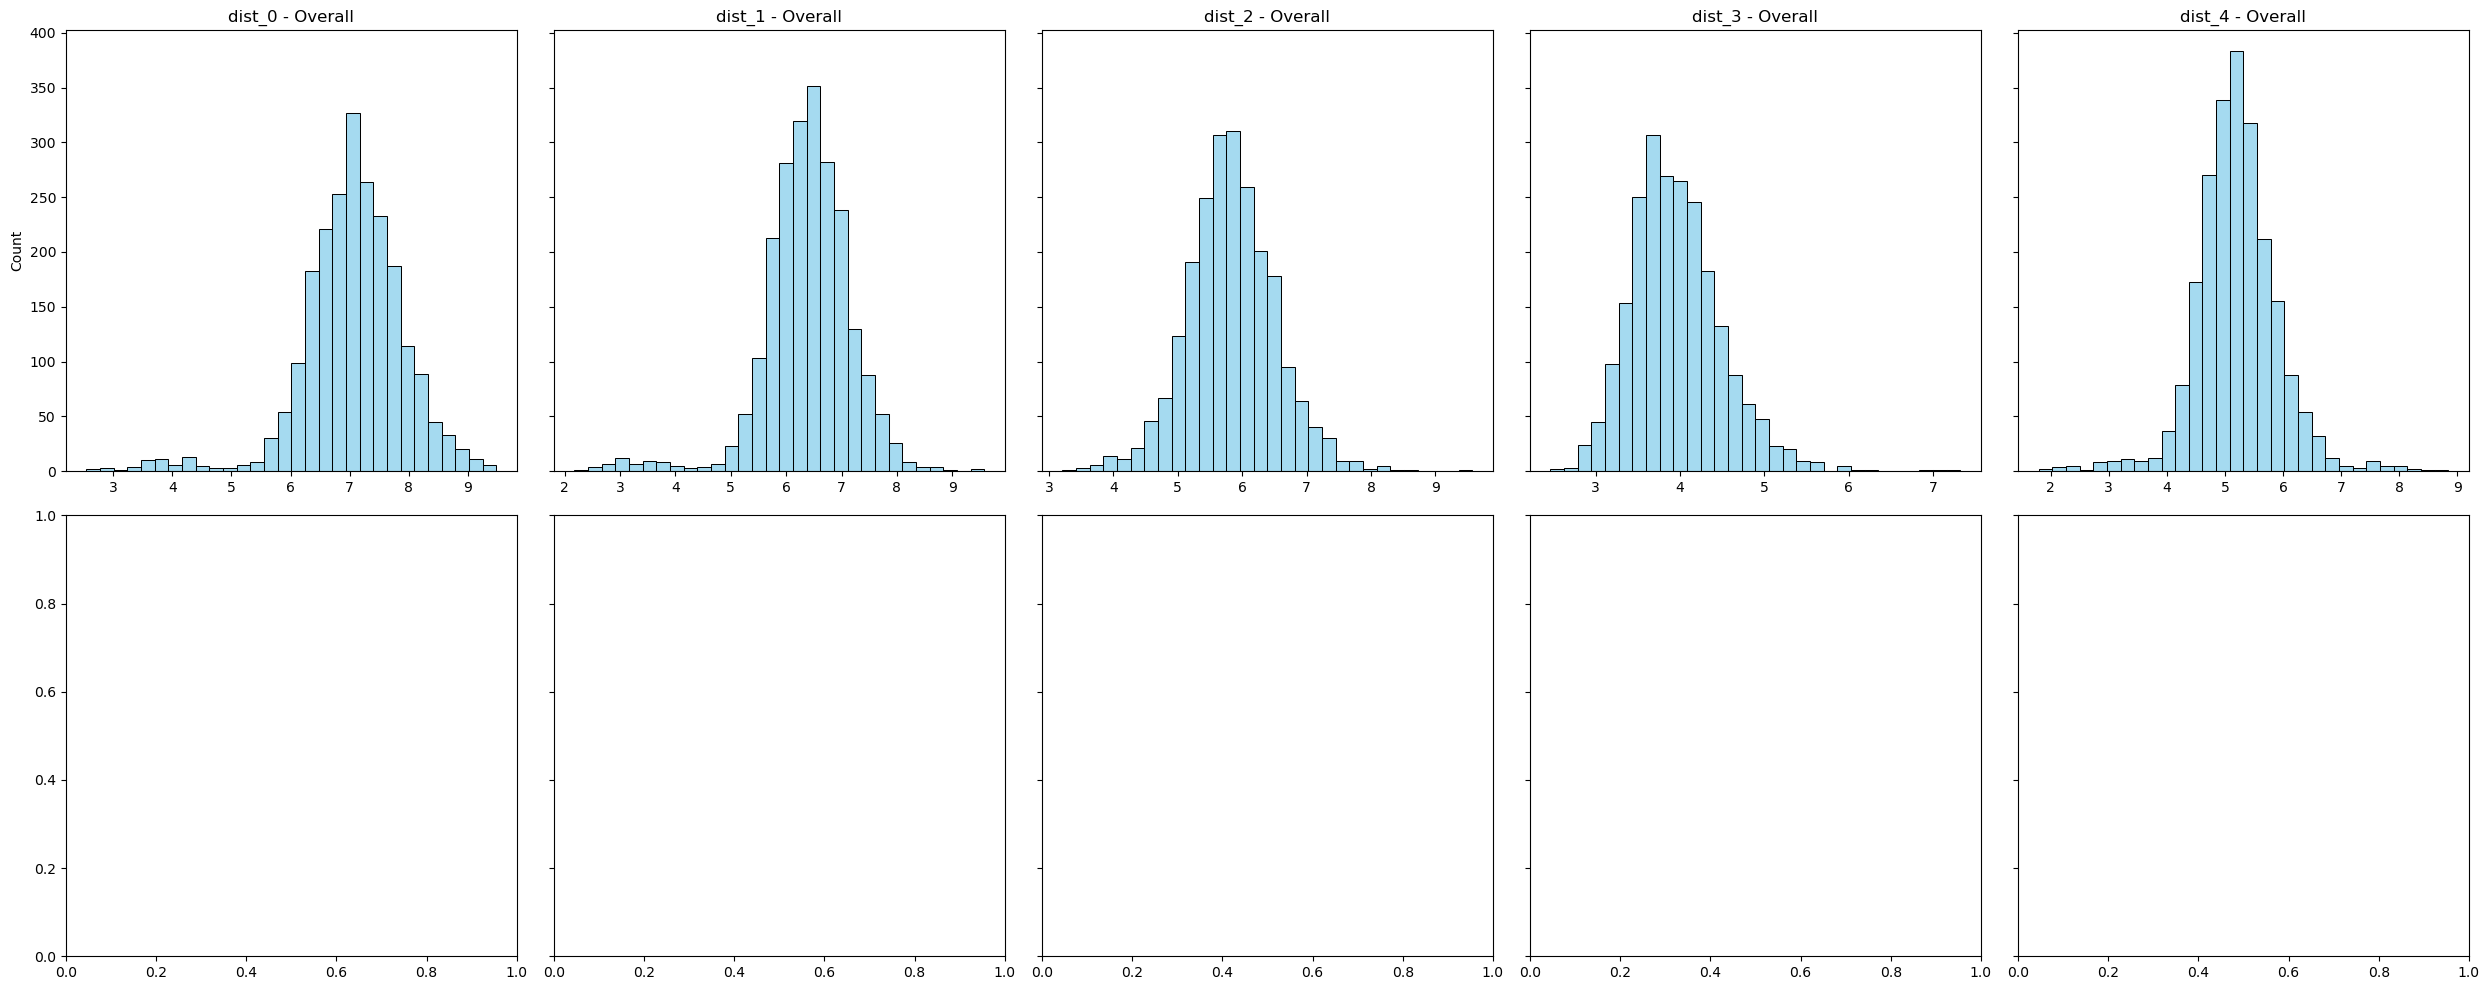

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,4.071069,0.679383,3.598530,0.748671,4.339156,0.510503,3.765244,0.550595,3.297171,0.649642
1.0,7.069585,0.460510,6.383555,0.684372,5.620963,0.473166,4.010079,0.453360,5.116895,0.634746
2.0,6.990946,0.664726,6.597570,0.574577,5.795748,0.594512,3.897507,0.431624,5.356810,0.494944
3.0,7.225581,0.621103,6.858773,0.608089,5.782494,0.612776,3.997520,0.452010,5.192929,0.497313
4.0,6.712637,0.715008,6.575051,0.510201,5.874354,0.721735,3.947000,0.353463,5.277223,0.621977
...,...,...,...,...,...,...,...,...,...,...
62.0,7.017131,0.611569,6.473595,0.497371,5.988820,0.550368,3.933037,0.509903,5.416303,0.637229
63.0,7.059860,0.537474,6.187643,0.635636,6.009238,0.541630,3.892582,0.524512,5.262694,0.468993
64.0,6.959671,0.692854,6.601643,0.483558,5.899429,0.945591,3.922492,0.474309,5.379409,0.620550


In [166]:
merged_df = process_merge(paths, 165, normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [167]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.014444444444444444
Size of Union: 900
Size of Intersection: 13


#### Bottom 10% Per Class

In [168]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.001053740779768177
Size of Union: 949
Size of Intersection: 1


### Unnormalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


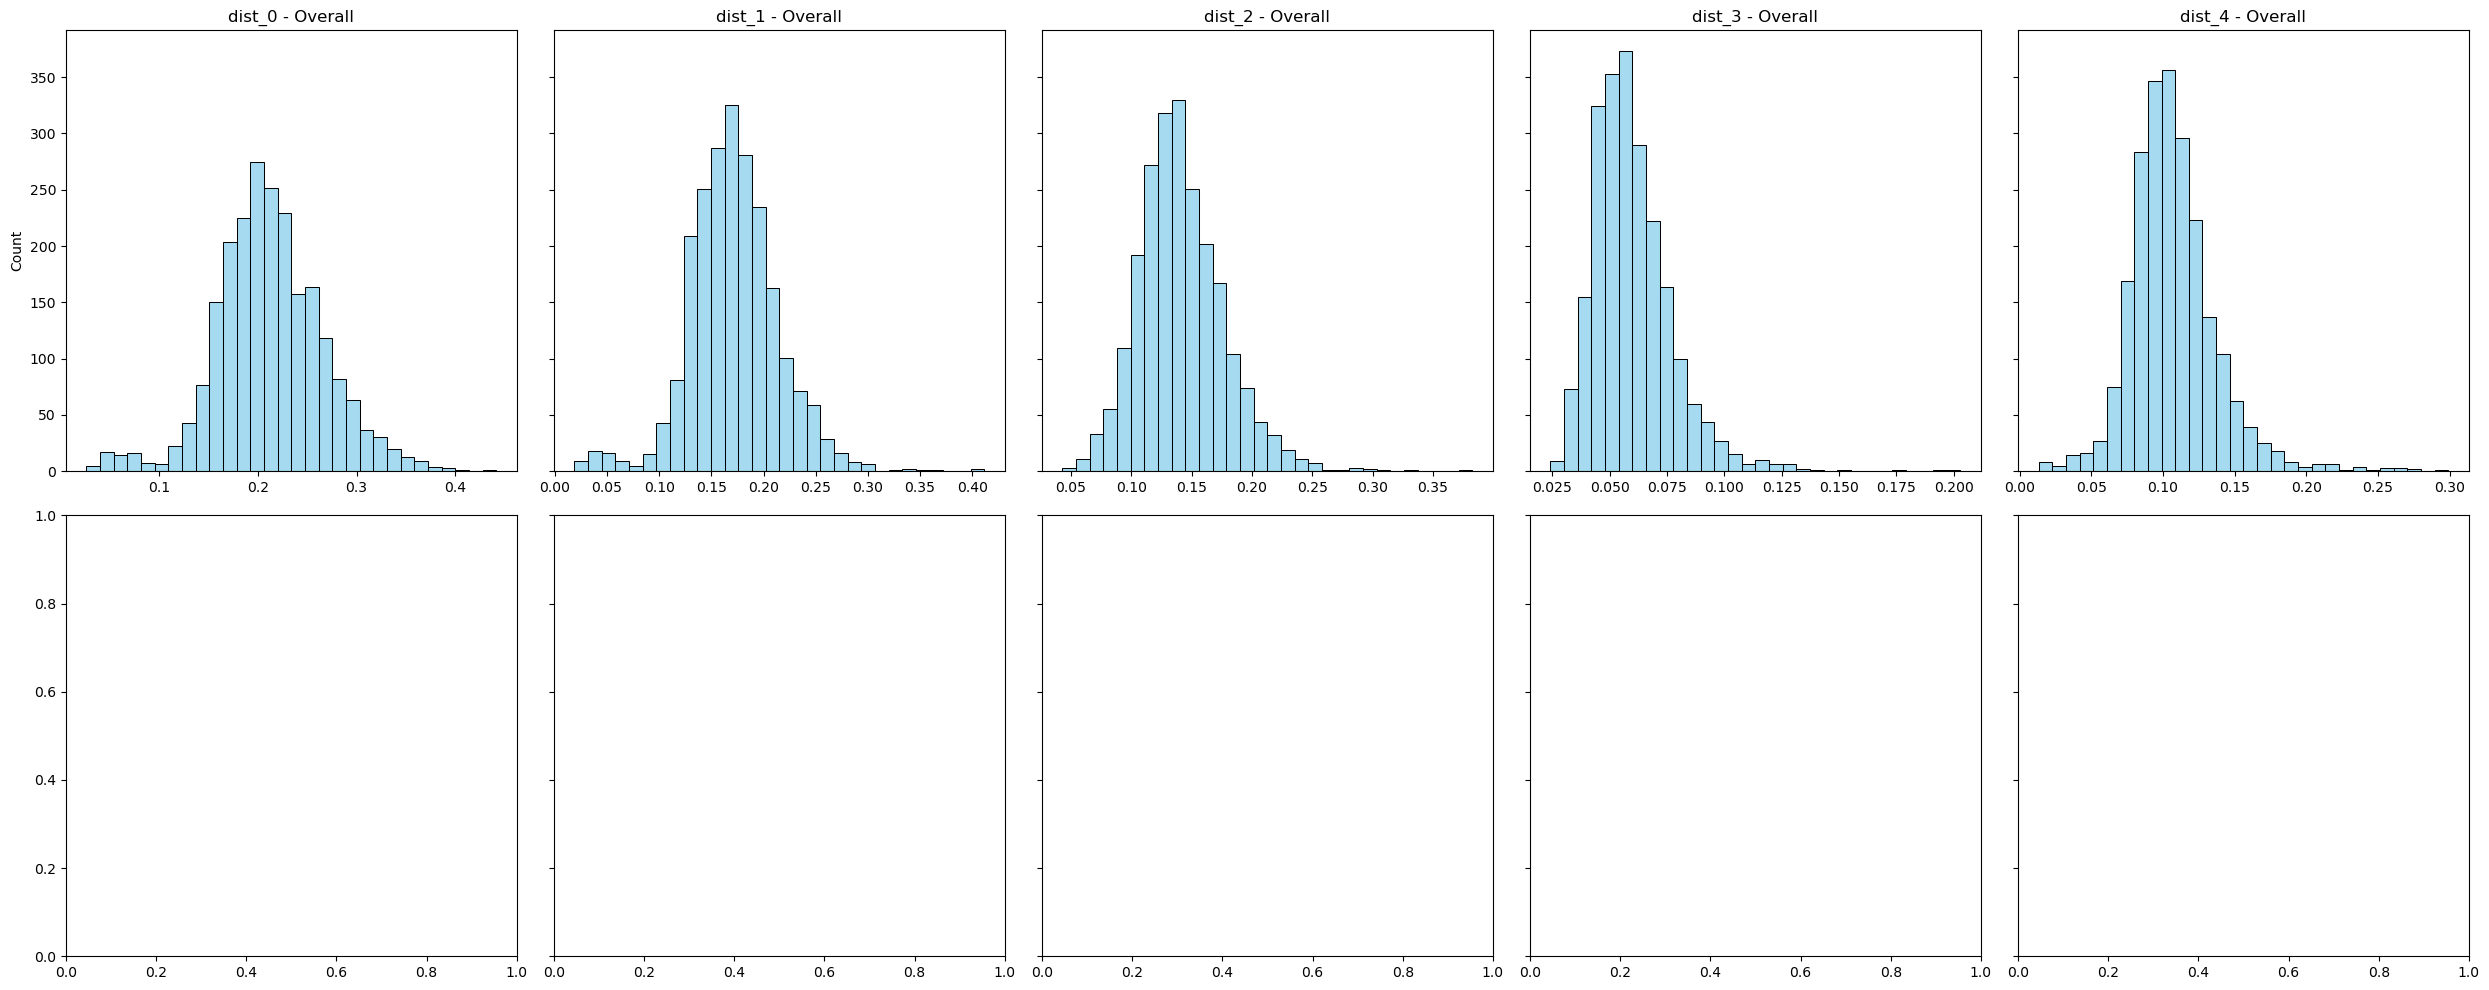

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.068580,0.023319,0.056049,0.024349,0.080845,0.019427,0.060936,0.019289,0.047206,0.018412
1.0,0.213085,0.034802,0.173479,0.041874,0.131659,0.024280,0.060538,0.014620,0.103854,0.026640
2.0,0.207664,0.048736,0.180408,0.034538,0.135660,0.030323,0.057461,0.014198,0.112863,0.023272
3.0,0.225916,0.042527,0.199146,0.041268,0.137069,0.030814,0.060672,0.013689,0.106163,0.020549
4.0,0.190874,0.044688,0.178229,0.033406,0.141701,0.037812,0.060194,0.012093,0.107591,0.028756
...,...,...,...,...,...,...,...,...,...,...
62.0,0.206162,0.041131,0.176317,0.029868,0.147690,0.027980,0.059281,0.017211,0.115086,0.028810
63.0,0.216822,0.038440,0.159359,0.037308,0.150331,0.028892,0.056823,0.015793,0.110633,0.022170
64.0,0.200549,0.047875,0.180572,0.030543,0.147380,0.053954,0.059674,0.013680,0.114135,0.027583


In [169]:
merged_df = process_merge(paths, 165, distance_metric = 'cosine', normalization = 'none')
graph_hists(merged_df)

#### Top 10% Per Class

In [170]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.012401352874859075
Size of Union: 887
Size of Intersection: 11


#### Bottom 10% Per Class

In [171]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0010548523206751054
Size of Union: 948
Size of Intersection: 1


### Class Normalized Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


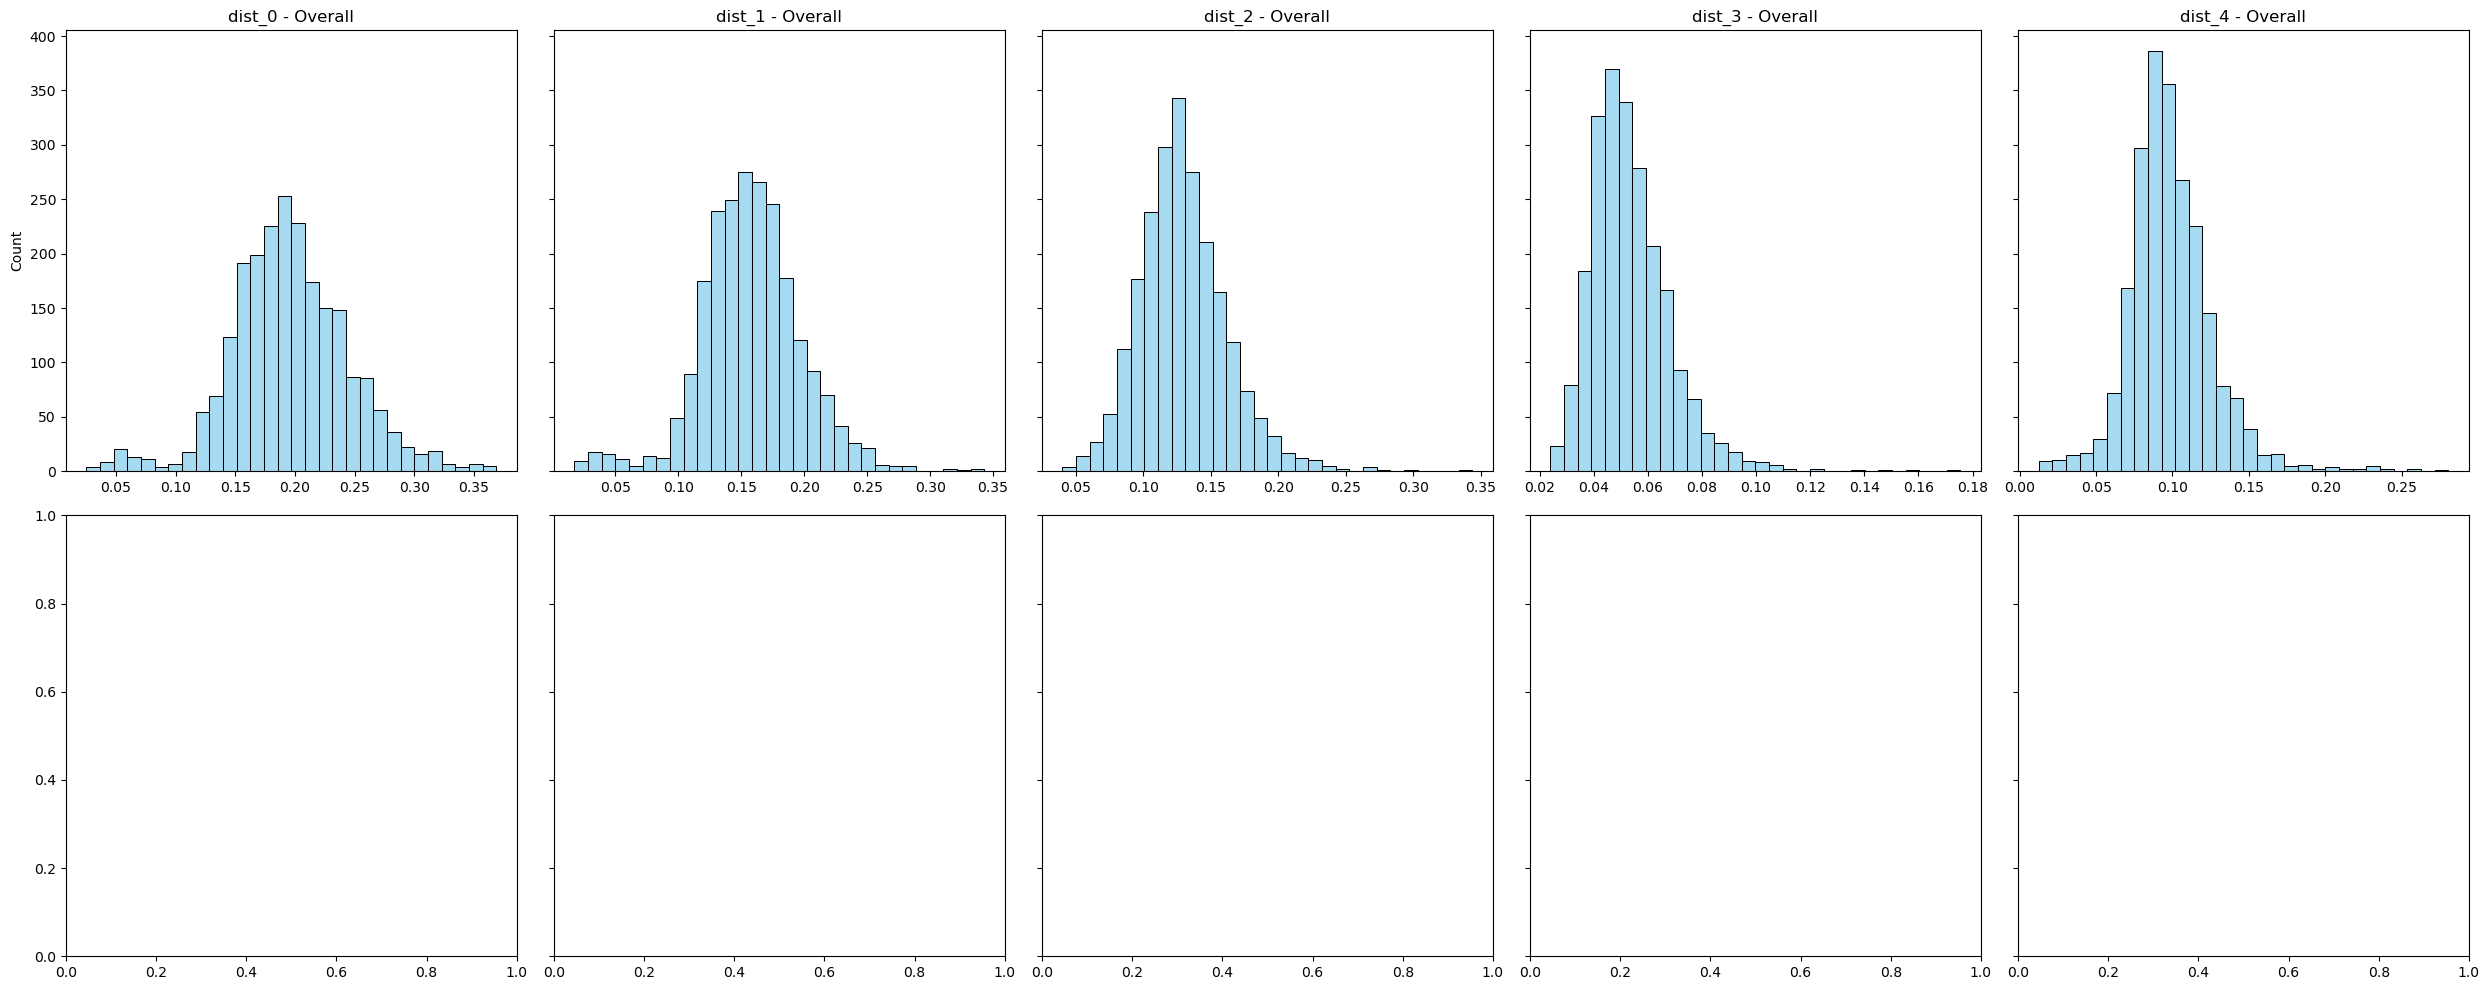

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.065291,0.020974,0.046131,0.018545,0.073576,0.017960,0.051320,0.014912,0.039947,0.014958
1.0,0.188138,0.030636,0.151878,0.035145,0.121537,0.018904,0.053682,0.011765,0.093645,0.022741
2.0,0.185607,0.041644,0.173041,0.031921,0.122811,0.027733,0.049205,0.011088,0.094764,0.019084
3.0,0.197502,0.038865,0.186614,0.038170,0.130169,0.028813,0.055123,0.011809,0.093850,0.016433
4.0,0.178009,0.039423,0.162980,0.031178,0.137256,0.035549,0.053166,0.010468,0.096834,0.022506
...,...,...,...,...,...,...,...,...,...,...
62.0,0.196986,0.038444,0.151065,0.026492,0.137941,0.025175,0.050724,0.013788,0.103073,0.025231
63.0,0.198724,0.034296,0.145612,0.035490,0.131856,0.025947,0.048313,0.013072,0.100822,0.016492
64.0,0.180590,0.039111,0.176231,0.030013,0.132836,0.048615,0.051626,0.012106,0.107591,0.025583


In [172]:
merged_df = process_merge(paths, 165, distance_metric = 'cosine', normalization = 'class')
graph_hists(merged_df)

#### Top 10% Per Class

In [173]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.01598173515981735
Size of Union: 876
Size of Intersection: 14


#### Bottom 10% Per Class

In [174]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 941
Size of Intersection: 0


### Global Normalize Cosine Distance From Class Means

torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])
torch.Size([2244, 131])


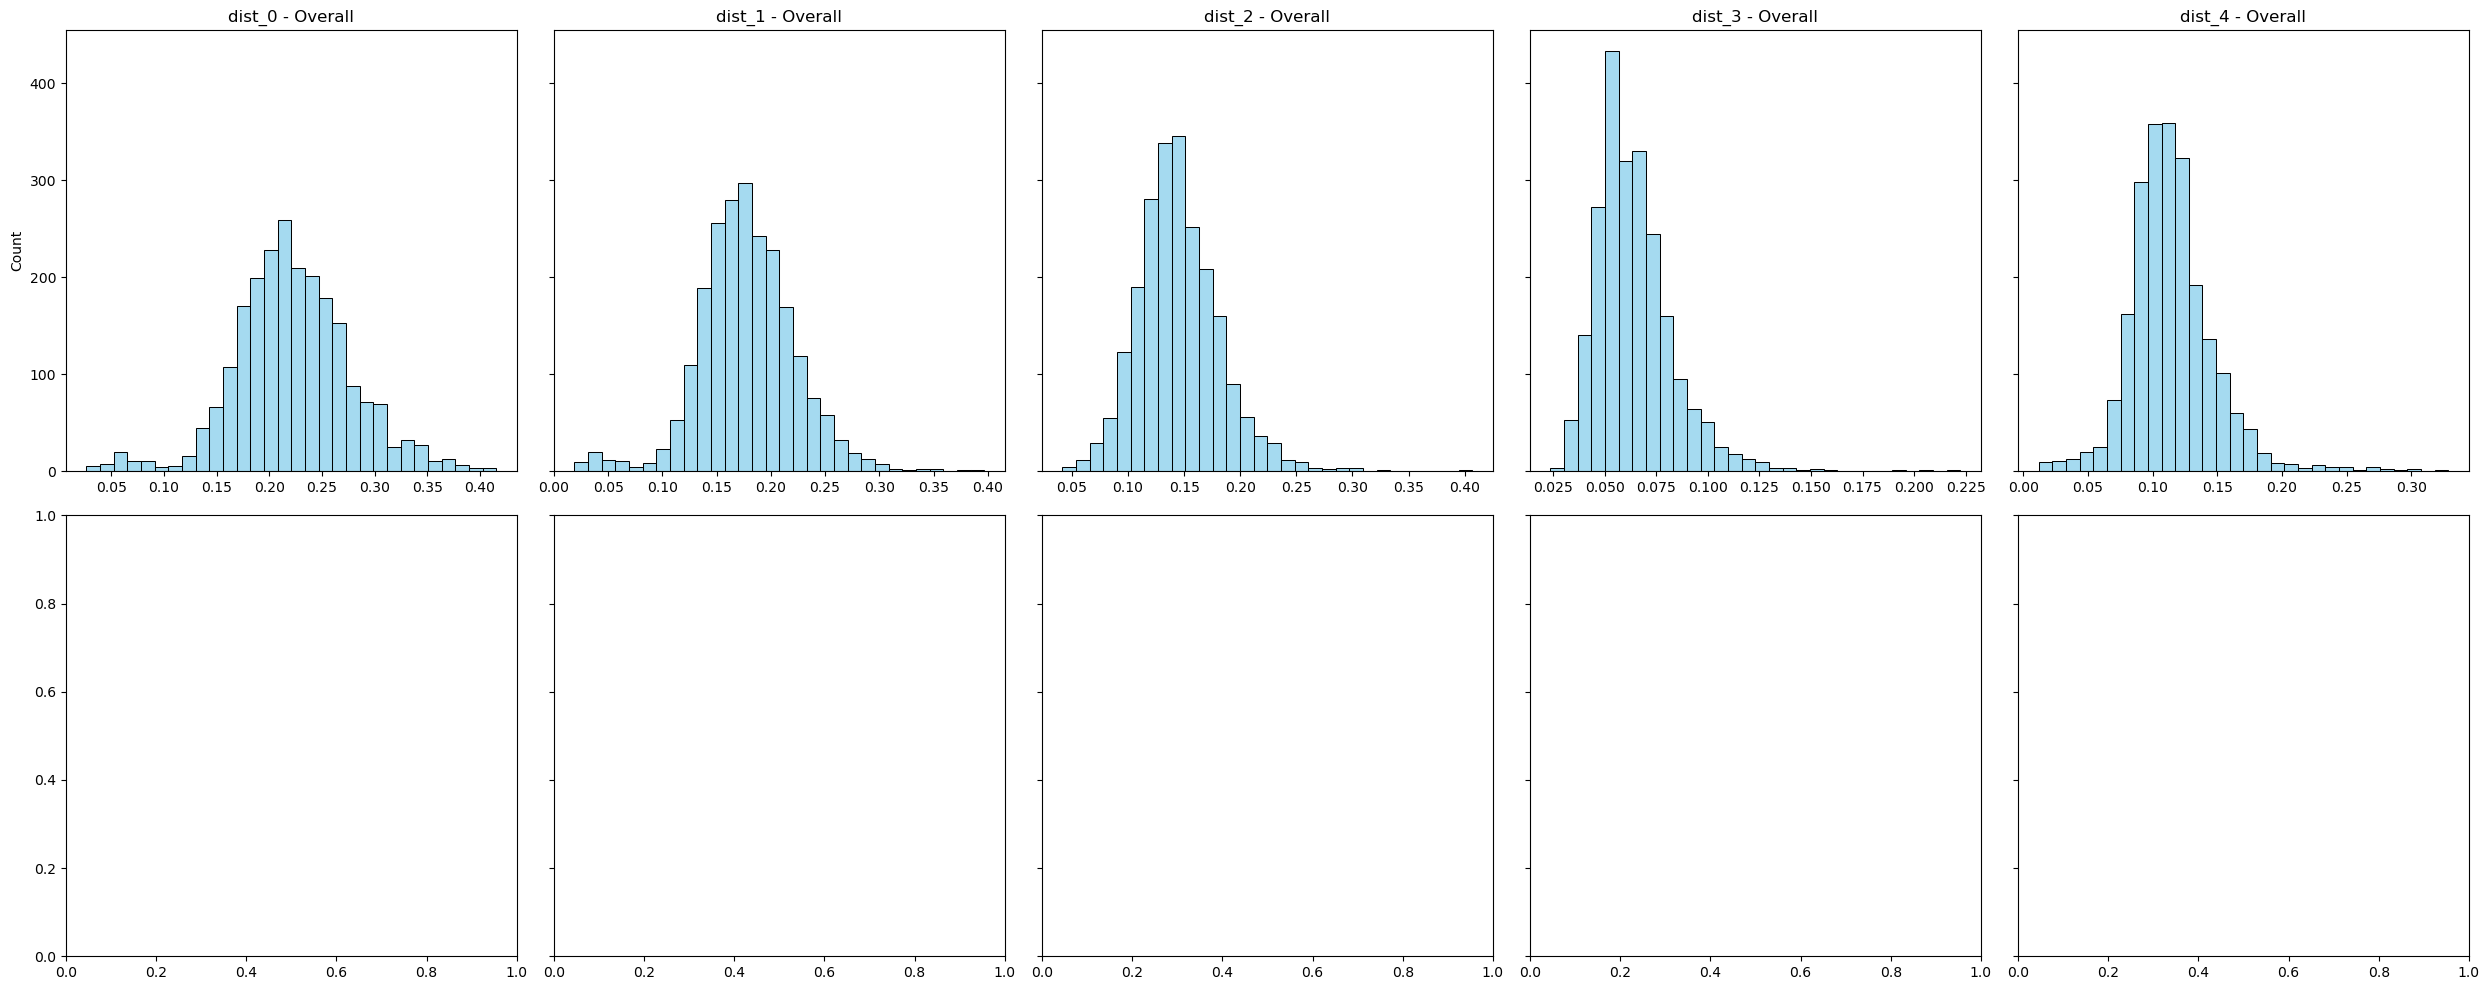

,dist_0_mean,dist_0_std,dist_1_mean,dist_1_std,dist_2_mean,dist_2_std,dist_3_mean,dist_3_std,dist_4_mean,dist_4_std
labels,,,,,,,,,,
0.0,0.073287,0.024541,0.055020,0.023753,0.080324,0.020140,0.060474,0.018374,0.044049,0.016830
1.0,0.212807,0.031649,0.176667,0.040586,0.131417,0.022465,0.064424,0.015208,0.109757,0.028225
2.0,0.217872,0.047423,0.189054,0.036817,0.143905,0.030682,0.061215,0.013694,0.117045,0.022426
3.0,0.222789,0.043997,0.204357,0.042821,0.143462,0.032120,0.065386,0.015101,0.112480,0.022265
4.0,0.198124,0.045394,0.186740,0.031313,0.150756,0.039414,0.064989,0.012073,0.119324,0.028996
...,...,...,...,...,...,...,...,...,...,...
62.0,0.222817,0.042416,0.181372,0.029899,0.154223,0.029059,0.062989,0.016995,0.122710,0.030126
63.0,0.218677,0.036956,0.164926,0.037844,0.149301,0.028943,0.063813,0.017899,0.120413,0.022437
64.0,0.219907,0.047570,0.195182,0.032079,0.149392,0.058384,0.063987,0.015157,0.121341,0.029999


In [175]:
merged_df = process_merge(paths, 165, distance_metric = 'cosine', normalization = 'global')
graph_hists(merged_df)

#### Top 10% Per Class

In [176]:
top_10_percent_idxs, union_all, intersection_all = top_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.013333333333333334
Size of Union: 900
Size of Intersection: 12


#### Bottom 10% Per Class

In [177]:
bottom_10_percent_idxs, union_all, intersection_all = bottom_x_percent_per_label(merged_df, .1)

Jaccard Similarity: 0.0
Size of Union: 935
Size of Intersection: 0
